In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.read_csv('./UJIndoorLoc/trainingData.csv')
test = pd.read_csv('./UJIndoorLoc/validationData.csv')
train, valid = train_test_split(train, test_size=0.3, random_state=1)
train.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
3141,100,100,100,100,100,100,100,100,100,100,...,100,-7316.8672,4.864814e+06,4,2,140,2,6,19,1371720730
801,100,100,100,100,100,100,100,100,100,100,...,100,-7504.8814,4.864866e+06,2,1,9,2,2,23,1371715555
14580,100,100,100,100,100,100,100,100,100,100,...,100,-7373.0528,4.864845e+06,1,2,116,2,15,11,1371721710
18964,100,100,100,100,100,100,100,100,100,100,...,100,-7327.9291,4.864824e+06,1,2,112,2,15,11,1371723315
1071,100,100,100,100,100,100,100,100,100,100,...,100,-7376.4010,4.864774e+06,3,2,223,2,2,23,1371720963


In [11]:
never_used_features = ['FLOOR', 'BUILDINGID', 'SPACEID', 'USERID', 'PHONEID']

In [12]:
features = {'current': list(set(train.columns) - set(never_used_features))}
target = 'FLOOR'

In [14]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from pandas.api.types import is_numeric_dtype
from sklearn.compose import ColumnTransformer

class FeatureEncoding():
    def __init__(self,
                 numeric_features=[],
                 categorical_threshold=20,
                 cat_sigma=1e-4,
                 num_strategy='median',
                 num_strategy_constant=1e10,
                 columns_none_threshold=0.0):
        self.categorical_threshold = categorical_threshold
        self.cat_sigma = cat_sigma
        self.num_strategy = num_strategy
        self.columns_none_threshold = columns_none_threshold
        self.num_strategy_constant = num_strategy_constant
        self.prior_num_features = numeric_features
    
    def _find_categorical_features(self, df):
        cat_features = [col for col, dtype in zip(df.columns, df.dtypes) if not is_numeric_dtype(dtype)]
        features_with_little_variety = df.columns[(df.nunique() < self.categorical_threshold)]
        return list(set(cat_features) | set(features_with_little_variety) - set(self.prior_num_features))
    
    def fit(self, df, target=None):
        self.cat_features = self._find_categorical_features(df)
        self.cat_features = list(set(self.cat_features)) # - set(self.almost_none))
        self.num_features = list(set(df.columns) - set(self.cat_features)) # - set(self.almost_none))
        
        self.cat_encoder = ce.CatBoostEncoder(cols=self.cat_features,
                                              return_df=True,
                                              random_state=self.random_state)
        self.cat_encoder.fit(df[self.cat_features], target)
        
        self.num_encoder = SimpleImputer(strategy=self.num_strategy,
                                         fill_value=self.num_strategy_constant)
        self.num_encoder.fit(df[self.num_features], target)
        
    def transform(self, df):
        df_cat = self.cat_encoder.transform(df[self.cat_features])
        df_num = pd.DataFrame(self.num_encoder.transform(df[self.num_features]),
                              columns=self.num_features,
                              index=df.index)
        return pd.concat([df_cat, df_num], axis=1)
    
    def fit_transform(self, df, target=None):
        self.fit(df, target)
        return self.transform(df)

In [17]:
feature_encoder = FeatureEncoding(cat_sigma=None, columns_none_threshold=0.05)
encoded_train_x = feature_encoder.fit_transform(train_x, train_y)
encoded_oos_x = feature_encoder.transform(oos_x)
encoded_oot_x = feature_encoder.transform(oot_x)

# Feature Selection

In [18]:
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from catboost import CatBoostClassifier
import numpy as np

np.random.seed(1)
encoded_train_x.shape

(4868, 133)

In [19]:
default_model = LGBMClassifier(max_depth=7, n_estimator=150, learning_rate=0.05, n_jobs=10)
scores = cross_val_score(default_model, encoded_train_x, train_y, cv=8, n_jobs=10, scoring=make_scorer(gini_score, needs_proba=True))
print(f"len(feat): {encoded_train_x.shape[1]} Mean: {scores.mean():.4f}, scores: {scores}")

len(feat): 133 Mean: 0.5185, scores: [0.49028293 0.55721243 0.54090909 0.54856481 0.48386347 0.49983724
 0.52503023 0.50244141]


In [20]:
upper = encoded_train_x.corr().abs().where(np.triu(np.ones(len(encoded_train_x.columns)), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
len(encoded_train_x.columns) - len(to_drop)

116

In [21]:
encoded_train_x = encoded_train_x.drop(labels=to_drop, axis=1)
encoded_oos_x = encoded_oos_x.drop(labels=to_drop, axis=1)
encoded_oot_x = encoded_oot_x.drop(labels=to_drop, axis=1)

In [22]:
scores = cross_val_score(default_model, encoded_train_x, train_y, cv=8, n_jobs=10, scoring=make_scorer(gini_score, needs_proba=True))
print(f"len(feat): {encoded_train_x.shape[1]} Mean: {scores.mean():.4f}, scores: {scores}")

len(feat): 116 Mean: 0.5225, scores: [0.50480056 0.555218   0.53910019 0.55203704 0.48211961 0.51453218
 0.52898298 0.50297619]


In [23]:
from sklearn.feature_selection import chi2, SelectPercentile, mutual_info_classif

def unvariative_selection(unvariative_selector, df):
    transformed = unvariative_selector.transform(df)
    transformed = pd.DataFrame(transformed, columns=df.columns[unvariative_selector.get_support()])
    return transformed

unvariative_selector = SelectPercentile(mutual_info_classif, percentile=70)
unvariative_selector.fit(encoded_train_x, train_y)

SelectPercentile(percentile=70,
                 score_func=<function mutual_info_classif at 0x7f59d8d386a8>)

In [24]:
encoded_train_x = unvariative_selection(unvariative_selector, encoded_train_x)
encoded_oos_x = unvariative_selection(unvariative_selector, encoded_oos_x)
encoded_oot_x = unvariative_selection(unvariative_selector, encoded_oot_x)

In [25]:
scores = cross_val_score(default_model, encoded_train_x, train_y, cv=8, n_jobs=10, scoring=make_scorer(gini_score, needs_proba=True))
print(f"len(feat): {encoded_train_x.shape[1]} Mean: {scores.mean():.4f}, scores: {scores}")

len(feat): 81 Mean: 0.5199, scores: [0.5119666  0.5643321  0.53993506 0.55002315 0.48314267 0.4936756
 0.51605515 0.50016276]


In [26]:
import boostaroota as br

In [27]:
br_chooser = br.BoostARoota(clf=default_model, metric='logloss', cutoff=4, iters=50, delta=0.01)
br_chooser.fit(encoded_train_x, train_y)

Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  1  iteration:  11
Round:  1  iteration:  12
Round:  1  iteration:  13
Round:  1  iteration:  14
Round:  1  iteration:  15
Round:  1  iteration:  16
Round:  1  iteration:  17
Round:  1  iteration:  18
Round:  1  iteration:  19
Round:  1  iteration:  20
Round:  1  iteration:  21
Round:  1  iteration:  22
Round:  1  iteration:  23
Round:  1  iteration:  24
Round:  1  iteration:  25
Round:  1  iteration:  26
Round:  1  iteration:  27
Round:  1  iteration:  28
Round:  1  iteration:  29
Round:  1  iteration:  30
Round:  1  iteration:  31
Round:  1  iteration:  32
Round:  1  iteration:  33
Round:  1  iteration:  34
Round:  1  iteration:  35
Round:  1  iteration:  36
Round:  1  iteration:  37
Round:  1  iteration:  38
Round:  1  iteration:

In [28]:
encoded_train_x = encoded_train_x[br_chooser.keep_vars_]
encoded_oos_x = encoded_oos_x[br_chooser.keep_vars_]
encoded_oot_x = encoded_oot_x[br_chooser.keep_vars_]

In [29]:
scores = cross_val_score(default_model, encoded_train_x, train_y, cv=8, n_jobs=10, scoring=make_scorer(gini_score, needs_proba=True))
print(f"len(feat): {encoded_train_x.shape[1]} Mean: {scores.mean():.4f}, scores: {scores}")

len(feat): 47 Mean: 0.5209, scores: [0.50925325 0.55607607 0.55064935 0.55011574 0.48228237 0.48863002
 0.52964565 0.5008138 ]


In [30]:
from genetic_selection import GeneticSelectionCV

In [31]:
gen_selector = GeneticSelectionCV(estimator=default_model,
                                  cv=8,
                                  scoring=make_scorer(gini_score, needs_proba=True),
                                  n_population=55,
                                  max_features=16,
                                  crossover_proba=0.4,
                                  mutation_proba=0.3,
                                  crossover_independent_proba=0.5,
                                  mutation_independent_proba=0.15,
                                  tournament_size=6,
                                  n_gen_no_change=10,
                                  caching=True,
                                  n_jobs=1, )

In [32]:
['industry', 'sd_stlmnt_type_cd', 'lne_pl_agr_os_qty', 'crd_dc_open_qty',
       'crd_ever_nflag', 'srv_ap_p2p_qty', 'srv_sbol_txn_web_1m_qty',
       'crd_pos_utilities_3m_qty', 'srv_thanks_nflag', 'crd_cc_act_qty',
       'crd_inf_cc_total_qty', 'prd_ap_othr_active_qty',
       'crd_otf_trnf_org_rub_amt', 'srv_ap_utl_mnth_1st_txn_qty',
       'crd_dc_mnth_payroll_open_qty', 'crd_dc_pos_eat_out_rub_amt',
       'crd_dc_mnth_social_open_qty', 'srv_sbol_txn_3m_qty',
       'crd_txn_snpd_pos_ever_qty', 'dep_pop_tot_bal_rub_amt', 'lifetime_days',
       'crd_trx_dc_cash_6m_spnd_amt', 'crd_dc_mnth_snc_lst_open_qty',
       'crd_trx_dc_cash_6m_qty', 'crd_trx_spnd_cash_avg_3m_amt',
       'crd_dc_mnth_payroll_act_qty', 'dep_topup_12m_avg_rub_amt',
       'srv_ap_tlc_mnth_lst_txn_qty', 'crd_otf_cc_pos_spend_qty',
       'crd_pos_telecom_rub_3m_amt', 'crd_dc_lst_bal_rub_amt',
       'srv_sbol_txn_atm_3m_amt', 'crd_trx_dc_cash_3m_qty',
       'prd_mnth_1st_prod_open_qty']
pass

In [33]:
gen_selector = gen_selector.fit(encoded_train_x, train_y)

In [34]:
encoded_train_x = encoded_train_x[encoded_train_x.columns[gen_selector.get_support()]]
encoded_oos_x = encoded_oos_x[encoded_oos_x.columns[gen_selector.get_support()]]
encoded_oot_x = encoded_oot_x[encoded_oot_x.columns[gen_selector.get_support()]]

In [35]:
list(encoded_train_x.columns)

['crd_dc_lst_ips_cd',
 'sd_name_age_segment_cd',
 'srv_thanks_nflag',
 'crd_ever_nflag',
 'crd_dc_open_qty',
 'sd_stlmnt_type_cd',
 'industry',
 'crd_trx_spnd_pos_avg_3m_amt',
 'crd_trx_dc_cash_6m_spnd_amt',
 'tp_mnth_lst_grace_end_exp_qty',
 'crd_trx_dc_cash_6m_spnd_qty',
 'crd_pos_special_rub_3m_amt',
 'crd_dc_mnth_social_act_qty',
 'lifetime_days']

In [37]:
from itertools import combinations

best = {'features': [], 'metric': -1}
for repeat in range(1, 8):
    for features in combinations(list(encoded_train_x.columns), repeat):
        features = list(features)
        score = cross_val_score(default_model,
                                 encoded_train_x[features],
                                 train_y,
                                 cv=8,
                                 n_jobs=10,
                                 scoring=make_scorer(gini_score, needs_proba=True)).mean()
        if score > best['metric']:
            best['metric'] = score
            best['features'] = features
            print(f'Have found new features, with score={best["metric"]}:\n {best["features"]}')
        

Have found new features, with score=0.19462158219900966:
 ['crd_dc_lst_ips_cd']
Have found new features, with score=0.21147552534271283:
 ['crd_ever_nflag']
Have found new features, with score=0.344488236089101:
 ['industry']
Have found new features, with score=0.42146021215758245:
 ['crd_dc_lst_ips_cd', 'industry']
Have found new features, with score=0.4238175681365902:
 ['crd_ever_nflag', 'industry']
Have found new features, with score=0.47170715755624376:
 ['industry', 'lifetime_days']
Have found new features, with score=0.5269491801317275:
 ['crd_dc_lst_ips_cd', 'industry', 'lifetime_days']
Have found new features, with score=0.5346328981748555:
 ['crd_ever_nflag', 'industry', 'lifetime_days']
Have found new features, with score=0.5360243295451861:
 ['crd_dc_lst_ips_cd', 'sd_name_age_segment_cd', 'industry', 'lifetime_days']
Have found new features, with score=0.5365839894245656:
 ['crd_dc_lst_ips_cd', 'srv_thanks_nflag', 'industry', 'lifetime_days']
Have found new features, with s

In [38]:
ff = ['sd_name_age_segment_cd', 'srv_thanks_nflag', 'crd_ever_nflag', 'industry', 'tp_mnth_lst_grace_end_exp_qty', 'lifetime_days']

In [39]:
encoded_train_x = encoded_train_x[ff]
encoded_oos_x = encoded_oos_x[ff]
encoded_oot_x = encoded_oot_x[ff]

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import optuna
from optuna import Trial

In [42]:
def objective(trial: Trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 400, step=50)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 4, 8, 16])
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    
    rf = RandomForestClassifier(n_estimators=n_estimators,
                                max_depth=max_depth,
                                min_samples_split=min_samples_split,
                                max_features=max_features,
                                n_jobs=5)
    return cross_val_score(estimator=rf, X=encoded_train_x, y=train_y, scoring=make_scorer(gini_score, needs_proba=True), cv=3, n_jobs=7).mean()

In [43]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=7000)

[I 2022-04-29 13:16:31,165] A new study created in memory with name: no-name-36ec5a86-d40f-422e-b4b5-5c245b3a190a
[I 2022-04-29 13:16:35,704] Trial 0 finished with value: 0.47546409572766185 and parameters: {'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.47546409572766185.
[I 2022-04-29 13:16:40,336] Trial 1 finished with value: 0.49723508643634196 and parameters: {'n_estimators': 250, 'max_depth': 4, 'min_samples_split': 2, 'max_features': 'auto'}. Best is trial 1 with value: 0.49723508643634196.
[I 2022-04-29 13:16:44,824] Trial 2 finished with value: 0.5358220665280887 and parameters: {'n_estimators': 250, 'max_depth': 8, 'min_samples_split': 4, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5358220665280887.
[I 2022-04-29 13:16:45,430] Trial 3 finished with value: 0.5086278825948544 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 2, 'max_features': 'auto'}. Best is trial 2 with 

In [48]:
study.best_trial.params

{'n_estimators': 150,
 'max_depth': 12,
 'min_samples_split': 16,
 'max_features': 'log2'}

In [49]:
rf_model = RandomForestClassifier(n_jobs=5, **study.best_trial.params)
rf_model.fit(encoded_train_x, train_y)

RandomForestClassifier(max_depth=12, max_features='log2', min_samples_split=16,
                       n_estimators=150, n_jobs=5)

In [50]:
make_scorer(gini_score, needs_proba=True)(rf_model, encoded_oos_x, oos_y)

0.5702023014105422

In [51]:
make_scorer(gini_score, needs_proba=True)(rf_model, encoded_oot_x, oot_y)

0.5003895053188594

In [123]:
from auto_alt_modAD import AltModAD

In [124]:
autoaltmode = AltModAD(encoded_train_x, train_y, metric='gini', model_type='binary')

Start of feature selection...


100%|██████████| 10/10 [00:01<00:00,  7.55it/s]



Stepwise forward feature selection is in process...
1 feature out of 6 is selected, gini = 0.301
2 features out of 6 are selected, gini = 0.492
3 features out of 6 are selected, gini = 0.564
4 features out of 6 are selected, gini = 0.582
5 features out of 6 are selected, gini = 0.589


[I 2022-04-28 15:31:34,873] A new study created in memory with name: no-name-aeb69a84-8a69-4dc8-8042-90412116f3db


6 features out of 6 are selected, gini = 0.585
The maximum number of features selected
Forward feature selection is finished! 6 features out of 6 are selected.
Run optuna...


[I 2022-04-28 15:31:35,076] Trial 0 finished with value: 0.4535123758025099 and parameters: {'min_data_in_leaf': 55, 'min_data_in_bin': 73, 'min_gain_to_split': 2.39, 'max_depth': 8, 'n_estimators': 152, 'boosting_type': 'dart', 'lambda_l1': 2.8458715588354817, 'lambda_l2': 3.4522304778590653, 'num_leaves': 116, 'feature_fraction': 0.6645484014882492, 'bagging_fraction': 0.5655069599897277, 'bagging_freq': 7, 'min_child_samples': 38, 'max_bin': 82}. Best is trial 0 with value: 0.4535123758025099.
[I 2022-04-28 15:31:35,215] Trial 1 finished with value: 0.44460018014178004 and parameters: {'min_data_in_leaf': 10, 'min_data_in_bin': 179, 'min_gain_to_split': 3.54, 'max_depth': 5, 'n_estimators': 482, 'boosting_type': 'gbdt', 'lambda_l1': 2.335752053457227, 'lambda_l2': 3.6066335840013757, 'num_leaves': 149, 'feature_fraction': 0.9813892481237547, 'bagging_fraction': 0.8271871202497048, 'bagging_freq': 7, 'min_child_samples': 32, 'max_bin': 106}. Best is trial 1 with value: 0.444600180141

0.5464876241974901
0.55539981985822


[I 2022-04-28 15:31:35,378] Trial 2 finished with value: 0.4507682471333656 and parameters: {'min_data_in_leaf': 18, 'min_data_in_bin': 89, 'min_gain_to_split': 2.6100000000000003, 'max_depth': 6, 'n_estimators': 491, 'boosting_type': 'gbdt', 'lambda_l1': 5.769798155707295, 'lambda_l2': 8.579095205220693, 'num_leaves': 95, 'feature_fraction': 0.9778868947958537, 'bagging_fraction': 0.63230689196572, 'bagging_freq': 1, 'min_child_samples': 96, 'max_bin': 134}. Best is trial 1 with value: 0.44460018014178004.
[I 2022-04-28 15:31:35,504] Trial 3 finished with value: 0.455752480838546 and parameters: {'min_data_in_leaf': 83, 'min_data_in_bin': 152, 'min_gain_to_split': 1.83, 'max_depth': 3, 'n_estimators': 321, 'boosting_type': 'gbdt', 'lambda_l1': 1.9614415689219862, 'lambda_l2': 6.095040517569636, 'num_leaves': 39, 'feature_fraction': 0.4336150564216978, 'bagging_fraction': 0.7567299619896097, 'bagging_freq': 2, 'min_child_samples': 80, 'max_bin': 41}. Best is trial 1 with value: 0.44460

0.5492317528666344
0.544247519161454


[I 2022-04-28 15:31:36,096] Trial 4 finished with value: 0.47297639956006843 and parameters: {'min_data_in_leaf': 96, 'min_data_in_bin': 81, 'min_gain_to_split': 0.7, 'max_depth': 4, 'n_estimators': 391, 'boosting_type': 'dart', 'lambda_l1': 9.734357657923356, 'lambda_l2': 0.7263013680832121, 'num_leaves': 183, 'feature_fraction': 0.844975053073285, 'bagging_fraction': 0.4499457579686954, 'bagging_freq': 6, 'min_child_samples': 14, 'max_bin': 103}. Best is trial 1 with value: 0.44460018014178004.
[I 2022-04-28 15:31:36,194] Trial 5 finished with value: 0.46817417438906594 and parameters: {'min_data_in_leaf': 74, 'min_data_in_bin': 245, 'min_gain_to_split': 3.4000000000000004, 'max_depth': 8, 'n_estimators': 217, 'boosting_type': 'gbdt', 'lambda_l1': 6.793368666545472, 'lambda_l2': 1.8832966282139787, 'num_leaves': 249, 'feature_fraction': 0.5463684799502655, 'bagging_fraction': 0.639932451252504, 'bagging_freq': 3, 'min_child_samples': 36, 'max_bin': 60}. Best is trial 1 with value: 0.

0.5270236004399316
0.531825825610934
0.5303121990831126


[I 2022-04-28 15:31:37,526] Trial 7 finished with value: 0.44963730521586687 and parameters: {'min_data_in_leaf': 99, 'min_data_in_bin': 93, 'min_gain_to_split': 2.3000000000000003, 'max_depth': 3, 'n_estimators': 539, 'boosting_type': 'dart', 'lambda_l1': 2.84837783699405, 'lambda_l2': 5.916837057837165, 'num_leaves': 82, 'feature_fraction': 0.7684808640243139, 'bagging_fraction': 0.727253771368329, 'bagging_freq': 2, 'min_child_samples': 18, 'max_bin': 114}. Best is trial 1 with value: 0.44460018014178004.


0.5503626947841331


[I 2022-04-28 15:31:37,890] Trial 8 finished with value: 0.4707767408649606 and parameters: {'min_data_in_leaf': 36, 'min_data_in_bin': 85, 'min_gain_to_split': 4.55, 'max_depth': 7, 'n_estimators': 272, 'boosting_type': 'dart', 'lambda_l1': 3.8974359709193593, 'lambda_l2': 9.745066918430938, 'num_leaves': 245, 'feature_fraction': 0.5373558599198122, 'bagging_fraction': 0.8818194791658373, 'bagging_freq': 5, 'min_child_samples': 72, 'max_bin': 204}. Best is trial 1 with value: 0.44460018014178004.


0.5292232591350394


[I 2022-04-28 15:31:38,142] Trial 9 finished with value: 0.4560822740799626 and parameters: {'min_data_in_leaf': 59, 'min_data_in_bin': 5, 'min_gain_to_split': 3.99, 'max_depth': 7, 'n_estimators': 188, 'boosting_type': 'dart', 'lambda_l1': 7.070076069580215, 'lambda_l2': 3.091815219877036, 'num_leaves': 249, 'feature_fraction': 0.7194781020832204, 'bagging_fraction': 0.8367567270660776, 'bagging_freq': 1, 'min_child_samples': 66, 'max_bin': 34}. Best is trial 1 with value: 0.44460018014178004.


0.5439177259200374


[I 2022-04-28 15:31:38,395] Trial 10 finished with value: 0.48143279607110445 and parameters: {'min_data_in_leaf': 4, 'min_data_in_bin': 222, 'min_gain_to_split': 0.41000000000000003, 'max_depth': 1, 'n_estimators': 599, 'boosting_type': 'gbdt', 'lambda_l1': 0.7754179114140145, 'lambda_l2': 0.16281826157840307, 'num_leaves': 186, 'feature_fraction': 0.9390197973457177, 'bagging_fraction': 0.986291230500663, 'bagging_freq': 7, 'min_child_samples': 40, 'max_bin': 188}. Best is trial 1 with value: 0.44460018014178004.


0.5185672039288955


[I 2022-04-28 15:31:39,183] Trial 11 finished with value: 0.5152630490007419 and parameters: {'min_data_in_leaf': 32, 'min_data_in_bin': 187, 'min_gain_to_split': 3.22, 'max_depth': 1, 'n_estimators': 575, 'boosting_type': 'dart', 'lambda_l1': 0.08656584521585575, 'lambda_l2': 6.068929163774832, 'num_leaves': 57, 'feature_fraction': 0.8195025553282166, 'bagging_fraction': 0.77992550525292, 'bagging_freq': 3, 'min_child_samples': 5, 'max_bin': 148}. Best is trial 1 with value: 0.44460018014178004.


0.48473695099925806


[I 2022-04-28 15:31:40,554] Trial 12 finished with value: 0.4410377908830836 and parameters: {'min_data_in_leaf': 4, 'min_data_in_bin': 18, 'min_gain_to_split': 1.6300000000000001, 'max_depth': 5, 'n_estimators': 475, 'boosting_type': 'dart', 'lambda_l1': 4.050098756528405, 'lambda_l2': 5.713807778940003, 'num_leaves': 160, 'feature_fraction': 0.8571924492943558, 'bagging_fraction': 0.9402116785077667, 'bagging_freq': 5, 'min_child_samples': 22, 'max_bin': 123}. Best is trial 12 with value: 0.4410377908830836.


0.5589622091169164


[I 2022-04-28 15:31:40,769] Trial 13 finished with value: 0.44354701964914356 and parameters: {'min_data_in_leaf': 8, 'min_data_in_bin': 10, 'min_gain_to_split': 1.34, 'max_depth': 5, 'n_estimators': 438, 'boosting_type': 'gbdt', 'lambda_l1': 4.492169764877383, 'lambda_l2': 8.126260406467422, 'num_leaves': 161, 'feature_fraction': 0.901674948298631, 'bagging_fraction': 0.9953284583869444, 'bagging_freq': 6, 'min_child_samples': 22, 'max_bin': 253}. Best is trial 12 with value: 0.4410377908830836.


0.5564529803508564


[I 2022-04-28 15:31:41,908] Trial 14 finished with value: 0.439038808264121 and parameters: {'min_data_in_leaf': 23, 'min_data_in_bin': 1, 'min_gain_to_split': 1.2400000000000002, 'max_depth': 5, 'n_estimators': 413, 'boosting_type': 'dart', 'lambda_l1': 4.693223475776565, 'lambda_l2': 7.918503140143878, 'num_leaves': 166, 'feature_fraction': 0.8950439788761264, 'bagging_fraction': 0.9939751412009973, 'bagging_freq': 5, 'min_child_samples': 20, 'max_bin': 242}. Best is trial 14 with value: 0.439038808264121.


0.560961191735879


[I 2022-04-28 15:31:42,944] Trial 15 finished with value: 0.4422076235130137 and parameters: {'min_data_in_leaf': 27, 'min_data_in_bin': 36, 'min_gain_to_split': 1.2000000000000002, 'max_depth': 6, 'n_estimators': 391, 'boosting_type': 'dart', 'lambda_l1': 5.549710537646952, 'lambda_l2': 7.516503188374623, 'num_leaves': 204, 'feature_fraction': 0.8731272685232427, 'bagging_fraction': 0.9349476702830246, 'bagging_freq': 5, 'min_child_samples': 57, 'max_bin': 250}. Best is trial 14 with value: 0.439038808264121.


0.5577923764869863


[I 2022-04-28 15:31:44,192] Trial 16 finished with value: 0.4310973247856733 and parameters: {'min_data_in_leaf': 39, 'min_data_in_bin': 39, 'min_gain_to_split': 0.18, 'max_depth': 4, 'n_estimators': 446, 'boosting_type': 'dart', 'lambda_l1': 3.959728285785017, 'lambda_l2': 9.459088233660083, 'num_leaves': 139, 'feature_fraction': 0.7799527527860111, 'bagging_fraction': 0.9404531166722089, 'bagging_freq': 5, 'min_child_samples': 5, 'max_bin': 172}. Best is trial 16 with value: 0.4310973247856733.


0.5689026752143267


[I 2022-04-28 15:31:44,657] Trial 17 finished with value: 0.533843475771864 and parameters: {'min_data_in_leaf': 44, 'min_data_in_bin': 48, 'min_gain_to_split': 0.18, 'max_depth': 2, 'n_estimators': 394, 'boosting_type': 'dart', 'lambda_l1': 8.663011641340518, 'lambda_l2': 9.714277024597305, 'num_leaves': 2, 'feature_fraction': 0.6993539815647425, 'bagging_fraction': 0.9929990457626243, 'bagging_freq': 4, 'min_child_samples': 6, 'max_bin': 216}. Best is trial 16 with value: 0.4310973247856733.


0.466156524228136


[I 2022-04-28 15:31:46,007] Trial 18 finished with value: 0.44052132222199747 and parameters: {'min_data_in_leaf': 45, 'min_data_in_bin': 42, 'min_gain_to_split': 0.8, 'max_depth': 4, 'n_estimators': 516, 'boosting_type': 'dart', 'lambda_l1': 5.430728428890917, 'lambda_l2': 7.312772196736171, 'num_leaves': 125, 'feature_fraction': 0.6329531856882403, 'bagging_fraction': 0.9058942579824769, 'bagging_freq': 6, 'min_child_samples': 50, 'max_bin': 163}. Best is trial 16 with value: 0.4310973247856733.


0.5594786777780025


[I 2022-04-28 15:31:47,267] Trial 19 finished with value: 0.4316169047037539 and parameters: {'min_data_in_leaf': 21, 'min_data_in_bin': 108, 'min_gain_to_split': 0.16, 'max_depth': 4, 'n_estimators': 443, 'boosting_type': 'dart', 'lambda_l1': 1.1278965897955415, 'lambda_l2': 8.966741760869557, 'num_leaves': 202, 'feature_fraction': 0.7714660933411663, 'bagging_fraction': 0.8591258121698649, 'bagging_freq': 5, 'min_child_samples': 13, 'max_bin': 229}. Best is trial 16 with value: 0.4310973247856733.


0.5683830952962461


[I 2022-04-28 15:31:47,780] Trial 20 finished with value: 0.4806658712219618 and parameters: {'min_data_in_leaf': 40, 'min_data_in_bin': 118, 'min_gain_to_split': 0.18, 'max_depth': 2, 'n_estimators': 344, 'boosting_type': 'dart', 'lambda_l1': 0.7127364002337799, 'lambda_l2': 9.09129746203241, 'num_leaves': 201, 'feature_fraction': 0.762522403586951, 'bagging_fraction': 0.8486850078963849, 'bagging_freq': 4, 'min_child_samples': 9, 'max_bin': 176}. Best is trial 16 with value: 0.4310973247856733.


0.5193341287780382


[I 2022-04-28 15:31:49,056] Trial 21 finished with value: 0.4361997862566447 and parameters: {'min_data_in_leaf': 23, 'min_data_in_bin': 59, 'min_gain_to_split': 0.92, 'max_depth': 4, 'n_estimators': 446, 'boosting_type': 'dart', 'lambda_l1': 1.6150381752025815, 'lambda_l2': 9.78942612488236, 'num_leaves': 212, 'feature_fraction': 0.7797689791380207, 'bagging_fraction': 0.9481238768390041, 'bagging_freq': 5, 'min_child_samples': 28, 'max_bin': 226}. Best is trial 16 with value: 0.4310973247856733.


0.5638002137433553


[I 2022-04-28 15:31:50,324] Trial 22 finished with value: 0.43339809933310214 and parameters: {'min_data_in_leaf': 17, 'min_data_in_bin': 122, 'min_gain_to_split': 0.55, 'max_depth': 4, 'n_estimators': 450, 'boosting_type': 'dart', 'lambda_l1': 1.5272697480250668, 'lambda_l2': 9.92079583701339, 'num_leaves': 225, 'feature_fraction': 0.8054666103942525, 'bagging_fraction': 0.9400859247364011, 'bagging_freq': 6, 'min_child_samples': 27, 'max_bin': 229}. Best is trial 16 with value: 0.4310973247856733.


0.5666019006668979


[I 2022-04-28 15:31:51,960] Trial 23 finished with value: 0.4301546139163417 and parameters: {'min_data_in_leaf': 16, 'min_data_in_bin': 121, 'min_gain_to_split': 0.15000000000000002, 'max_depth': 4, 'n_estimators': 542, 'boosting_type': 'dart', 'lambda_l1': 0.056807125321976404, 'lambda_l2': 9.02128957316748, 'num_leaves': 225, 'feature_fraction': 0.6254775565721598, 'bagging_fraction': 0.8803814005902653, 'bagging_freq': 6, 'min_child_samples': 10, 'max_bin': 197}. Best is trial 23 with value: 0.4301546139163417.


0.5698453860836583


[I 2022-04-28 15:31:53,010] Trial 24 finished with value: 0.46378885765532574 and parameters: {'min_data_in_leaf': 31, 'min_data_in_bin': 113, 'min_gain_to_split': 0.21000000000000002, 'max_depth': 2, 'n_estimators': 556, 'boosting_type': 'dart', 'lambda_l1': 0.12428089245669288, 'lambda_l2': 8.933073630614896, 'num_leaves': 142, 'feature_fraction': 0.6089033539743227, 'bagging_fraction': 0.7919637536744861, 'bagging_freq': 6, 'min_child_samples': 5, 'max_bin': 197}. Best is trial 23 with value: 0.4301546139163417.


0.5362111423446743


[I 2022-04-28 15:31:54,280] Trial 25 finished with value: 0.4385721197149466 and parameters: {'min_data_in_leaf': 14, 'min_data_in_bin': 158, 'min_gain_to_split': 0.27, 'max_depth': 3, 'n_estimators': 523, 'boosting_type': 'dart', 'lambda_l1': 3.4248263417180147, 'lambda_l2': 7.020189452823929, 'num_leaves': 193, 'feature_fraction': 0.712675167112854, 'bagging_fraction': 0.8866228054316404, 'bagging_freq': 5, 'min_child_samples': 13, 'max_bin': 168}. Best is trial 23 with value: 0.4301546139163417.


0.5614278802850534


[I 2022-04-28 15:31:55,999] Trial 26 finished with value: 0.4376122969321452 and parameters: {'min_data_in_leaf': 47, 'min_data_in_bin': 176, 'min_gain_to_split': 0.99, 'max_depth': 6, 'n_estimators': 579, 'boosting_type': 'dart', 'lambda_l1': 0.9535575343761336, 'lambda_l2': 8.727149965041534, 'num_leaves': 223, 'feature_fraction': 0.604866441733324, 'bagging_fraction': 0.6781902571545564, 'bagging_freq': 6, 'min_child_samples': 47, 'max_bin': 210}. Best is trial 23 with value: 0.4301546139163417.


0.5623877030678548


[I 2022-04-28 15:31:57,385] Trial 27 finished with value: 0.4403004229753884 and parameters: {'min_data_in_leaf': 36, 'min_data_in_bin': 107, 'min_gain_to_split': 1.7200000000000002, 'max_depth': 4, 'n_estimators': 503, 'boosting_type': 'dart', 'lambda_l1': 0.023654793802383896, 'lambda_l2': 6.93842042126696, 'num_leaves': 104, 'feature_fraction': 0.674695939987549, 'bagging_fraction': 0.8669770036886464, 'bagging_freq': 3, 'min_child_samples': 11, 'max_bin': 183}. Best is trial 23 with value: 0.4301546139163417.


0.5596995770246116


[I 2022-04-28 15:31:58,133] Trial 28 finished with value: 0.44535621559144234 and parameters: {'min_data_in_leaf': 23, 'min_data_in_bin': 202, 'min_gain_to_split': 0.49, 'max_depth': 3, 'n_estimators': 367, 'boosting_type': 'dart', 'lambda_l1': 2.971894260004958, 'lambda_l2': 4.690501162389302, 'num_leaves': 141, 'feature_fraction': 0.7393150154506113, 'bagging_fraction': 0.8080472661083655, 'bagging_freq': 4, 'min_child_samples': 6, 'max_bin': 159}. Best is trial 23 with value: 0.4301546139163417.
[I 2022-04-28 15:31:58,303] Trial 29 finished with value: 0.45885440406205724 and parameters: {'min_data_in_leaf': 51, 'min_data_in_bin': 139, 'min_gain_to_split': 2.49, 'max_depth': 4, 'n_estimators': 109, 'boosting_type': 'dart', 'lambda_l1': 2.1527261030971494, 'lambda_l2': 9.33976758966385, 'num_leaves': 179, 'feature_fraction': 0.6516891398780438, 'bagging_fraction': 0.5403654876324321, 'bagging_freq': 7, 'min_child_samples': 15, 'max_bin': 234}. Best is trial 23 with value: 0.430154613

0.5546437844085577
0.5411455959379428


[I 2022-04-28 15:31:58,991] Trial 30 finished with value: 0.4620341087104307 and parameters: {'min_data_in_leaf': 12, 'min_data_in_bin': 66, 'min_gain_to_split': 2.14, 'max_depth': 2, 'n_estimators': 426, 'boosting_type': 'dart', 'lambda_l1': 3.538943169869733, 'lambda_l2': 8.232957268346834, 'num_leaves': 224, 'feature_fraction': 0.42640734654076523, 'bagging_fraction': 0.7286263720259634, 'bagging_freq': 5, 'min_child_samples': 44, 'max_bin': 194}. Best is trial 23 with value: 0.4301546139163417.


0.5379658912895693


[I 2022-04-28 15:32:00,324] Trial 31 finished with value: 0.4311191035846349 and parameters: {'min_data_in_leaf': 18, 'min_data_in_bin': 133, 'min_gain_to_split': 0.52, 'max_depth': 4, 'n_estimators': 461, 'boosting_type': 'dart', 'lambda_l1': 1.4570495722246148, 'lambda_l2': 9.74146943843665, 'num_leaves': 227, 'feature_fraction': 0.8094022153021514, 'bagging_fraction': 0.9168376066530852, 'bagging_freq': 6, 'min_child_samples': 27, 'max_bin': 223}. Best is trial 23 with value: 0.4301546139163417.


0.5688808964153651


[I 2022-04-28 15:32:01,935] Trial 32 finished with value: 0.4297299273365929 and parameters: {'min_data_in_leaf': 19, 'min_data_in_bin': 164, 'min_gain_to_split': 0.12000000000000001, 'max_depth': 5, 'n_estimators': 476, 'boosting_type': 'dart', 'lambda_l1': 1.230064936478923, 'lambda_l2': 9.25997565726787, 'num_leaves': 233, 'feature_fraction': 0.8010083782633031, 'bagging_fraction': 0.9074388677720654, 'bagging_freq': 7, 'min_child_samples': 29, 'max_bin': 219}. Best is trial 32 with value: 0.4297299273365929.


0.5702700726634071


[I 2022-04-28 15:32:03,618] Trial 33 finished with value: 0.43283029493160674 and parameters: {'min_data_in_leaf': 9, 'min_data_in_bin': 167, 'min_gain_to_split': 0.59, 'max_depth': 6, 'n_estimators': 475, 'boosting_type': 'dart', 'lambda_l1': 0.4488378881087398, 'lambda_l2': 9.916223290969846, 'num_leaves': 256, 'feature_fraction': 0.8174112931688108, 'bagging_fraction': 0.9211805166266055, 'bagging_freq': 7, 'min_child_samples': 31, 'max_bin': 216}. Best is trial 32 with value: 0.4297299273365929.


0.5671697050683933


[I 2022-04-28 15:32:05,257] Trial 34 finished with value: 0.43640668484677825 and parameters: {'min_data_in_leaf': 29, 'min_data_in_bin': 135, 'min_gain_to_split': 0.12000000000000001, 'max_depth': 5, 'n_estimators': 480, 'boosting_type': 'dart', 'lambda_l1': 2.457872525133725, 'lambda_l2': 9.321769561915382, 'num_leaves': 232, 'feature_fraction': 0.953209028222874, 'bagging_fraction': 0.9658456035061332, 'bagging_freq': 7, 'min_child_samples': 37, 'max_bin': 148}. Best is trial 32 with value: 0.4297299273365929.


0.5635933151532218


[I 2022-04-28 15:32:06,980] Trial 35 finished with value: 0.43509684565209605 and parameters: {'min_data_in_leaf': 3, 'min_data_in_bin': 201, 'min_gain_to_split': 0.91, 'max_depth': 5, 'n_estimators': 547, 'boosting_type': 'dart', 'lambda_l1': 1.5145833368285666, 'lambda_l2': 8.516630666649851, 'num_leaves': 213, 'feature_fraction': 0.6717998997674899, 'bagging_fraction': 0.9085094132578417, 'bagging_freq': 7, 'min_child_samples': 25, 'max_bin': 177}. Best is trial 32 with value: 0.4297299273365929.


0.564903154347904


[I 2022-04-28 15:32:08,240] Trial 36 finished with value: 0.44491286146972686 and parameters: {'min_data_in_leaf': 14, 'min_data_in_bin': 153, 'min_gain_to_split': 2.7600000000000002, 'max_depth': 6, 'n_estimators': 491, 'boosting_type': 'dart', 'lambda_l1': 2.421701586947324, 'lambda_l2': 7.720141666344741, 'num_leaves': 13, 'feature_fraction': 0.8351982543101727, 'bagging_fraction': 0.8132369999101052, 'bagging_freq': 6, 'min_child_samples': 32, 'max_bin': 207}. Best is trial 32 with value: 0.4297299273365929.


0.5550871385302731


[I 2022-04-28 15:32:09,289] Trial 37 finished with value: 0.4531390249631706 and parameters: {'min_data_in_leaf': 57, 'min_data_in_bin': 97, 'min_gain_to_split': 4.97, 'max_depth': 3, 'n_estimators': 520, 'boosting_type': 'dart', 'lambda_l1': 1.7866449315507853, 'lambda_l2': 6.536995656942245, 'num_leaves': 80, 'feature_fraction': 0.4728701499154988, 'bagging_fraction': 0.893323765114379, 'bagging_freq': 6, 'min_child_samples': 56, 'max_bin': 198}. Best is trial 32 with value: 0.4297299273365929.


0.5468609750368294


[I 2022-04-28 15:32:09,560] Trial 38 finished with value: 0.44420971738897097 and parameters: {'min_data_in_leaf': 17, 'min_data_in_bin': 230, 'min_gain_to_split': 0.65, 'max_depth': 4, 'n_estimators': 598, 'boosting_type': 'gbdt', 'lambda_l1': 1.2467667882027695, 'lambda_l2': 8.433890507475818, 'num_leaves': 256, 'feature_fraction': 0.5974432935243624, 'bagging_fraction': 0.9662764795390081, 'bagging_freq': 7, 'min_child_samples': 96, 'max_bin': 221}. Best is trial 32 with value: 0.4297299273365929.


0.555790282611029


[I 2022-04-28 15:32:10,854] Trial 39 finished with value: 0.4390854771190382 and parameters: {'min_data_in_leaf': 40, 'min_data_in_bin': 129, 'min_gain_to_split': 0.39, 'max_depth': 7, 'n_estimators': 458, 'boosting_type': 'dart', 'lambda_l1': 6.50515637829786, 'lambda_l2': 4.532355904124332, 'num_leaves': 239, 'feature_fraction': 0.799025098391391, 'bagging_fraction': 0.7613226473289292, 'bagging_freq': 6, 'min_child_samples': 18, 'max_bin': 136}. Best is trial 32 with value: 0.4297299273365929.


0.5609145228809618


[I 2022-04-28 15:32:11,491] Trial 40 finished with value: 0.44091956311729286 and parameters: {'min_data_in_leaf': 27, 'min_data_in_bin': 184, 'min_gain_to_split': 1.35, 'max_depth': 9, 'n_estimators': 304, 'boosting_type': 'dart', 'lambda_l1': 3.2467757621224935, 'lambda_l2': 9.465691615803296, 'num_leaves': 176, 'feature_fraction': 0.7334340758397242, 'bagging_fraction': 0.8326300773328303, 'bagging_freq': 7, 'min_child_samples': 33, 'max_bin': 240}. Best is trial 32 with value: 0.4297299273365929.


0.5590804368827071


[I 2022-04-28 15:32:12,624] Trial 41 finished with value: 0.4284029762284409 and parameters: {'min_data_in_leaf': 19, 'min_data_in_bin': 103, 'min_gain_to_split': 0.19, 'max_depth': 4, 'n_estimators': 419, 'boosting_type': 'dart', 'lambda_l1': 1.1938768921156129, 'lambda_l2': 8.842606614182479, 'num_leaves': 199, 'feature_fraction': 0.7541498058746657, 'bagging_fraction': 0.8669322306868883, 'bagging_freq': 5, 'min_child_samples': 15, 'max_bin': 253}. Best is trial 41 with value: 0.4284029762284409.


0.5715970237715591


[I 2022-04-28 15:32:13,961] Trial 42 finished with value: 0.4328365174455959 and parameters: {'min_data_in_leaf': 19, 'min_data_in_bin': 77, 'min_gain_to_split': 0.1, 'max_depth': 5, 'n_estimators': 415, 'boosting_type': 'dart', 'lambda_l1': 0.47474566438716664, 'lambda_l2': 9.97297600993186, 'num_leaves': 212, 'feature_fraction': 0.7508926101724025, 'bagging_fraction': 0.868934555758891, 'bagging_freq': 6, 'min_child_samples': 16, 'max_bin': 255}. Best is trial 41 with value: 0.4284029762284409.


0.5671634825544041


[I 2022-04-28 15:32:14,703] Trial 43 finished with value: 0.4483896911610743 and parameters: {'min_data_in_leaf': 7, 'min_data_in_bin': 146, 'min_gain_to_split': 0.73, 'max_depth': 3, 'n_estimators': 361, 'boosting_type': 'dart', 'lambda_l1': 2.3338630175954567, 'lambda_l2': 8.717022495640068, 'num_leaves': 243, 'feature_fraction': 0.7934761416825329, 'bagging_fraction': 0.9676638665044978, 'bagging_freq': 5, 'min_child_samples': 26, 'max_bin': 244}. Best is trial 41 with value: 0.4284029762284409.


0.5516103088389257


[I 2022-04-28 15:32:16,007] Trial 44 finished with value: 0.43068197197690816 and parameters: {'min_data_in_leaf': 64, 'min_data_in_bin': 168, 'min_gain_to_split': 0.36, 'max_depth': 4, 'n_estimators': 465, 'boosting_type': 'dart', 'lambda_l1': 0.028772262401233206, 'lambda_l2': 9.53133192981151, 'num_leaves': 114, 'feature_fraction': 0.6961072143790079, 'bagging_fraction': 0.9134843140685915, 'bagging_freq': 6, 'min_child_samples': 10, 'max_bin': 208}. Best is trial 41 with value: 0.4284029762284409.


0.5693180280230918


[I 2022-04-28 15:32:17,020] Trial 45 finished with value: 0.4376651883010514 and parameters: {'min_data_in_leaf': 69, 'min_data_in_bin': 166, 'min_gain_to_split': 0.36, 'max_depth': 5, 'n_estimators': 396, 'boosting_type': 'dart', 'lambda_l1': 0.14443622953601754, 'lambda_l2': 8.040875713021054, 'num_leaves': 101, 'feature_fraction': 0.579265448203734, 'bagging_fraction': 0.8398731781841977, 'bagging_freq': 4, 'min_child_samples': 9, 'max_bin': 186}. Best is trial 41 with value: 0.4284029762284409.


0.5623348116989486


[I 2022-04-28 15:32:17,254] Trial 46 finished with value: 0.4504555658054188 and parameters: {'min_data_in_leaf': 82, 'min_data_in_bin': 194, 'min_gain_to_split': 0.41000000000000003, 'max_depth': 3, 'n_estimators': 503, 'boosting_type': 'gbdt', 'lambda_l1': 7.775146791439015, 'lambda_l2': 2.305728197035148, 'num_leaves': 82, 'feature_fraction': 0.6959828238719213, 'bagging_fraction': 0.8910676999906381, 'bagging_freq': 5, 'min_child_samples': 9, 'max_bin': 207}. Best is trial 41 with value: 0.4284029762284409.


0.5495444341945812


[I 2022-04-28 15:32:18,962] Trial 47 finished with value: 0.43498328477179715 and parameters: {'min_data_in_leaf': 63, 'min_data_in_bin': 97, 'min_gain_to_split': 1.1, 'max_depth': 4, 'n_estimators': 567, 'boosting_type': 'dart', 'lambda_l1': 0.5862389853068964, 'lambda_l2': 9.290783409369638, 'num_leaves': 109, 'feature_fraction': 0.6315508629920504, 'bagging_fraction': 0.965111459731246, 'bagging_freq': 6, 'min_child_samples': 20, 'max_bin': 80}. Best is trial 41 with value: 0.4284029762284409.


0.5650167152282028


[I 2022-04-28 15:32:20,665] Trial 48 finished with value: 0.44088845054734804 and parameters: {'min_data_in_leaf': 79, 'min_data_in_bin': 216, 'min_gain_to_split': 0.71, 'max_depth': 6, 'n_estimators': 529, 'boosting_type': 'dart', 'lambda_l1': 1.00422807000957, 'lambda_l2': 8.397134196419925, 'num_leaves': 127, 'feature_fraction': 0.6902184998960526, 'bagging_fraction': 0.9232261769690858, 'bagging_freq': 5, 'min_child_samples': 5, 'max_bin': 173}. Best is trial 41 with value: 0.4284029762284409.


0.559111549452652


[I 2022-04-28 15:32:21,864] Trial 49 finished with value: 0.4349630616013327 and parameters: {'min_data_in_leaf': 62, 'min_data_in_bin': 168, 'min_gain_to_split': 0.11, 'max_depth': 5, 'n_estimators': 428, 'boosting_type': 'dart', 'lambda_l1': 6.194771704820796, 'lambda_l2': 7.64086590182853, 'num_leaves': 148, 'feature_fraction': 0.865659734952602, 'bagging_fraction': 0.7809707741090096, 'bagging_freq': 7, 'min_child_samples': 16, 'max_bin': 159}. Best is trial 41 with value: 0.4284029762284409.
[I 2022-04-28 15:32:22,059] Trial 50 finished with value: 0.4546339839490252 and parameters: {'min_data_in_leaf': 52, 'min_data_in_bin': 25, 'min_gain_to_split': 3.02, 'max_depth': 4, 'n_estimators': 496, 'boosting_type': 'gbdt', 'lambda_l1': 3.9995910305149245, 'lambda_l2': 9.03696696307076, 'num_leaves': 116, 'feature_fraction': 0.7272307296067616, 'bagging_fraction': 0.5901681540885101, 'bagging_freq': 6, 'min_child_samples': 22, 'max_bin': 196}. Best is trial 41 with value: 0.4284029762284

0.5650369383986673
0.5453660160509748


[I 2022-04-28 15:32:22,915] Trial 51 finished with value: 0.4606776006608311 and parameters: {'min_data_in_leaf': 26, 'min_data_in_bin': 149, 'min_gain_to_split': 3.7600000000000002, 'max_depth': 4, 'n_estimators': 465, 'boosting_type': 'dart', 'lambda_l1': 1.988177383366126, 'lambda_l2': 9.698763609596545, 'num_leaves': 66, 'feature_fraction': 0.8310856934296618, 'bagging_fraction': 0.4044013146871024, 'bagging_freq': 6, 'min_child_samples': 42, 'max_bin': 218}. Best is trial 41 with value: 0.4284029762284409.


0.5393223993391689


[I 2022-04-28 15:32:24,043] Trial 52 finished with value: 0.4438301440356427 and parameters: {'min_data_in_leaf': 68, 'min_data_in_bin': 133, 'min_gain_to_split': 0.49, 'max_depth': 3, 'n_estimators': 465, 'boosting_type': 'dart', 'lambda_l1': 1.3235706165254988, 'lambda_l2': 9.986977609017048, 'num_leaves': 191, 'feature_fraction': 0.7518897553331172, 'bagging_fraction': 0.9139409383755146, 'bagging_freq': 5, 'min_child_samples': 11, 'max_bin': 238}. Best is trial 41 with value: 0.4284029762284409.


0.5561698559643573


[I 2022-04-28 15:32:25,129] Trial 53 finished with value: 0.4338025627423865 and parameters: {'min_data_in_leaf': 34, 'min_data_in_bin': 127, 'min_gain_to_split': 0.35, 'max_depth': 4, 'n_estimators': 411, 'boosting_type': 'dart', 'lambda_l1': 2.720058987583173, 'lambda_l2': 9.494758672755061, 'num_leaves': 230, 'feature_fraction': 0.7849704231239905, 'bagging_fraction': 0.8692889103213932, 'bagging_freq': 6, 'min_child_samples': 23, 'max_bin': 202}. Best is trial 41 with value: 0.4284029762284409.


0.5661974372576135


[I 2022-04-28 15:32:26,215] Trial 54 finished with value: 0.4356195368271716 and parameters: {'min_data_in_leaf': 91, 'min_data_in_bin': 86, 'min_gain_to_split': 0.79, 'max_depth': 5, 'n_estimators': 378, 'boosting_type': 'dart', 'lambda_l1': 0.5175879455092353, 'lambda_l2': 8.70333610653651, 'num_leaves': 250, 'feature_fraction': 0.8953058835956009, 'bagging_fraction': 0.9998605524484823, 'bagging_freq': 7, 'min_child_samples': 85, 'max_bin': 189}. Best is trial 41 with value: 0.4284029762284409.


0.5643804631728284


[I 2022-04-28 15:32:26,872] Trial 55 finished with value: 0.4413644728675057 and parameters: {'min_data_in_leaf': 12, 'min_data_in_bin': 160, 'min_gain_to_split': 1.4400000000000002, 'max_depth': 3, 'n_estimators': 337, 'boosting_type': 'dart', 'lambda_l1': 0.05467816076903542, 'lambda_l2': 5.4653638115998975, 'num_leaves': 170, 'feature_fraction': 0.6489194192752796, 'bagging_fraction': 0.9464973815435507, 'bagging_freq': 4, 'min_child_samples': 18, 'max_bin': 249}. Best is trial 41 with value: 0.4284029762284409.


0.5586355271324943


[I 2022-04-28 15:32:27,744] Trial 56 finished with value: 0.4558115947214414 and parameters: {'min_data_in_leaf': 74, 'min_data_in_bin': 174, 'min_gain_to_split': 1.9700000000000002, 'max_depth': 4, 'n_estimators': 436, 'boosting_type': 'dart', 'lambda_l1': 4.965385297824737, 'lambda_l2': 9.124015033058278, 'num_leaves': 135, 'feature_fraction': 0.5668892413145927, 'bagging_fraction': 0.9015851173420774, 'bagging_freq': 5, 'min_child_samples': 36, 'max_bin': 225}. Best is trial 41 with value: 0.4284029762284409.


0.5441884052785586


[I 2022-04-28 15:32:29,322] Trial 57 finished with value: 0.43311653057510036 and parameters: {'min_data_in_leaf': 6, 'min_data_in_bin': 106, 'min_gain_to_split': 0.12000000000000001, 'max_depth': 5, 'n_estimators': 478, 'boosting_type': 'dart', 'lambda_l1': 1.8311847848352685, 'lambda_l2': 9.469077666433286, 'num_leaves': 92, 'feature_fraction': 0.8498368935116469, 'bagging_fraction': 0.8480113286885165, 'bagging_freq': 6, 'min_child_samples': 28, 'max_bin': 213}. Best is trial 41 with value: 0.4284029762284409.


0.5668834694248996


[I 2022-04-28 15:32:30,842] Trial 58 finished with value: 0.43979017682829125 and parameters: {'min_data_in_leaf': 19, 'min_data_in_bin': 120, 'min_gain_to_split': 1.06, 'max_depth': 4, 'n_estimators': 545, 'boosting_type': 'dart', 'lambda_l1': 1.113453443119014, 'lambda_l2': 8.042399431761652, 'num_leaves': 217, 'feature_fraction': 0.7131462020680278, 'bagging_fraction': 0.8202875480817743, 'bagging_freq': 6, 'min_child_samples': 13, 'max_bin': 230}. Best is trial 41 with value: 0.4284029762284409.


0.5602098231717088


[I 2022-04-28 15:32:31,717] Trial 59 finished with value: 0.4466909448420804 and parameters: {'min_data_in_leaf': 39, 'min_data_in_bin': 144, 'min_gain_to_split': 0.5700000000000001, 'max_depth': 3, 'n_estimators': 402, 'boosting_type': 'dart', 'lambda_l1': 0.8902554619158458, 'lambda_l2': 7.228933061452247, 'num_leaves': 199, 'feature_fraction': 0.7707011647651973, 'bagging_fraction': 0.9397000411842423, 'bagging_freq': 5, 'min_child_samples': 9, 'max_bin': 181}. Best is trial 41 with value: 0.4284029762284409.


0.5533090551579196


[I 2022-04-28 15:32:33,408] Trial 60 finished with value: 0.43227182430109523 and parameters: {'min_data_in_leaf': 25, 'min_data_in_bin': 158, 'min_gain_to_split': 0.33, 'max_depth': 6, 'n_estimators': 459, 'boosting_type': 'dart', 'lambda_l1': 0.31022521558041016, 'lambda_l2': 8.864891411948728, 'num_leaves': 116, 'feature_fraction': 0.8217524534180162, 'bagging_fraction': 0.9828287389256845, 'bagging_freq': 3, 'min_child_samples': 5, 'max_bin': 204}. Best is trial 41 with value: 0.4284029762284409.


0.5677281756989048


[I 2022-04-28 15:32:34,648] Trial 61 finished with value: 0.43236360638243276 and parameters: {'min_data_in_leaf': 22, 'min_data_in_bin': 113, 'min_gain_to_split': 0.12000000000000001, 'max_depth': 4, 'n_estimators': 443, 'boosting_type': 'dart', 'lambda_l1': 1.4452001363411908, 'lambda_l2': 9.038493829681512, 'num_leaves': 205, 'feature_fraction': 0.7709214084136746, 'bagging_fraction': 0.8662139593806096, 'bagging_freq': 5, 'min_child_samples': 13, 'max_bin': 232}. Best is trial 41 with value: 0.4284029762284409.


0.5676363936175672


[I 2022-04-28 15:32:36,145] Trial 62 finished with value: 0.42970037039514497 and parameters: {'min_data_in_leaf': 20, 'min_data_in_bin': 102, 'min_gain_to_split': 0.26, 'max_depth': 4, 'n_estimators': 507, 'boosting_type': 'dart', 'lambda_l1': 0.7994739768615702, 'lambda_l2': 9.968576872420641, 'num_leaves': 155, 'feature_fraction': 0.7513647152340879, 'bagging_fraction': 0.8823181344336672, 'bagging_freq': 4, 'min_child_samples': 19, 'max_bin': 221}. Best is trial 41 with value: 0.4284029762284409.


0.570299629604855


[I 2022-04-28 15:32:37,855] Trial 63 finished with value: 0.4281836326103292 and parameters: {'min_data_in_leaf': 16, 'min_data_in_bin': 58, 'min_gain_to_split': 0.26, 'max_depth': 5, 'n_estimators': 509, 'boosting_type': 'dart', 'lambda_l1': 0.01046972267106707, 'lambda_l2': 9.735095956538094, 'num_leaves': 150, 'feature_fraction': 0.7436144848233219, 'bagging_fraction': 0.8824877851239604, 'bagging_freq': 2, 'min_child_samples': 18, 'max_bin': 221}. Best is trial 63 with value: 0.4281836326103292.


0.5718163673896708


[I 2022-04-28 15:32:39,534] Trial 64 finished with value: 0.4285554278211712 and parameters: {'min_data_in_leaf': 31, 'min_data_in_bin': 54, 'min_gain_to_split': 0.28, 'max_depth': 5, 'n_estimators': 511, 'boosting_type': 'dart', 'lambda_l1': 0.7469260029575734, 'lambda_l2': 9.9825528239411, 'num_leaves': 156, 'feature_fraction': 0.7451780903968473, 'bagging_fraction': 0.8837070355923223, 'bagging_freq': 1, 'min_child_samples': 19, 'max_bin': 192}. Best is trial 63 with value: 0.4281836326103292.


0.5714445721788288


[I 2022-04-28 15:32:41,215] Trial 65 finished with value: 0.43003483052205316 and parameters: {'min_data_in_leaf': 15, 'min_data_in_bin': 60, 'min_gain_to_split': 0.27, 'max_depth': 5, 'n_estimators': 507, 'boosting_type': 'dart', 'lambda_l1': 0.7943279167503198, 'lambda_l2': 9.98665775068472, 'num_leaves': 165, 'feature_fraction': 0.6834934901739123, 'bagging_fraction': 0.8819534091482375, 'bagging_freq': 1, 'min_child_samples': 19, 'max_bin': 212}. Best is trial 63 with value: 0.4281836326103292.


0.5699651694779468


[I 2022-04-28 15:32:42,887] Trial 66 finished with value: 0.4298481551023836 and parameters: {'min_data_in_leaf': 13, 'min_data_in_bin': 56, 'min_gain_to_split': 0.25, 'max_depth': 5, 'n_estimators': 509, 'boosting_type': 'dart', 'lambda_l1': 0.7567496912828254, 'lambda_l2': 9.886666987497014, 'num_leaves': 153, 'feature_fraction': 0.7498143638738247, 'bagging_fraction': 0.7982245402280614, 'bagging_freq': 1, 'min_child_samples': 19, 'max_bin': 190}. Best is trial 63 with value: 0.4281836326103292.


0.5701518448976164


[I 2022-04-28 15:32:44,538] Trial 67 finished with value: 0.43627290079601533 and parameters: {'min_data_in_leaf': 11, 'min_data_in_bin': 53, 'min_gain_to_split': 0.84, 'max_depth': 7, 'n_estimators': 509, 'boosting_type': 'dart', 'lambda_l1': 0.7820441795087749, 'lambda_l2': 9.907787264796488, 'num_leaves': 156, 'feature_fraction': 0.7454511162022152, 'bagging_fraction': 0.8019806812420063, 'bagging_freq': 1, 'min_child_samples': 19, 'max_bin': 221}. Best is trial 63 with value: 0.4281836326103292.


0.5637270992039847


[I 2022-04-28 15:32:46,425] Trial 68 finished with value: 0.4370756051005946 and parameters: {'min_data_in_leaf': 14, 'min_data_in_bin': 30, 'min_gain_to_split': 0.6799999999999999, 'max_depth': 5, 'n_estimators': 532, 'boosting_type': 'dart', 'lambda_l1': 0.7761811084146186, 'lambda_l2': 0.8760362956760641, 'num_leaves': 158, 'feature_fraction': 0.71623803088307, 'bagging_fraction': 0.7464608276309628, 'bagging_freq': 2, 'min_child_samples': 30, 'max_bin': 248}. Best is trial 63 with value: 0.4281836326103292.


0.5629243948994054


[I 2022-04-28 15:32:48,884] Trial 69 finished with value: 0.431943586688176 and parameters: {'min_data_in_leaf': 30, 'min_data_in_bin': 69, 'min_gain_to_split': 0.25, 'max_depth': 6, 'n_estimators': 580, 'boosting_type': 'dart', 'lambda_l1': 0.35757042213211254, 'lambda_l2': 9.997186985628888, 'num_leaves': 150, 'feature_fraction': 0.7562138495910933, 'bagging_fraction': 0.8260574804377414, 'bagging_freq': 1, 'min_child_samples': 23, 'max_bin': 236}. Best is trial 63 with value: 0.4281836326103292.


0.568056413311824


[I 2022-04-28 15:32:50,810] Trial 70 finished with value: 0.43353032775536793 and parameters: {'min_data_in_leaf': 21, 'min_data_in_bin': 58, 'min_gain_to_split': 0.51, 'max_depth': 6, 'n_estimators': 559, 'boosting_type': 'dart', 'lambda_l1': 2.0182214221679162, 'lambda_l2': 9.689039969946165, 'num_leaves': 168, 'feature_fraction': 0.6755264038722165, 'bagging_fraction': 0.8520203705102634, 'bagging_freq': 2, 'min_child_samples': 24, 'max_bin': 189}. Best is trial 63 with value: 0.4281836326103292.


0.5664696722446321


[I 2022-04-28 15:32:52,302] Trial 71 finished with value: 0.42829874911912547 and parameters: {'min_data_in_leaf': 2, 'min_data_in_bin': 48, 'min_gain_to_split': 0.26, 'max_depth': 5, 'n_estimators': 491, 'boosting_type': 'dart', 'lambda_l1': 1.1209864720174478, 'lambda_l2': 9.316595884073447, 'num_leaves': 187, 'feature_fraction': 0.7332677820961829, 'bagging_fraction': 0.8664554425270442, 'bagging_freq': 1, 'min_child_samples': 16, 'max_bin': 193}. Best is trial 63 with value: 0.4281836326103292.


0.5717012508808745


[I 2022-04-28 15:32:53,809] Trial 72 finished with value: 0.42801718036112346 and parameters: {'min_data_in_leaf': 2, 'min_data_in_bin': 45, 'min_gain_to_split': 0.28, 'max_depth': 5, 'n_estimators': 490, 'boosting_type': 'dart', 'lambda_l1': 1.0182129674281581, 'lambda_l2': 9.985790018528611, 'num_leaves': 186, 'feature_fraction': 0.7379865533504489, 'bagging_fraction': 0.8823607455129745, 'bagging_freq': 1, 'min_child_samples': 20, 'max_bin': 166}. Best is trial 72 with value: 0.42801718036112346.


0.5719828196388765


[I 2022-04-28 15:32:55,330] Trial 73 finished with value: 0.42863320924603365 and parameters: {'min_data_in_leaf': 3, 'min_data_in_bin': 43, 'min_gain_to_split': 0.26, 'max_depth': 5, 'n_estimators': 490, 'boosting_type': 'dart', 'lambda_l1': 1.1160866698097662, 'lambda_l2': 9.258786221773573, 'num_leaves': 188, 'feature_fraction': 0.7258871394188651, 'bagging_fraction': 0.8800440271407076, 'bagging_freq': 2, 'min_child_samples': 16, 'max_bin': 151}. Best is trial 72 with value: 0.42801718036112346.


0.5713667907539663


[I 2022-04-28 15:32:56,901] Trial 74 finished with value: 0.431587347762306 and parameters: {'min_data_in_leaf': 2, 'min_data_in_bin': 43, 'min_gain_to_split': 0.47, 'max_depth': 5, 'n_estimators': 489, 'boosting_type': 'dart', 'lambda_l1': 1.7068449797644214, 'lambda_l2': 9.312088301240141, 'num_leaves': 187, 'feature_fraction': 0.7290286925801739, 'bagging_fraction': 0.8816288214379703, 'bagging_freq': 2, 'min_child_samples': 16, 'max_bin': 138}. Best is trial 72 with value: 0.42801718036112346.


0.568412652237694


[I 2022-04-28 15:32:58,680] Trial 75 finished with value: 0.43575487650643163 and parameters: {'min_data_in_leaf': 6, 'min_data_in_bin': 10, 'min_gain_to_split': 0.65, 'max_depth': 6, 'n_estimators': 485, 'boosting_type': 'dart', 'lambda_l1': 1.248544320415605, 'lambda_l2': 8.302057526761303, 'num_leaves': 176, 'feature_fraction': 0.7820590384816379, 'bagging_fraction': 0.8546986173991968, 'bagging_freq': 2, 'min_child_samples': 14, 'max_bin': 165}. Best is trial 72 with value: 0.42801718036112346.


0.5642451234935684


[I 2022-04-28 15:33:00,482] Trial 76 finished with value: 0.43634912659238 and parameters: {'min_data_in_leaf': 2, 'min_data_in_bin': 31, 'min_gain_to_split': 0.96, 'max_depth': 5, 'n_estimators': 538, 'boosting_type': 'dart', 'lambda_l1': 1.2305698456888117, 'lambda_l2': 8.615672814721501, 'num_leaves': 179, 'feature_fraction': 0.6569772463705369, 'bagging_fraction': 0.927086487183691, 'bagging_freq': 1, 'min_child_samples': 22, 'max_bin': 145}. Best is trial 72 with value: 0.42801718036112346.


0.56365087340762


[I 2022-04-28 15:33:00,869] Trial 77 finished with value: 0.42944524732159683 and parameters: {'min_data_in_leaf': 8, 'min_data_in_bin': 48, 'min_gain_to_split': 0.1, 'max_depth': 5, 'n_estimators': 528, 'boosting_type': 'gbdt', 'lambda_l1': 1.7008938052748273, 'lambda_l2': 9.636321365491442, 'num_leaves': 194, 'feature_fraction': 0.7134921540269825, 'bagging_fraction': 0.9012529291547399, 'bagging_freq': 3, 'min_child_samples': 64, 'max_bin': 156}. Best is trial 72 with value: 0.42801718036112346.


0.5705547526784032


[I 2022-04-28 15:33:01,177] Trial 78 finished with value: 0.4338103408848726 and parameters: {'min_data_in_leaf': 9, 'min_data_in_bin': 19, 'min_gain_to_split': 0.28, 'max_depth': 5, 'n_estimators': 517, 'boosting_type': 'gbdt', 'lambda_l1': 2.212985223725617, 'lambda_l2': 8.803554222677816, 'num_leaves': 196, 'feature_fraction': 0.7082514528366579, 'bagging_fraction': 0.8389432638858243, 'bagging_freq': 3, 'min_child_samples': 74, 'max_bin': 121}. Best is trial 72 with value: 0.42801718036112346.


0.5661896591151274


[I 2022-04-28 15:33:01,423] Trial 79 finished with value: 0.44043109576915707 and parameters: {'min_data_in_leaf': 5, 'min_data_in_bin': 48, 'min_gain_to_split': 0.6, 'max_depth': 5, 'n_estimators': 523, 'boosting_type': 'gbdt', 'lambda_l1': 1.6374626242872852, 'lambda_l2': 9.631774631048831, 'num_leaves': 185, 'feature_fraction': 0.7345349120168968, 'bagging_fraction': 0.896768503889909, 'bagging_freq': 2, 'min_child_samples': 61, 'max_bin': 149}. Best is trial 72 with value: 0.42801718036112346.


0.5595689042308429


[I 2022-04-28 15:33:01,752] Trial 80 finished with value: 0.44139402980895337 and parameters: {'min_data_in_leaf': 9, 'min_data_in_bin': 76, 'min_gain_to_split': 0.1, 'max_depth': 6, 'n_estimators': 600, 'boosting_type': 'gbdt', 'lambda_l1': 9.784442120350706, 'lambda_l2': 9.18799361360437, 'num_leaves': 207, 'feature_fraction': 0.7657545471968892, 'bagging_fraction': 0.8748738520768692, 'bagging_freq': 3, 'min_child_samples': 59, 'max_bin': 162}. Best is trial 72 with value: 0.42801718036112346.


0.5586059701910466


[I 2022-04-28 15:33:02,087] Trial 81 finished with value: 0.43453526376458984 and parameters: {'min_data_in_leaf': 20, 'min_data_in_bin': 65, 'min_gain_to_split': 0.44000000000000006, 'max_depth': 5, 'n_estimators': 490, 'boosting_type': 'gbdt', 'lambda_l1': 0.2771741177073799, 'lambda_l2': 9.237835516057904, 'num_leaves': 173, 'feature_fraction': 0.7972257832194048, 'bagging_fraction': 0.9027639165037168, 'bagging_freq': 1, 'min_child_samples': 67, 'max_bin': 152}. Best is trial 72 with value: 0.42801718036112346.


0.5654647362354102


[I 2022-04-28 15:33:02,617] Trial 82 finished with value: 0.4280700717300301 and parameters: {'min_data_in_leaf': 16, 'min_data_in_bin': 38, 'min_gain_to_split': 0.11, 'max_depth': 5, 'n_estimators': 555, 'boosting_type': 'gbdt', 'lambda_l1': 1.0331412642600675, 'lambda_l2': 9.591966520474758, 'num_leaves': 133, 'feature_fraction': 0.7238652283389427, 'bagging_fraction': 0.8579479465973986, 'bagging_freq': 2, 'min_child_samples': 16, 'max_bin': 127}. Best is trial 72 with value: 0.42801718036112346.


0.5719299282699699


[I 2022-04-28 15:33:02,968] Trial 83 finished with value: 0.43803231662640196 and parameters: {'min_data_in_leaf': 2, 'min_data_in_bin': 38, 'min_gain_to_split': 0.24000000000000002, 'max_depth': 6, 'n_estimators': 553, 'boosting_type': 'gbdt', 'lambda_l1': 2.6849009495512757, 'lambda_l2': 9.647154774774814, 'num_leaves': 132, 'feature_fraction': 0.7190224695740519, 'bagging_fraction': 0.8558436265646381, 'bagging_freq': 2, 'min_child_samples': 16, 'max_bin': 126}. Best is trial 72 with value: 0.42801718036112346.


0.561967683373598


[I 2022-04-28 15:33:03,235] Trial 84 finished with value: 0.4421967341135329 and parameters: {'min_data_in_leaf': 10, 'min_data_in_bin': 48, 'min_gain_to_split': 0.83, 'max_depth': 5, 'n_estimators': 573, 'boosting_type': 'gbdt', 'lambda_l1': 0.9557895026717474, 'lambda_l2': 9.978983416554065, 'num_leaves': 145, 'feature_fraction': 0.7385239111214386, 'bagging_fraction': 0.8203249970150054, 'bagging_freq': 3, 'min_child_samples': 21, 'max_bin': 108}. Best is trial 72 with value: 0.42801718036112346.


0.5578032658864671


[I 2022-04-28 15:33:03,531] Trial 85 finished with value: 0.43835122046833774 and parameters: {'min_data_in_leaf': 4, 'min_data_in_bin': 22, 'min_gain_to_split': 0.39, 'max_depth': 5, 'n_estimators': 528, 'boosting_type': 'gbdt', 'lambda_l1': 1.063857633035074, 'lambda_l2': 9.49641571405399, 'num_leaves': 161, 'feature_fraction': 0.7032004341668328, 'bagging_fraction': 0.8898125806207499, 'bagging_freq': 2, 'min_child_samples': 12, 'max_bin': 131}. Best is trial 72 with value: 0.42801718036112346.


0.5616487795316623


[I 2022-04-28 15:33:03,923] Trial 86 finished with value: 0.4308499798546108 and parameters: {'min_data_in_leaf': 17, 'min_data_in_bin': 81, 'min_gain_to_split': 0.1, 'max_depth': 5, 'n_estimators': 498, 'boosting_type': 'gbdt', 'lambda_l1': 1.5198699450142537, 'lambda_l2': 9.033539202359986, 'num_leaves': 191, 'feature_fraction': 0.6676714631591049, 'bagging_fraction': 0.9292519092481154, 'bagging_freq': 1, 'min_child_samples': 25, 'max_bin': 95}. Best is trial 72 with value: 0.42801718036112346.


0.5691500201453892


[I 2022-04-28 15:33:04,426] Trial 87 finished with value: 0.4312404426074199 and parameters: {'min_data_in_leaf': 7, 'min_data_in_bin': 30, 'min_gain_to_split': 0.23, 'max_depth': 6, 'n_estimators': 538, 'boosting_type': 'gbdt', 'lambda_l1': 0.5604561882078034, 'lambda_l2': 9.77460348803714, 'num_leaves': 122, 'feature_fraction': 0.7229898108618161, 'bagging_fraction': 0.8409671614776039, 'bagging_freq': 3, 'min_child_samples': 7, 'max_bin': 168}. Best is trial 72 with value: 0.42801718036112346.


0.5687595573925801


[I 2022-04-28 15:33:04,659] Trial 88 finished with value: 0.4438519228346043 and parameters: {'min_data_in_leaf': 24, 'min_data_in_bin': 11, 'min_gain_to_split': 4.4399999999999995, 'max_depth': 4, 'n_estimators': 562, 'boosting_type': 'gbdt', 'lambda_l1': 0.24569209832183853, 'lambda_l2': 8.517621799619503, 'num_leaves': 141, 'feature_fraction': 0.7601399279059834, 'bagging_fraction': 0.6884271276199642, 'bagging_freq': 2, 'min_child_samples': 33, 'max_bin': 138}. Best is trial 72 with value: 0.42801718036112346.


0.5561480771653957


[I 2022-04-28 15:33:04,962] Trial 89 finished with value: 0.43865301239680354 and parameters: {'min_data_in_leaf': 28, 'min_data_in_bin': 42, 'min_gain_to_split': 0.44000000000000006, 'max_depth': 5, 'n_estimators': 473, 'boosting_type': 'gbdt', 'lambda_l1': 1.9332751010253553, 'lambda_l2': 3.9532267464121533, 'num_leaves': 180, 'feature_fraction': 0.6896414629653226, 'bagging_fraction': 0.9503714543333988, 'bagging_freq': 1, 'min_child_samples': 51, 'max_bin': 154}. Best is trial 72 with value: 0.42801718036112346.


0.5613469876031965


[I 2022-04-28 15:33:06,693] Trial 90 finished with value: 0.4351668489344722 and parameters: {'min_data_in_leaf': 16, 'min_data_in_bin': 70, 'min_gain_to_split': 0.62, 'max_depth': 6, 'n_estimators': 514, 'boosting_type': 'dart', 'lambda_l1': 0.659892495293567, 'lambda_l2': 8.878341266648372, 'num_leaves': 162, 'feature_fraction': 0.7075483357048256, 'bagging_fraction': 0.8611748157282387, 'bagging_freq': 4, 'min_child_samples': 17, 'max_bin': 156}. Best is trial 72 with value: 0.42801718036112346.


0.5648331510655278


[I 2022-04-28 15:33:09,016] Trial 91 finished with value: 0.4310024314473411 and parameters: {'min_data_in_leaf': 11, 'min_data_in_bin': 37, 'min_gain_to_split': 0.1, 'max_depth': 5, 'n_estimators': 589, 'boosting_type': 'dart', 'lambda_l1': 1.217579579803302, 'lambda_l2': 9.337028267621283, 'num_leaves': 219, 'feature_fraction': 0.783021459695625, 'bagging_fraction': 0.9067289381696468, 'bagging_freq': 2, 'min_child_samples': 29, 'max_bin': 176}. Best is trial 72 with value: 0.42801718036112346.


0.5689975685526589


[I 2022-04-28 15:33:10,737] Trial 92 finished with value: 0.43156868022033934 and parameters: {'min_data_in_leaf': 32, 'min_data_in_bin': 50, 'min_gain_to_split': 0.19, 'max_depth': 5, 'n_estimators': 499, 'boosting_type': 'dart', 'lambda_l1': 1.3876924778404374, 'lambda_l2': 9.609544855798172, 'num_leaves': 187, 'feature_fraction': 0.8086706760618223, 'bagging_fraction': 0.8796646392914119, 'bagging_freq': 1, 'min_child_samples': 65, 'max_bin': 143}. Best is trial 72 with value: 0.42801718036112346.


0.5684313197796607


[I 2022-04-28 15:33:12,122] Trial 93 finished with value: 0.431126881727121 and parameters: {'min_data_in_leaf': 19, 'min_data_in_bin': 90, 'min_gain_to_split': 0.33, 'max_depth': 4, 'n_estimators': 473, 'boosting_type': 'dart', 'lambda_l1': 1.7339985749629188, 'lambda_l2': 9.999748901898968, 'num_leaves': 136, 'feature_fraction': 0.7590317556929338, 'bagging_fraction': 0.8909393371913356, 'bagging_freq': 2, 'min_child_samples': 15, 'max_bin': 181}. Best is trial 72 with value: 0.42801718036112346.


0.568873118272879


[I 2022-04-28 15:33:13,580] Trial 94 finished with value: 0.43036617939196686 and parameters: {'min_data_in_leaf': 13, 'min_data_in_bin': 44, 'min_gain_to_split': 0.1, 'max_depth': 5, 'n_estimators': 454, 'boosting_type': 'dart', 'lambda_l1': 0.933553653268034, 'lambda_l2': 9.198656848406506, 'num_leaves': 171, 'feature_fraction': 0.7363620357490226, 'bagging_fraction': 0.9191945905197665, 'bagging_freq': 3, 'min_child_samples': 21, 'max_bin': 120}. Best is trial 72 with value: 0.42801718036112346.


0.5696338206080331


[I 2022-04-28 15:33:14,073] Trial 95 finished with value: 0.42978904121948824 and parameters: {'min_data_in_leaf': 8, 'min_data_in_bin': 61, 'min_gain_to_split': 0.55, 'max_depth': 4, 'n_estimators': 233, 'boosting_type': 'dart', 'lambda_l1': 0.48838799186517035, 'lambda_l2': 7.852125500311808, 'num_leaves': 208, 'feature_fraction': 0.7906462576849421, 'bagging_fraction': 0.8717482679207416, 'bagging_freq': 1, 'min_child_samples': 26, 'max_bin': 200}. Best is trial 72 with value: 0.42801718036112346.


0.5702109587805118


[I 2022-04-28 15:33:15,542] Trial 96 finished with value: 0.4340016831900342 and parameters: {'min_data_in_leaf': 24, 'min_data_in_bin': 34, 'min_gain_to_split': 0.74, 'max_depth': 5, 'n_estimators': 483, 'boosting_type': 'dart', 'lambda_l1': 1.0268654481478645, 'lambda_l2': 9.384936398212481, 'num_leaves': 196, 'feature_fraction': 0.7442964257776669, 'bagging_fraction': 0.8282389568044302, 'bagging_freq': 2, 'min_child_samples': 7, 'max_bin': 131}. Best is trial 72 with value: 0.42801718036112346.


0.5659983168099658


[I 2022-04-28 15:33:17,212] Trial 97 finished with value: 0.4434956839087345 and parameters: {'min_data_in_leaf': 16, 'min_data_in_bin': 98, 'min_gain_to_split': 0.35, 'max_depth': 5, 'n_estimators': 550, 'boosting_type': 'dart', 'lambda_l1': 9.435055291066162, 'lambda_l2': 8.858416203399978, 'num_leaves': 152, 'feature_fraction': 0.77551406682826, 'bagging_fraction': 0.9015379029253867, 'bagging_freq': 3, 'min_child_samples': 11, 'max_bin': 142}. Best is trial 72 with value: 0.42801718036112346.


0.5565043160912655


[I 2022-04-28 15:33:18,433] Trial 98 finished with value: 0.4290905640242242 and parameters: {'min_data_in_leaf': 21, 'min_data_in_bin': 27, 'min_gain_to_split': 0.2, 'max_depth': 4, 'n_estimators': 430, 'boosting_type': 'dart', 'lambda_l1': 0.0017892431241109744, 'lambda_l2': 9.733239592599066, 'num_leaves': 201, 'feature_fraction': 0.7228363921449021, 'bagging_fraction': 0.9315937480135378, 'bagging_freq': 1, 'min_child_samples': 14, 'max_bin': 217}. Best is trial 72 with value: 0.42801718036112346.


0.5709094359757758


[I 2022-04-28 15:33:18,718] Trial 99 finished with value: 0.4366726973198076 and parameters: {'min_data_in_leaf': 22, 'min_data_in_bin': 26, 'min_gain_to_split': 0.47, 'max_depth': 4, 'n_estimators': 422, 'boosting_type': 'gbdt', 'lambda_l1': 0.21913708793891995, 'lambda_l2': 9.775161182133518, 'num_leaves': 198, 'feature_fraction': 0.7229556175379988, 'bagging_fraction': 0.9351798489860039, 'bagging_freq': 1, 'min_child_samples': 84, 'max_bin': 216}. Best is trial 72 with value: 0.42801718036112346.


0.5633273026801924


[I 2022-04-28 15:33:19,669] Trial 100 finished with value: 0.4321924872477356 and parameters: {'min_data_in_leaf': 4, 'min_data_in_bin': 14, 'min_gain_to_split': 0.2, 'max_depth': 4, 'n_estimators': 379, 'boosting_type': 'dart', 'lambda_l1': 0.6054780667642248, 'lambda_l2': 9.51496583386804, 'num_leaves': 184, 'feature_fraction': 0.6829041929024349, 'bagging_fraction': 0.781878227314624, 'bagging_freq': 1, 'min_child_samples': 18, 'max_bin': 167}. Best is trial 72 with value: 0.42801718036112346.


0.5678075127522644


[I 2022-04-28 15:33:21,074] Trial 101 finished with value: 0.42639465983849467 and parameters: {'min_data_in_leaf': 17, 'min_data_in_bin': 54, 'min_gain_to_split': 0.30000000000000004, 'max_depth': 5, 'n_estimators': 434, 'boosting_type': 'dart', 'lambda_l1': 0.012949042492211627, 'lambda_l2': 9.78760835639314, 'num_leaves': 235, 'feature_fraction': 0.6995144036959376, 'bagging_fraction': 0.9548487692330042, 'bagging_freq': 1, 'min_child_samples': 14, 'max_bin': 193}. Best is trial 101 with value: 0.42639465983849467.


0.5736053401615053


[I 2022-04-28 15:33:22,709] Trial 102 finished with value: 0.42908123025324074 and parameters: {'min_data_in_leaf': 26, 'min_data_in_bin': 4, 'min_gain_to_split': 0.32, 'max_depth': 4, 'n_estimators': 528, 'boosting_type': 'dart', 'lambda_l1': 0.41351022869609977, 'lambda_l2': 9.756862819973666, 'num_leaves': 192, 'feature_fraction': 0.7025770443930268, 'bagging_fraction': 0.955300840752184, 'bagging_freq': 1, 'min_child_samples': 14, 'max_bin': 194}. Best is trial 101 with value: 0.42639465983849467.


0.5709187697467593


[I 2022-04-28 15:33:24,093] Trial 103 finished with value: 0.42606953348256993 and parameters: {'min_data_in_leaf': 35, 'min_data_in_bin': 52, 'min_gain_to_split': 0.39, 'max_depth': 5, 'n_estimators': 436, 'boosting_type': 'dart', 'lambda_l1': 0.024380894118511933, 'lambda_l2': 9.766159507246355, 'num_leaves': 190, 'feature_fraction': 0.6989113523760501, 'bagging_fraction': 0.958620597143518, 'bagging_freq': 1, 'min_child_samples': 14, 'max_bin': 172}. Best is trial 103 with value: 0.42606953348256993.


0.5739304665174301


[I 2022-04-28 15:33:25,206] Trial 104 finished with value: 0.43116577243955234 and parameters: {'min_data_in_leaf': 36, 'min_data_in_bin': 6, 'min_gain_to_split': 0.39, 'max_depth': 4, 'n_estimators': 405, 'boosting_type': 'dart', 'lambda_l1': 0.047691560801922876, 'lambda_l2': 9.798445890804553, 'num_leaves': 213, 'feature_fraction': 0.6524858365661022, 'bagging_fraction': 0.9530389197738048, 'bagging_freq': 1, 'min_child_samples': 13, 'max_bin': 172}. Best is trial 103 with value: 0.42606953348256993.


0.5688342275604477


[I 2022-04-28 15:33:26,592] Trial 105 finished with value: 0.4291170097086774 and parameters: {'min_data_in_leaf': 27, 'min_data_in_bin': 53, 'min_gain_to_split': 0.56, 'max_depth': 5, 'n_estimators': 438, 'boosting_type': 'dart', 'lambda_l1': 0.004893243689769136, 'lambda_l2': 9.173727951230763, 'num_leaves': 201, 'feature_fraction': 0.6988784050625438, 'bagging_fraction': 0.9828044639642818, 'bagging_freq': 1, 'min_child_samples': 8, 'max_bin': 191}. Best is trial 103 with value: 0.42606953348256993.


0.5708829902913226


[I 2022-04-28 15:33:28,090] Trial 106 finished with value: 0.4273747057917603 and parameters: {'min_data_in_leaf': 34, 'min_data_in_bin': 3, 'min_gain_to_split': 0.33, 'max_depth': 5, 'n_estimators': 452, 'boosting_type': 'dart', 'lambda_l1': 0.33312030535740367, 'lambda_l2': 8.649051547187248, 'num_leaves': 190, 'feature_fraction': 0.6855016780663463, 'bagging_fraction': 0.9771081041589049, 'bagging_freq': 1, 'min_child_samples': 15, 'max_bin': 185}. Best is trial 103 with value: 0.42606953348256993.


0.5726252942082397


[I 2022-04-28 15:33:29,676] Trial 107 finished with value: 0.42537416754430035 and parameters: {'min_data_in_leaf': 34, 'min_data_in_bin': 66, 'min_gain_to_split': 0.32, 'max_depth': 6, 'n_estimators': 452, 'boosting_type': 'dart', 'lambda_l1': 0.39470951771255375, 'lambda_l2': 8.214121155991775, 'num_leaves': 189, 'feature_fraction': 0.6206989421527523, 'bagging_fraction': 0.9762999325709829, 'bagging_freq': 1, 'min_child_samples': 11, 'max_bin': 186}. Best is trial 107 with value: 0.42537416754430035.


0.5746258324556996


[I 2022-04-28 15:33:31,099] Trial 108 finished with value: 0.4395506100397153 and parameters: {'min_data_in_leaf': 42, 'min_data_in_bin': 64, 'min_gain_to_split': 0.86, 'max_depth': 8, 'n_estimators': 456, 'boosting_type': 'dart', 'lambda_l1': 0.26225085606225634, 'lambda_l2': 8.3703632452472, 'num_leaves': 180, 'feature_fraction': 0.5046902052127451, 'bagging_fraction': 0.9720712392922729, 'bagging_freq': 1, 'min_child_samples': 11, 'max_bin': 180}. Best is trial 107 with value: 0.42537416754430035.


0.5604493899602847


[I 2022-04-28 15:33:32,393] Trial 109 finished with value: 0.4267166749374247 and parameters: {'min_data_in_leaf': 34, 'min_data_in_bin': 80, 'min_gain_to_split': 0.7, 'max_depth': 7, 'n_estimators': 417, 'boosting_type': 'dart', 'lambda_l1': 0.5574088917768151, 'lambda_l2': 8.120648434200112, 'num_leaves': 174, 'feature_fraction': 0.6244084192945467, 'bagging_fraction': 0.95737987753221, 'bagging_freq': 1, 'min_child_samples': 16, 'max_bin': 185}. Best is trial 107 with value: 0.42537416754430035.


0.5732833250625753


[I 2022-04-28 15:33:33,743] Trial 110 finished with value: 0.4283485292310374 and parameters: {'min_data_in_leaf': 38, 'min_data_in_bin': 82, 'min_gain_to_split': 0.69, 'max_depth': 7, 'n_estimators': 417, 'boosting_type': 'dart', 'lambda_l1': 0.5743527458023682, 'lambda_l2': 8.108198428997786, 'num_leaves': 164, 'feature_fraction': 0.640611783155323, 'bagging_fraction': 0.9927983155223364, 'bagging_freq': 1, 'min_child_samples': 20, 'max_bin': 204}. Best is trial 107 with value: 0.42537416754430035.


0.5716514707689626


[I 2022-04-28 15:33:34,999] Trial 111 finished with value: 0.43269806650934073 and parameters: {'min_data_in_leaf': 47, 'min_data_in_bin': 73, 'min_gain_to_split': 1.1800000000000002, 'max_depth': 7, 'n_estimators': 416, 'boosting_type': 'dart', 'lambda_l1': 0.5948571891954132, 'lambda_l2': 7.3398850875630295, 'num_leaves': 164, 'feature_fraction': 0.6231716527454116, 'bagging_fraction': 0.9967853523917477, 'bagging_freq': 1, 'min_child_samples': 20, 'max_bin': 186}. Best is trial 107 with value: 0.42537416754430035.


0.5673019334906593


[I 2022-04-28 15:33:36,154] Trial 112 finished with value: 0.4286580993019895 and parameters: {'min_data_in_leaf': 34, 'min_data_in_bin': 82, 'min_gain_to_split': 0.73, 'max_depth': 7, 'n_estimators': 391, 'boosting_type': 'dart', 'lambda_l1': 0.38964966655469124, 'lambda_l2': 8.20930658631505, 'num_leaves': 171, 'feature_fraction': 0.5873675384196682, 'bagging_fraction': 0.9744610608811309, 'bagging_freq': 1, 'min_child_samples': 10, 'max_bin': 185}. Best is trial 107 with value: 0.42537416754430035.


0.5713419006980105


[I 2022-04-28 15:33:37,794] Trial 113 finished with value: 0.4256464025313187 and parameters: {'min_data_in_leaf': 38, 'min_data_in_bin': 76, 'min_gain_to_split': 0.47, 'max_depth': 9, 'n_estimators': 444, 'boosting_type': 'dart', 'lambda_l1': 0.15052865635662127, 'lambda_l2': 7.781875723072959, 'num_leaves': 174, 'feature_fraction': 0.6156665911235313, 'bagging_fraction': 0.9838388359845115, 'bagging_freq': 1, 'min_child_samples': 24, 'max_bin': 203}. Best is trial 107 with value: 0.42537416754430035.


0.5743535974686813


[I 2022-04-28 15:33:39,261] Trial 114 finished with value: 0.4323776070389078 and parameters: {'min_data_in_leaf': 43, 'min_data_in_bin': 89, 'min_gain_to_split': 1.0, 'max_depth': 9, 'n_estimators': 444, 'boosting_type': 'dart', 'lambda_l1': 0.15035001448544466, 'lambda_l2': 6.714977745864148, 'num_leaves': 175, 'feature_fraction': 0.6399426625199788, 'bagging_fraction': 0.9839131843298361, 'bagging_freq': 1, 'min_child_samples': 17, 'max_bin': 203}. Best is trial 107 with value: 0.42537416754430035.


0.5676223929610922


[I 2022-04-28 15:33:40,788] Trial 115 finished with value: 0.42475969428788773 and parameters: {'min_data_in_leaf': 36, 'min_data_in_bin': 77, 'min_gain_to_split': 0.54, 'max_depth': 8, 'n_estimators': 430, 'boosting_type': 'dart', 'lambda_l1': 0.032602054299253946, 'lambda_l2': 8.020872776058605, 'num_leaves': 181, 'feature_fraction': 0.6176662926377463, 'bagging_fraction': 0.9961190501237189, 'bagging_freq': 1, 'min_child_samples': 23, 'max_bin': 178}. Best is trial 115 with value: 0.42475969428788773.


0.5752403057121123


[I 2022-04-28 15:33:42,261] Trial 116 finished with value: 0.4257366289841591 and parameters: {'min_data_in_leaf': 37, 'min_data_in_bin': 77, 'min_gain_to_split': 0.66, 'max_depth': 8, 'n_estimators': 430, 'boosting_type': 'dart', 'lambda_l1': 0.046091838843295235, 'lambda_l2': 7.79462034593505, 'num_leaves': 166, 'feature_fraction': 0.5987152016607211, 'bagging_fraction': 0.9934639000659076, 'bagging_freq': 1, 'min_child_samples': 24, 'max_bin': 174}. Best is trial 115 with value: 0.42475969428788773.


0.5742633710158409


[I 2022-04-28 15:33:43,738] Trial 117 finished with value: 0.4369682667342847 and parameters: {'min_data_in_leaf': 34, 'min_data_in_bin': 75, 'min_gain_to_split': 0.5, 'max_depth': 8, 'n_estimators': 449, 'boosting_type': 'dart', 'lambda_l1': 0.0446343344353205, 'lambda_l2': 7.392977512545548, 'num_leaves': 168, 'feature_fraction': 0.5645778332411385, 'bagging_fraction': 0.9976886729118623, 'bagging_freq': 1, 'min_child_samples': 22, 'max_bin': 176}. Best is trial 115 with value: 0.42475969428788773.


0.5630317332657153


[I 2022-04-28 15:33:45,249] Trial 118 finished with value: 0.4233238491849285 and parameters: {'min_data_in_leaf': 41, 'min_data_in_bin': 69, 'min_gain_to_split': 0.62, 'max_depth': 9, 'n_estimators': 435, 'boosting_type': 'dart', 'lambda_l1': 0.0007407066340911535, 'lambda_l2': 7.789528530420854, 'num_leaves': 182, 'feature_fraction': 0.6130833564839158, 'bagging_fraction': 0.9593063441115661, 'bagging_freq': 1, 'min_child_samples': 25, 'max_bin': 172}. Best is trial 118 with value: 0.4233238491849285.


0.5766761508150715


[I 2022-04-28 15:33:46,639] Trial 119 finished with value: 0.42660466968562316 and parameters: {'min_data_in_leaf': 41, 'min_data_in_bin': 68, 'min_gain_to_split': 0.89, 'max_depth': 9, 'n_estimators': 429, 'boosting_type': 'dart', 'lambda_l1': 0.3086299168348361, 'lambda_l2': 7.675261984153075, 'num_leaves': 180, 'feature_fraction': 0.62017211196348, 'bagging_fraction': 0.9615787130435804, 'bagging_freq': 1, 'min_child_samples': 24, 'max_bin': 169}. Best is trial 118 with value: 0.4233238491849285.


0.5733953303143768


[I 2022-04-28 15:33:48,032] Trial 120 finished with value: 0.4270962482907532 and parameters: {'min_data_in_leaf': 45, 'min_data_in_bin': 69, 'min_gain_to_split': 0.82, 'max_depth': 9, 'n_estimators': 433, 'boosting_type': 'dart', 'lambda_l1': 0.3684383310495415, 'lambda_l2': 7.6799896110408055, 'num_leaves': 178, 'feature_fraction': 0.5996776428689646, 'bagging_fraction': 0.9756577250917192, 'bagging_freq': 1, 'min_child_samples': 24, 'max_bin': 173}. Best is trial 118 with value: 0.4233238491849285.


0.5729037517092468


[I 2022-04-28 15:33:49,384] Trial 121 finished with value: 0.42758782689588326 and parameters: {'min_data_in_leaf': 46, 'min_data_in_bin': 69, 'min_gain_to_split': 1.07, 'max_depth': 9, 'n_estimators': 429, 'boosting_type': 'dart', 'lambda_l1': 0.3593700348919705, 'lambda_l2': 7.619907050458825, 'num_leaves': 182, 'feature_fraction': 0.606485932573709, 'bagging_fraction': 0.9583934290585572, 'bagging_freq': 1, 'min_child_samples': 24, 'max_bin': 168}. Best is trial 118 with value: 0.4233238491849285.


0.5724121731041167


[I 2022-04-28 15:33:50,768] Trial 122 finished with value: 0.42879343898125 and parameters: {'min_data_in_leaf': 48, 'min_data_in_bin': 71, 'min_gain_to_split': 0.94, 'max_depth': 9, 'n_estimators': 432, 'boosting_type': 'dart', 'lambda_l1': 0.28714229955599924, 'lambda_l2': 7.823676408116357, 'num_leaves': 179, 'feature_fraction': 0.599108475602059, 'bagging_fraction': 0.9601108600392627, 'bagging_freq': 1, 'min_child_samples': 24, 'max_bin': 173}. Best is trial 118 with value: 0.4233238491849285.


0.57120656101875


[I 2022-04-28 15:33:51,989] Trial 123 finished with value: 0.43153290076490247 and parameters: {'min_data_in_leaf': 37, 'min_data_in_bin': 67, 'min_gain_to_split': 1.08, 'max_depth': 9, 'n_estimators': 407, 'boosting_type': 'dart', 'lambda_l1': 0.3971294611019059, 'lambda_l2': 7.633932284892115, 'num_leaves': 182, 'feature_fraction': 0.6135638448659348, 'bagging_fraction': 0.9770731457295776, 'bagging_freq': 1, 'min_child_samples': 27, 'max_bin': 170}. Best is trial 118 with value: 0.4233238491849285.


0.5684670992350975


[I 2022-04-28 15:33:53,397] Trial 124 finished with value: 0.42672600870840816 and parameters: {'min_data_in_leaf': 45, 'min_data_in_bin': 78, 'min_gain_to_split': 0.77, 'max_depth': 8, 'n_estimators': 427, 'boosting_type': 'dart', 'lambda_l1': 0.16525341135386837, 'lambda_l2': 7.070069636920717, 'num_leaves': 175, 'feature_fraction': 0.6154107824985441, 'bagging_fraction': 0.9648386695206457, 'bagging_freq': 1, 'min_child_samples': 35, 'max_bin': 162}. Best is trial 118 with value: 0.4233238491849285.


0.5732739912915918


[I 2022-04-28 15:33:54,483] Trial 125 finished with value: 0.4310957691571762 and parameters: {'min_data_in_leaf': 41, 'min_data_in_bin': 80, 'min_gain_to_split': 1.26, 'max_depth': 8, 'n_estimators': 381, 'boosting_type': 'dart', 'lambda_l1': 0.15262890507519752, 'lambda_l2': 7.564430272519594, 'num_leaves': 176, 'feature_fraction': 0.6173213797237913, 'bagging_fraction': 0.9630533713385478, 'bagging_freq': 1, 'min_child_samples': 25, 'max_bin': 161}. Best is trial 118 with value: 0.4233238491849285.


0.5689042308428238


[I 2022-04-28 15:33:55,924] Trial 126 finished with value: 0.4286689887014701 and parameters: {'min_data_in_leaf': 53, 'min_data_in_bin': 86, 'min_gain_to_split': 0.79, 'max_depth': 8, 'n_estimators': 429, 'boosting_type': 'dart', 'lambda_l1': 0.08117481335321101, 'lambda_l2': 7.106323117541706, 'num_leaves': 191, 'feature_fraction': 0.5848261383004936, 'bagging_fraction': 0.9996696267481268, 'bagging_freq': 1, 'min_child_samples': 33, 'max_bin': 175}. Best is trial 118 with value: 0.4233238491849285.


0.5713310112985299


[I 2022-04-28 15:33:57,134] Trial 127 finished with value: 0.4454837771282165 and parameters: {'min_data_in_leaf': 45, 'min_data_in_bin': 92, 'min_gain_to_split': 1.4400000000000002, 'max_depth': 9, 'n_estimators': 441, 'boosting_type': 'dart', 'lambda_l1': 0.39982243516559063, 'lambda_l2': 6.890336307691442, 'num_leaves': 171, 'feature_fraction': 0.5457953354429823, 'bagging_fraction': 0.9489288229095313, 'bagging_freq': 1, 'min_child_samples': 31, 'max_bin': 181}. Best is trial 118 with value: 0.4233238491849285.


0.5545162228717835


[I 2022-04-28 15:33:58,276] Trial 128 finished with value: 0.4370398256451582 and parameters: {'min_data_in_leaf': 48, 'min_data_in_bin': 65, 'min_gain_to_split': 0.88, 'max_depth': 9, 'n_estimators': 401, 'boosting_type': 'dart', 'lambda_l1': 0.010904180550111303, 'lambda_l2': 7.882533457112756, 'num_leaves': 182, 'feature_fraction': 0.5649793438213921, 'bagging_fraction': 0.9829244445604035, 'bagging_freq': 1, 'min_child_samples': 23, 'max_bin': 178}. Best is trial 118 with value: 0.4233238491849285.


0.5629601743548418


[I 2022-04-28 15:33:59,579] Trial 129 finished with value: 0.43334987484968734 and parameters: {'min_data_in_leaf': 40, 'min_data_in_bin': 77, 'min_gain_to_split': 1.1500000000000001, 'max_depth': 8, 'n_estimators': 424, 'boosting_type': 'dart', 'lambda_l1': 0.6703986994808029, 'lambda_l2': 6.218417454172994, 'num_leaves': 176, 'feature_fraction': 0.6055948051594258, 'bagging_fraction': 0.9712092469584602, 'bagging_freq': 1, 'min_child_samples': 40, 'max_bin': 186}. Best is trial 118 with value: 0.4233238491849285.


0.5666501251503127


[I 2022-04-28 15:34:01,168] Trial 130 finished with value: 0.42811829621344444 and parameters: {'min_data_in_leaf': 45, 'min_data_in_bin': 72, 'min_gain_to_split': 0.63, 'max_depth': 9, 'n_estimators': 451, 'boosting_type': 'dart', 'lambda_l1': 0.22720341320600748, 'lambda_l2': 7.540052610135836, 'num_leaves': 168, 'feature_fraction': 0.6319687177668282, 'bagging_fraction': 0.9447351201318371, 'bagging_freq': 1, 'min_child_samples': 29, 'max_bin': 164}. Best is trial 118 with value: 0.4233238491849285.


0.5718817037865556


[I 2022-04-28 15:34:02,567] Trial 131 finished with value: 0.42894122368848864 and parameters: {'min_data_in_leaf': 36, 'min_data_in_bin': 60, 'min_gain_to_split': 0.99, 'max_depth': 8, 'n_estimators': 437, 'boosting_type': 'dart', 'lambda_l1': 0.4688871558459248, 'lambda_l2': 8.104188062118805, 'num_leaves': 185, 'feature_fraction': 0.5914998760103853, 'bagging_fraction': 0.9883747606721136, 'bagging_freq': 1, 'min_child_samples': 26, 'max_bin': 169}. Best is trial 118 with value: 0.4233238491849285.


0.5710587763115114


[I 2022-04-28 15:34:04,192] Trial 132 finished with value: 0.42626554267322314 and parameters: {'min_data_in_leaf': 33, 'min_data_in_bin': 63, 'min_gain_to_split': 0.79, 'max_depth': 9, 'n_estimators': 461, 'boosting_type': 'dart', 'lambda_l1': 0.0350552559624428, 'lambda_l2': 7.749523980236212, 'num_leaves': 189, 'feature_fraction': 0.6104811136873148, 'bagging_fraction': 0.9610270446954945, 'bagging_freq': 1, 'min_child_samples': 24, 'max_bin': 164}. Best is trial 118 with value: 0.4233238491849285.


0.5737344573267769


[I 2022-04-28 15:34:05,373] Trial 133 finished with value: 0.43622156505560583 and parameters: {'min_data_in_leaf': 33, 'min_data_in_bin': 77, 'min_gain_to_split': 0.79, 'max_depth': 9, 'n_estimators': 411, 'boosting_type': 'dart', 'lambda_l1': 0.21018045748608757, 'lambda_l2': 7.202994782075144, 'num_leaves': 192, 'feature_fraction': 0.5773984053949627, 'bagging_fraction': 0.9608884963598813, 'bagging_freq': 1, 'min_child_samples': 34, 'max_bin': 160}. Best is trial 118 with value: 0.4233238491849285.


0.5637784349443942


[I 2022-04-28 15:34:07,036] Trial 134 finished with value: 0.42543794831268755 and parameters: {'min_data_in_leaf': 38, 'min_data_in_bin': 63, 'min_gain_to_split': 0.66, 'max_depth': 9, 'n_estimators': 465, 'boosting_type': 'dart', 'lambda_l1': 0.028099559686074138, 'lambda_l2': 7.715634284323144, 'num_leaves': 206, 'feature_fraction': 0.6111313885614338, 'bagging_fraction': 0.9401982135709873, 'bagging_freq': 1, 'min_child_samples': 27, 'max_bin': 182}. Best is trial 118 with value: 0.4233238491849285.


0.5745620516873124


[I 2022-04-28 15:34:08,720] Trial 135 finished with value: 0.42600886397117743 and parameters: {'min_data_in_leaf': 38, 'min_data_in_bin': 62, 'min_gain_to_split': 0.66, 'max_depth': 9, 'n_estimators': 462, 'boosting_type': 'dart', 'lambda_l1': 0.05103160042217897, 'lambda_l2': 7.951331097509702, 'num_leaves': 210, 'feature_fraction': 0.6265587542262243, 'bagging_fraction': 0.9996673902067768, 'bagging_freq': 1, 'min_child_samples': 30, 'max_bin': 179}. Best is trial 118 with value: 0.4233238491849285.


0.5739911360288226


[I 2022-04-28 15:34:10,419] Trial 136 finished with value: 0.4268971278431055 and parameters: {'min_data_in_leaf': 43, 'min_data_in_bin': 63, 'min_gain_to_split': 0.67, 'max_depth': 9, 'n_estimators': 466, 'boosting_type': 'dart', 'lambda_l1': 0.1074342045445032, 'lambda_l2': 7.8673128254625375, 'num_leaves': 238, 'feature_fraction': 0.6223215057031393, 'bagging_fraction': 0.9999193144379327, 'bagging_freq': 1, 'min_child_samples': 27, 'max_bin': 179}. Best is trial 118 with value: 0.4233238491849285.


0.5731028721568945


[I 2022-04-28 15:34:12,127] Trial 137 finished with value: 0.4252979417479352 and parameters: {'min_data_in_leaf': 38, 'min_data_in_bin': 62, 'min_gain_to_split': 0.54, 'max_depth': 9, 'n_estimators': 464, 'boosting_type': 'dart', 'lambda_l1': 0.009773398766935063, 'lambda_l2': 8.01471027157158, 'num_leaves': 247, 'feature_fraction': 0.6245670498867116, 'bagging_fraction': 0.9381890651509022, 'bagging_freq': 1, 'min_child_samples': 35, 'max_bin': 197}. Best is trial 118 with value: 0.4233238491849285.


0.5747020582520648


[I 2022-04-28 15:34:13,836] Trial 138 finished with value: 0.4265953359146395 and parameters: {'min_data_in_leaf': 39, 'min_data_in_bin': 54, 'min_gain_to_split': 0.56, 'max_depth': 8, 'n_estimators': 466, 'boosting_type': 'dart', 'lambda_l1': 0.021046926581057654, 'lambda_l2': 7.425190559126697, 'num_leaves': 251, 'feature_fraction': 0.6608351005328916, 'bagging_fraction': 0.9341869333013689, 'bagging_freq': 1, 'min_child_samples': 34, 'max_bin': 195}. Best is trial 118 with value: 0.4233238491849285.


0.5734046640853605


[I 2022-04-28 15:34:15,608] Trial 139 finished with value: 0.42545661585465466 and parameters: {'min_data_in_leaf': 38, 'min_data_in_bin': 55, 'min_gain_to_split': 0.61, 'max_depth': 8, 'n_estimators': 474, 'boosting_type': 'dart', 'lambda_l1': 0.014276051843997717, 'lambda_l2': 8.035207857161751, 'num_leaves': 252, 'feature_fraction': 0.6591780997314947, 'bagging_fraction': 0.942514811690306, 'bagging_freq': 1, 'min_child_samples': 39, 'max_bin': 196}. Best is trial 118 with value: 0.4233238491849285.


0.5745433841453453


[I 2022-04-28 15:34:17,305] Trial 140 finished with value: 0.42596375074475734 and parameters: {'min_data_in_leaf': 37, 'min_data_in_bin': 54, 'min_gain_to_split': 0.53, 'max_depth': 8, 'n_estimators': 467, 'boosting_type': 'dart', 'lambda_l1': 0.08383745936328003, 'lambda_l2': 7.434763509021418, 'num_leaves': 248, 'feature_fraction': 0.6402252808686413, 'bagging_fraction': 0.9370373724501468, 'bagging_freq': 1, 'min_child_samples': 40, 'max_bin': 196}. Best is trial 118 with value: 0.4233238491849285.


0.5740362492552427


[I 2022-04-28 15:34:19,012] Trial 141 finished with value: 0.42533994371736106 and parameters: {'min_data_in_leaf': 38, 'min_data_in_bin': 55, 'min_gain_to_split': 0.5700000000000001, 'max_depth': 8, 'n_estimators': 464, 'boosting_type': 'dart', 'lambda_l1': 0.09036638167372193, 'lambda_l2': 7.402539524169839, 'num_leaves': 252, 'feature_fraction': 0.644652410395695, 'bagging_fraction': 0.9411570878315234, 'bagging_freq': 1, 'min_child_samples': 38, 'max_bin': 198}. Best is trial 118 with value: 0.4233238491849285.


0.5746600562826389


[I 2022-04-28 15:34:20,727] Trial 142 finished with value: 0.4255561760784783 and parameters: {'min_data_in_leaf': 37, 'min_data_in_bin': 56, 'min_gain_to_split': 0.55, 'max_depth': 8, 'n_estimators': 468, 'boosting_type': 'dart', 'lambda_l1': 0.01894598750563682, 'lambda_l2': 6.84406925349565, 'num_leaves': 251, 'feature_fraction': 0.66117675665402, 'bagging_fraction': 0.9374373137659261, 'bagging_freq': 1, 'min_child_samples': 38, 'max_bin': 195}. Best is trial 118 with value: 0.4233238491849285.


0.5744438239215217


[I 2022-04-28 15:34:22,446] Trial 143 finished with value: 0.4268473477311936 and parameters: {'min_data_in_leaf': 30, 'min_data_in_bin': 57, 'min_gain_to_split': 0.53, 'max_depth': 8, 'n_estimators': 474, 'boosting_type': 'dart', 'lambda_l1': 0.0059923134376238165, 'lambda_l2': 8.017038430348675, 'num_leaves': 245, 'feature_fraction': 0.6435296097459751, 'bagging_fraction': 0.940376620156071, 'bagging_freq': 1, 'min_child_samples': 38, 'max_bin': 210}. Best is trial 118 with value: 0.4233238491849285.


0.5731526522688064


[I 2022-04-28 15:34:24,130] Trial 144 finished with value: 0.42601353085666904 and parameters: {'min_data_in_leaf': 37, 'min_data_in_bin': 53, 'min_gain_to_split': 0.45000000000000007, 'max_depth': 8, 'n_estimators': 462, 'boosting_type': 'dart', 'lambda_l1': 0.014894629348982433, 'lambda_l2': 8.29672676531504, 'num_leaves': 251, 'feature_fraction': 0.6680052867103963, 'bagging_fraction': 0.9203600335092593, 'bagging_freq': 1, 'min_child_samples': 38, 'max_bin': 198}. Best is trial 118 with value: 0.4233238491849285.


0.573986469143331


[I 2022-04-28 15:34:25,801] Trial 145 finished with value: 0.426761788163845 and parameters: {'min_data_in_leaf': 37, 'min_data_in_bin': 63, 'min_gain_to_split': 0.45000000000000007, 'max_depth': 8, 'n_estimators': 461, 'boosting_type': 'dart', 'lambda_l1': 0.7860840218988729, 'lambda_l2': 6.737296693639598, 'num_leaves': 253, 'feature_fraction': 0.664471502801245, 'bagging_fraction': 0.9220396364840816, 'bagging_freq': 1, 'min_child_samples': 46, 'max_bin': 200}. Best is trial 118 with value: 0.4233238491849285.


0.573238211836155


[I 2022-04-28 15:34:27,543] Trial 146 finished with value: 0.4272611449114616 and parameters: {'min_data_in_leaf': 38, 'min_data_in_bin': 59, 'min_gain_to_split': 0.61, 'max_depth': 8, 'n_estimators': 478, 'boosting_type': 'dart', 'lambda_l1': 0.04479365717240093, 'lambda_l2': 8.262922128065808, 'num_leaves': 244, 'feature_fraction': 0.6347324292515782, 'bagging_fraction': 0.9428058544964859, 'bagging_freq': 1, 'min_child_samples': 39, 'max_bin': 199}. Best is trial 118 with value: 0.4233238491849285.


0.5727388550885384


[I 2022-04-28 15:34:29,281] Trial 147 finished with value: 0.4258844136913975 and parameters: {'min_data_in_leaf': 36, 'min_data_in_bin': 52, 'min_gain_to_split': 0.48, 'max_depth': 8, 'n_estimators': 466, 'boosting_type': 'dart', 'lambda_l1': 0.011590765940408393, 'lambda_l2': 8.447349713680454, 'num_leaves': 256, 'feature_fraction': 0.6470571525653208, 'bagging_fraction': 0.9242121058905162, 'bagging_freq': 1, 'min_child_samples': 43, 'max_bin': 206}. Best is trial 118 with value: 0.4233238491849285.


0.5741155863086025


[I 2022-04-28 15:34:30,922] Trial 148 finished with value: 0.42573040647017013 and parameters: {'min_data_in_leaf': 36, 'min_data_in_bin': 50, 'min_gain_to_split': 0.43000000000000005, 'max_depth': 8, 'n_estimators': 451, 'boosting_type': 'dart', 'lambda_l1': 0.594255072367626, 'lambda_l2': 8.459338577411572, 'num_leaves': 256, 'feature_fraction': 0.6492536966889475, 'bagging_fraction': 0.9157966113625905, 'bagging_freq': 1, 'min_child_samples': 44, 'max_bin': 208}. Best is trial 118 with value: 0.4233238491849285.


0.5742695935298299


[I 2022-04-28 15:34:32,467] Trial 149 finished with value: 0.4271942528860797 and parameters: {'min_data_in_leaf': 39, 'min_data_in_bin': 48, 'min_gain_to_split': 0.49, 'max_depth': 8, 'n_estimators': 448, 'boosting_type': 'dart', 'lambda_l1': 0.6489450580548118, 'lambda_l2': 8.450285956485436, 'num_leaves': 254, 'feature_fraction': 0.6516228171670203, 'bagging_fraction': 0.9145174839964803, 'bagging_freq': 1, 'min_child_samples': 42, 'max_bin': 209}. Best is trial 118 with value: 0.4233238491849285.


0.5728057471139203


[I 2022-04-28 15:34:33,761] Trial 150 finished with value: 0.4410984603944761 and parameters: {'min_data_in_leaf': 31, 'min_data_in_bin': 56, 'min_gain_to_split': 0.61, 'max_depth': 8, 'n_estimators': 469, 'boosting_type': 'dart', 'lambda_l1': 7.786816826087131, 'lambda_l2': 8.263853357550213, 'num_leaves': 250, 'feature_fraction': 0.6710880433789242, 'bagging_fraction': 0.9308087905846125, 'bagging_freq': 1, 'min_child_samples': 41, 'max_bin': 203}. Best is trial 118 with value: 0.4233238491849285.


0.5589015396055239


[I 2022-04-28 15:34:35,552] Trial 151 finished with value: 0.42652222137526885 and parameters: {'min_data_in_leaf': 36, 'min_data_in_bin': 50, 'min_gain_to_split': 0.45000000000000007, 'max_depth': 8, 'n_estimators': 480, 'boosting_type': 'dart', 'lambda_l1': 0.028828118943276422, 'lambda_l2': 7.92919754613277, 'num_leaves': 243, 'feature_fraction': 0.6504077518581729, 'bagging_fraction': 0.919917558803791, 'bagging_freq': 1, 'min_child_samples': 43, 'max_bin': 207}. Best is trial 118 with value: 0.4233238491849285.


0.5734777786247311


[I 2022-04-28 15:34:37,323] Trial 152 finished with value: 0.4236738655968091 and parameters: {'min_data_in_leaf': 36, 'min_data_in_bin': 43, 'min_gain_to_split': 0.41000000000000003, 'max_depth': 8, 'n_estimators': 458, 'boosting_type': 'dart', 'lambda_l1': 0.0005961370194625983, 'lambda_l2': 7.328095496727585, 'num_leaves': 255, 'feature_fraction': 0.6391016808513403, 'bagging_fraction': 0.9420758060221351, 'bagging_freq': 1, 'min_child_samples': 37, 'max_bin': 199}. Best is trial 118 with value: 0.4233238491849285.


0.5763261344031909


[I 2022-04-28 15:34:38,956] Trial 153 finished with value: 0.4259855295437187 and parameters: {'min_data_in_leaf': 41, 'min_data_in_bin': 42, 'min_gain_to_split': 0.56, 'max_depth': 8, 'n_estimators': 454, 'boosting_type': 'dart', 'lambda_l1': 0.49265726969498086, 'lambda_l2': 7.332193375589611, 'num_leaves': 255, 'feature_fraction': 0.6353224013474342, 'bagging_fraction': 0.9401925049953095, 'bagging_freq': 1, 'min_child_samples': 45, 'max_bin': 197}. Best is trial 118 with value: 0.4233238491849285.


0.5740144704562813


[I 2022-04-28 15:34:40,525] Trial 154 finished with value: 0.42593108254631495 and parameters: {'min_data_in_leaf': 41, 'min_data_in_bin': 42, 'min_gain_to_split': 0.65, 'max_depth': 8, 'n_estimators': 445, 'boosting_type': 'dart', 'lambda_l1': 0.5385939421994572, 'lambda_l2': 7.4699378317692045, 'num_leaves': 255, 'feature_fraction': 0.6377784625196934, 'bagging_fraction': 0.939070021944036, 'bagging_freq': 1, 'min_child_samples': 45, 'max_bin': 190}. Best is trial 118 with value: 0.4233238491849285.


0.574068917453685


[I 2022-04-28 15:34:42,093] Trial 155 finished with value: 0.42677423319182317 and parameters: {'min_data_in_leaf': 42, 'min_data_in_bin': 39, 'min_gain_to_split': 0.62, 'max_depth': 8, 'n_estimators': 449, 'boosting_type': 'dart', 'lambda_l1': 0.5212577189371209, 'lambda_l2': 7.272609757652238, 'num_leaves': 246, 'feature_fraction': 0.6381844319234601, 'bagging_fraction': 0.9429429610629431, 'bagging_freq': 1, 'min_child_samples': 46, 'max_bin': 189}. Best is trial 118 with value: 0.4233238491849285.


0.5732257668081768


[I 2022-04-28 15:34:43,709] Trial 156 finished with value: 0.42790206385232743 and parameters: {'min_data_in_leaf': 40, 'min_data_in_bin': 34, 'min_gain_to_split': 0.55, 'max_depth': 8, 'n_estimators': 453, 'boosting_type': 'dart', 'lambda_l1': 0.8756137445247252, 'lambda_l2': 6.405711441556612, 'num_leaves': 256, 'feature_fraction': 0.6565296116074112, 'bagging_fraction': 0.9321255871557382, 'bagging_freq': 1, 'min_child_samples': 48, 'max_bin': 213}. Best is trial 118 with value: 0.4233238491849285.


0.5720979361476726


[I 2022-04-28 15:34:45,417] Trial 157 finished with value: 0.4272082535425552 and parameters: {'min_data_in_leaf': 41, 'min_data_in_bin': 40, 'min_gain_to_split': 0.53, 'max_depth': 8, 'n_estimators': 481, 'boosting_type': 'dart', 'lambda_l1': 0.7159601467648189, 'lambda_l2': 6.953477691036105, 'num_leaves': 256, 'feature_fraction': 0.6333277498605955, 'bagging_fraction': 0.9424610398912426, 'bagging_freq': 1, 'min_child_samples': 45, 'max_bin': 197}. Best is trial 118 with value: 0.4233238491849285.


0.5727917464574448


[I 2022-04-28 15:34:46,866] Trial 158 finished with value: 0.43359877540924674 and parameters: {'min_data_in_leaf': 29, 'min_data_in_bin': 43, 'min_gain_to_split': 0.7, 'max_depth': 8, 'n_estimators': 472, 'boosting_type': 'dart', 'lambda_l1': 0.26790743622896684, 'lambda_l2': 7.367840220120323, 'num_leaves': 238, 'feature_fraction': 0.6488280495416646, 'bagging_fraction': 0.5141258001822424, 'bagging_freq': 1, 'min_child_samples': 36, 'max_bin': 191}. Best is trial 118 with value: 0.4233238491849285.


0.5664012245907533


[I 2022-04-28 15:34:48,456] Trial 159 finished with value: 0.42562929061784893 and parameters: {'min_data_in_leaf': 32, 'min_data_in_bin': 48, 'min_gain_to_split': 0.39, 'max_depth': 8, 'n_estimators': 443, 'boosting_type': 'dart', 'lambda_l1': 0.5184278957986683, 'lambda_l2': 7.515538070584531, 'num_leaves': 228, 'feature_fraction': 0.597973868924997, 'bagging_fraction': 0.9084018099160587, 'bagging_freq': 1, 'min_child_samples': 48, 'max_bin': 206}. Best is trial 118 with value: 0.4233238491849285.


0.5743707093821511


[I 2022-04-28 15:34:49,916] Trial 160 finished with value: 0.4383154410129009 and parameters: {'min_data_in_leaf': 31, 'min_data_in_bin': 58, 'min_gain_to_split': 0.4, 'max_depth': 8, 'n_estimators': 448, 'boosting_type': 'dart', 'lambda_l1': 0.26503793220589156, 'lambda_l2': 6.789642222007686, 'num_leaves': 232, 'feature_fraction': 0.5775904115077225, 'bagging_fraction': 0.9266002119976617, 'bagging_freq': 1, 'min_child_samples': 49, 'max_bin': 205}. Best is trial 118 with value: 0.4233238491849285.


0.5616845589870991


[I 2022-04-28 15:34:51,451] Trial 161 finished with value: 0.42594663883128736 and parameters: {'min_data_in_leaf': 35, 'min_data_in_bin': 43, 'min_gain_to_split': 0.53, 'max_depth': 8, 'n_estimators': 445, 'boosting_type': 'dart', 'lambda_l1': 0.512688193221049, 'lambda_l2': 7.43596719529835, 'num_leaves': 227, 'feature_fraction': 0.5969733692167427, 'bagging_fraction': 0.9102950781616171, 'bagging_freq': 1, 'min_child_samples': 40, 'max_bin': 196}. Best is trial 118 with value: 0.4233238491849285.


0.5740533611687126


[I 2022-04-28 15:34:52,880] Trial 162 finished with value: 0.4261504261644269 and parameters: {'min_data_in_leaf': 35, 'min_data_in_bin': 45, 'min_gain_to_split': 0.41000000000000003, 'max_depth': 7, 'n_estimators': 441, 'boosting_type': 'dart', 'lambda_l1': 0.5270708473879105, 'lambda_l2': 7.51319942138612, 'num_leaves': 227, 'feature_fraction': 0.5949464260588547, 'bagging_fraction': 0.9048222653944022, 'bagging_freq': 1, 'min_child_samples': 54, 'max_bin': 202}. Best is trial 118 with value: 0.4233238491849285.


0.5738495738355731


[I 2022-04-28 15:34:54,442] Trial 163 finished with value: 0.4289101111185436 and parameters: {'min_data_in_leaf': 32, 'min_data_in_bin': 52, 'min_gain_to_split': 0.66, 'max_depth': 8, 'n_estimators': 469, 'boosting_type': 'dart', 'lambda_l1': 0.7679998071148688, 'lambda_l2': 7.128833824614559, 'num_leaves': 241, 'feature_fraction': 0.6049047705457026, 'bagging_fraction': 0.9282428306836573, 'bagging_freq': 1, 'min_child_samples': 41, 'max_bin': 193}. Best is trial 118 with value: 0.4233238491849285.


0.5710898888814564


[I 2022-04-28 15:34:56,007] Trial 164 finished with value: 0.4249463697075573 and parameters: {'min_data_in_leaf': 36, 'min_data_in_bin': 48, 'min_gain_to_split': 0.48, 'max_depth': 8, 'n_estimators': 443, 'boosting_type': 'dart', 'lambda_l1': 0.21715564256078104, 'lambda_l2': 8.491460551544188, 'num_leaves': 247, 'feature_fraction': 0.612809624277333, 'bagging_fraction': 0.9106507241411452, 'bagging_freq': 1, 'min_child_samples': 37, 'max_bin': 211}. Best is trial 118 with value: 0.4233238491849285.


0.5750536302924427


[I 2022-04-28 15:34:57,581] Trial 165 finished with value: 0.42588596931989486 and parameters: {'min_data_in_leaf': 35, 'min_data_in_bin': 32, 'min_gain_to_split': 0.39, 'max_depth': 7, 'n_estimators': 442, 'boosting_type': 'dart', 'lambda_l1': 0.41814745090198757, 'lambda_l2': 8.561729285006196, 'num_leaves': 221, 'feature_fraction': 0.6146690110683759, 'bagging_fraction': 0.9135499089597683, 'bagging_freq': 1, 'min_child_samples': 43, 'max_bin': 209}. Best is trial 118 with value: 0.4233238491849285.


0.5741140306801051


[I 2022-04-28 15:34:59,235] Trial 166 finished with value: 0.4256324018748432 and parameters: {'min_data_in_leaf': 33, 'min_data_in_bin': 32, 'min_gain_to_split': 0.36, 'max_depth': 7, 'n_estimators': 458, 'boosting_type': 'dart', 'lambda_l1': 0.2561989953078787, 'lambda_l2': 8.542036763639752, 'num_leaves': 219, 'feature_fraction': 0.6191678177554618, 'bagging_fraction': 0.9102123382832734, 'bagging_freq': 1, 'min_child_samples': 44, 'max_bin': 212}. Best is trial 118 with value: 0.4233238491849285.


0.5743675981251568


[I 2022-04-28 15:35:01,004] Trial 167 finished with value: 0.425383501315284 and parameters: {'min_data_in_leaf': 32, 'min_data_in_bin': 30, 'min_gain_to_split': 0.35, 'max_depth': 7, 'n_estimators': 484, 'boosting_type': 'dart', 'lambda_l1': 0.23141203302792163, 'lambda_l2': 8.490374676180387, 'num_leaves': 218, 'feature_fraction': 0.6159237182337832, 'bagging_fraction': 0.9116073178630502, 'bagging_freq': 1, 'min_child_samples': 43, 'max_bin': 213}. Best is trial 118 with value: 0.4233238491849285.


0.574616498684716


[I 2022-04-28 15:35:02,591] Trial 168 finished with value: 0.43583421355979146 and parameters: {'min_data_in_leaf': 29, 'min_data_in_bin': 20, 'min_gain_to_split': 0.36, 'max_depth': 7, 'n_estimators': 497, 'boosting_type': 'dart', 'lambda_l1': 0.1985154719196612, 'lambda_l2': 8.531324012299795, 'num_leaves': 235, 'feature_fraction': 0.5708129215421184, 'bagging_fraction': 0.9006106135892099, 'bagging_freq': 1, 'min_child_samples': 37, 'max_bin': 214}. Best is trial 118 with value: 0.4233238491849285.


0.5641657864402085


[I 2022-04-28 15:35:03,760] Trial 169 finished with value: 0.44603913650173377 and parameters: {'min_data_in_leaf': 33, 'min_data_in_bin': 26, 'min_gain_to_split': 4.16, 'max_depth': 7, 'n_estimators': 487, 'boosting_type': 'dart', 'lambda_l1': 0.2871686106649127, 'lambda_l2': 8.085883780828027, 'num_leaves': 241, 'feature_fraction': 0.5896239118047948, 'bagging_fraction': 0.9150827506523542, 'bagging_freq': 1, 'min_child_samples': 36, 'max_bin': 226}. Best is trial 118 with value: 0.4233238491849285.


0.5539608634982662


[I 2022-04-28 15:35:05,217] Trial 170 finished with value: 0.42975948427804056 and parameters: {'min_data_in_leaf': 32, 'min_data_in_bin': 35, 'min_gain_to_split': 0.44000000000000006, 'max_depth': 7, 'n_estimators': 457, 'boosting_type': 'dart', 'lambda_l1': 0.22505389835530543, 'lambda_l2': 7.827392249585028, 'num_leaves': 219, 'feature_fraction': 0.6237613741114052, 'bagging_fraction': 0.6620322272332029, 'bagging_freq': 1, 'min_child_samples': 43, 'max_bin': 218}. Best is trial 118 with value: 0.4233238491849285.


0.5702405157219594


[I 2022-04-28 15:35:06,860] Trial 171 finished with value: 0.42679134510529293 and parameters: {'min_data_in_leaf': 36, 'min_data_in_bin': 48, 'min_gain_to_split': 0.41000000000000003, 'max_depth': 7, 'n_estimators': 476, 'boosting_type': 'dart', 'lambda_l1': 0.3947106897616221, 'lambda_l2': 8.577715572573714, 'num_leaves': 231, 'feature_fraction': 0.6156781972460309, 'bagging_fraction': 0.9126782342745842, 'bagging_freq': 1, 'min_child_samples': 50, 'max_bin': 210}. Best is trial 118 with value: 0.4233238491849285.


0.5732086548947071


[I 2022-04-28 15:35:08,542] Trial 172 finished with value: 0.4249463697075575 and parameters: {'min_data_in_leaf': 39, 'min_data_in_bin': 32, 'min_gain_to_split': 0.33, 'max_depth': 7, 'n_estimators': 458, 'boosting_type': 'dart', 'lambda_l1': 0.014144341868733706, 'lambda_l2': 8.447680997702395, 'num_leaves': 221, 'feature_fraction': 0.6097175818651048, 'bagging_fraction': 0.8982435928499085, 'bagging_freq': 1, 'min_child_samples': 43, 'max_bin': 206}. Best is trial 118 with value: 0.4233238491849285.


0.5750536302924425


[I 2022-04-28 15:35:10,231] Trial 173 finished with value: 0.4273560382497934 and parameters: {'min_data_in_leaf': 38, 'min_data_in_bin': 254, 'min_gain_to_split': 0.32, 'max_depth': 9, 'n_estimators': 459, 'boosting_type': 'dart', 'lambda_l1': 0.014671536654443268, 'lambda_l2': 8.394791837603467, 'num_leaves': 217, 'feature_fraction': 0.6050547972152664, 'bagging_fraction': 0.8944876416607686, 'bagging_freq': 1, 'min_child_samples': 47, 'max_bin': 206}. Best is trial 118 with value: 0.4233238491849285.


0.5726439617502066


[I 2022-04-28 15:35:12,021] Trial 174 finished with value: 0.4274695991300923 and parameters: {'min_data_in_leaf': 39, 'min_data_in_bin': 73, 'min_gain_to_split': 0.2, 'max_depth': 8, 'n_estimators': 484, 'boosting_type': 'dart', 'lambda_l1': 0.25375696283931654, 'lambda_l2': 8.731533233848884, 'num_leaves': 225, 'feature_fraction': 0.6265017116511257, 'bagging_fraction': 0.9253151737809278, 'bagging_freq': 1, 'min_child_samples': 52, 'max_bin': 213}. Best is trial 118 with value: 0.4233238491849285.


0.5725304008699077


[I 2022-04-28 15:35:13,384] Trial 175 finished with value: 0.43721250040835247 and parameters: {'min_data_in_leaf': 34, 'min_data_in_bin': 30, 'min_gain_to_split': 2.31, 'max_depth': 7, 'n_estimators': 458, 'boosting_type': 'dart', 'lambda_l1': 0.007800262370404973, 'lambda_l2': 8.15014640700658, 'num_leaves': 204, 'feature_fraction': 0.5873329823737728, 'bagging_fraction': 0.9484933572221607, 'bagging_freq': 1, 'min_child_samples': 37, 'max_bin': 204}. Best is trial 118 with value: 0.4233238491849285.


0.5627874995916475


[I 2022-04-28 15:35:15,082] Trial 176 finished with value: 0.42740892961870003 and parameters: {'min_data_in_leaf': 31, 'min_data_in_bin': 36, 'min_gain_to_split': 0.48, 'max_depth': 9, 'n_estimators': 473, 'boosting_type': 'dart', 'lambda_l1': 0.6879399284025245, 'lambda_l2': 8.395348448033607, 'num_leaves': 211, 'feature_fraction': 0.6105577583502467, 'bagging_fraction': 0.9734994581859507, 'bagging_freq': 1, 'min_child_samples': 39, 'max_bin': 201}. Best is trial 118 with value: 0.4233238491849285.


0.5725910703813


[I 2022-04-28 15:35:16,529] Trial 177 finished with value: 0.4344201472557936 and parameters: {'min_data_in_leaf': 39, 'min_data_in_bin': 67, 'min_gain_to_split': 0.32, 'max_depth': 8, 'n_estimators': 421, 'boosting_type': 'dart', 'lambda_l1': 0.006115194576168784, 'lambda_l2': 7.7762755508349946, 'num_leaves': 247, 'feature_fraction': 0.558724012879992, 'bagging_fraction': 0.9868566567839491, 'bagging_freq': 1, 'min_child_samples': 42, 'max_bin': 208}. Best is trial 118 with value: 0.4233238491849285.


0.5655798527442064


[I 2022-04-28 15:35:17,969] Trial 178 finished with value: 0.42578329783907654 and parameters: {'min_data_in_leaf': 43, 'min_data_in_bin': 47, 'min_gain_to_split': 0.72, 'max_depth': 7, 'n_estimators': 438, 'boosting_type': 'dart', 'lambda_l1': 0.2087962758977018, 'lambda_l2': 8.021321521109574, 'num_leaves': 216, 'feature_fraction': 0.66041527939458, 'bagging_fraction': 0.8988983334295101, 'bagging_freq': 1, 'min_child_samples': 44, 'max_bin': 201}. Best is trial 118 with value: 0.4233238491849285.


0.5742167021609235


[I 2022-04-28 15:35:19,405] Trial 179 finished with value: 0.4263324346986048 and parameters: {'min_data_in_leaf': 43, 'min_data_in_bin': 59, 'min_gain_to_split': 0.71, 'max_depth': 7, 'n_estimators': 436, 'boosting_type': 'dart', 'lambda_l1': 0.24180286329581402, 'lambda_l2': 7.989148652378124, 'num_leaves': 220, 'feature_fraction': 0.6604228284113085, 'bagging_fraction': 0.909309049451981, 'bagging_freq': 1, 'min_child_samples': 32, 'max_bin': 216}. Best is trial 118 with value: 0.4233238491849285.


0.5736675653013952


[I 2022-04-28 15:35:20,932] Trial 180 finished with value: 0.4262079844188249 and parameters: {'min_data_in_leaf': 43, 'min_data_in_bin': 23, 'min_gain_to_split': 0.78, 'max_depth': 7, 'n_estimators': 453, 'boosting_type': 'dart', 'lambda_l1': 0.37771090953118597, 'lambda_l2': 5.2410544503531895, 'num_leaves': 215, 'feature_fraction': 0.6001478865262078, 'bagging_fraction': 0.8979701836608633, 'bagging_freq': 1, 'min_child_samples': 47, 'max_bin': 200}. Best is trial 118 with value: 0.4233238491849285.


0.5737920155811751


[I 2022-04-28 15:35:22,446] Trial 181 finished with value: 0.4262982108716653 and parameters: {'min_data_in_leaf': 37, 'min_data_in_bin': 48, 'min_gain_to_split': 0.58, 'max_depth': 7, 'n_estimators': 468, 'boosting_type': 'dart', 'lambda_l1': 0.18454123049166427, 'lambda_l2': 8.255584474547105, 'num_leaves': 230, 'feature_fraction': 0.6478121449563102, 'bagging_fraction': 0.9265726828155583, 'bagging_freq': 1, 'min_child_samples': 44, 'max_bin': 223}. Best is trial 118 with value: 0.4233238491849285.


0.5737017891283347


[I 2022-04-28 15:35:23,975] Trial 182 finished with value: 0.4242867832247246 and parameters: {'min_data_in_leaf': 36, 'min_data_in_bin': 47, 'min_gain_to_split': 0.5, 'max_depth': 8, 'n_estimators': 444, 'boosting_type': 'dart', 'lambda_l1': 0.002231340557303646, 'lambda_l2': 8.049160250690594, 'num_leaves': 223, 'feature_fraction': 0.6221980854338963, 'bagging_fraction': 0.9503177667890575, 'bagging_freq': 1, 'min_child_samples': 39, 'max_bin': 206}. Best is trial 118 with value: 0.4233238491849285.


0.5757132167752754


[I 2022-04-28 15:35:25,670] Trial 183 finished with value: 0.4234871901771393 and parameters: {'min_data_in_leaf': 33, 'min_data_in_bin': 16, 'min_gain_to_split': 0.21000000000000002, 'max_depth': 8, 'n_estimators': 438, 'boosting_type': 'dart', 'lambda_l1': 0.002509757366402821, 'lambda_l2': 7.720163680805587, 'num_leaves': 223, 'feature_fraction': 0.6772599535927901, 'bagging_fraction': 0.9523923582056147, 'bagging_freq': 1, 'min_child_samples': 38, 'max_bin': 213}. Best is trial 118 with value: 0.4233238491849285.


0.5765128098228607


[I 2022-04-28 15:35:27,234] Trial 184 finished with value: 0.4220855689011196 and parameters: {'min_data_in_leaf': 28, 'min_data_in_bin': 29, 'min_gain_to_split': 0.18, 'max_depth': 8, 'n_estimators': 420, 'boosting_type': 'dart', 'lambda_l1': 0.0203419265477651, 'lambda_l2': 7.78057966374369, 'num_leaves': 224, 'feature_fraction': 0.6289745848103869, 'bagging_fraction': 0.9496705203935263, 'bagging_freq': 1, 'min_child_samples': 38, 'max_bin': 212}. Best is trial 184 with value: 0.4220855689011196.


0.5779144310988804


[I 2022-04-28 15:35:29,028] Trial 185 finished with value: 0.4237952046195945 and parameters: {'min_data_in_leaf': 29, 'min_data_in_bin': 30, 'min_gain_to_split': 0.16, 'max_depth': 8, 'n_estimators': 449, 'boosting_type': 'dart', 'lambda_l1': 0.44831929569036133, 'lambda_l2': 7.7223118222746745, 'num_leaves': 222, 'feature_fraction': 0.6230241708096949, 'bagging_fraction': 0.9512068730543826, 'bagging_freq': 1, 'min_child_samples': 38, 'max_bin': 212}. Best is trial 184 with value: 0.4220855689011196.


0.5762047953804055


[I 2022-04-28 15:35:30,849] Trial 186 finished with value: 0.42349185706263137 and parameters: {'min_data_in_leaf': 28, 'min_data_in_bin': 20, 'min_gain_to_split': 0.17, 'max_depth': 9, 'n_estimators': 443, 'boosting_type': 'dart', 'lambda_l1': 0.3981084053218304, 'lambda_l2': 7.668602715252269, 'num_leaves': 221, 'feature_fraction': 0.6262503696741728, 'bagging_fraction': 0.9503435166797628, 'bagging_freq': 1, 'min_child_samples': 39, 'max_bin': 214}. Best is trial 184 with value: 0.4220855689011196.


0.5765081429373686


[I 2022-04-28 15:35:32,358] Trial 187 finished with value: 0.4240736621206018 and parameters: {'min_data_in_leaf': 27, 'min_data_in_bin': 17, 'min_gain_to_split': 0.15000000000000002, 'max_depth': 8, 'n_estimators': 422, 'boosting_type': 'dart', 'lambda_l1': 0.9151106481350282, 'lambda_l2': 7.623712066737564, 'num_leaves': 224, 'feature_fraction': 0.63129172569733, 'bagging_fraction': 0.952212015074142, 'bagging_freq': 1, 'min_child_samples': 36, 'max_bin': 219}. Best is trial 184 with value: 0.4220855689011196.


0.5759263378793982


[I 2022-04-28 15:35:33,906] Trial 188 finished with value: 0.42374853576467686 and parameters: {'min_data_in_leaf': 28, 'min_data_in_bin': 17, 'min_gain_to_split': 0.14, 'max_depth': 8, 'n_estimators': 422, 'boosting_type': 'dart', 'lambda_l1': 0.7906280840620011, 'lambda_l2': 7.6485513985244395, 'num_leaves': 226, 'feature_fraction': 0.627044352089209, 'bagging_fraction': 0.9493549526515569, 'bagging_freq': 1, 'min_child_samples': 36, 'max_bin': 229}. Best is trial 184 with value: 0.4220855689011196.


0.5762514642353231


[I 2022-04-28 15:35:35,417] Trial 189 finished with value: 0.4238169834185559 and parameters: {'min_data_in_leaf': 26, 'min_data_in_bin': 13, 'min_gain_to_split': 0.17, 'max_depth': 8, 'n_estimators': 412, 'boosting_type': 'dart', 'lambda_l1': 0.7455526537814648, 'lambda_l2': 7.626976457604076, 'num_leaves': 224, 'feature_fraction': 0.62630190824726, 'bagging_fraction': 0.9554284589814025, 'bagging_freq': 1, 'min_child_samples': 35, 'max_bin': 224}. Best is trial 184 with value: 0.4220855689011196.


0.5761830165814441


[I 2022-04-28 15:35:36,942] Trial 190 finished with value: 0.42327251344451944 and parameters: {'min_data_in_leaf': 27, 'min_data_in_bin': 15, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 408, 'boosting_type': 'dart', 'lambda_l1': 0.8875703048443012, 'lambda_l2': 7.671843626168477, 'num_leaves': 222, 'feature_fraction': 0.6297597140203834, 'bagging_fraction': 0.9531575394468882, 'bagging_freq': 1, 'min_child_samples': 35, 'max_bin': 227}. Best is trial 184 with value: 0.4220855689011196.


0.5767274865554806


[I 2022-04-28 15:35:38,465] Trial 191 finished with value: 0.4242696713112548 and parameters: {'min_data_in_leaf': 27, 'min_data_in_bin': 13, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 411, 'boosting_type': 'dart', 'lambda_l1': 0.867230408227492, 'lambda_l2': 7.691131667732838, 'num_leaves': 221, 'feature_fraction': 0.6297793153200308, 'bagging_fraction': 0.9497504120316341, 'bagging_freq': 1, 'min_child_samples': 37, 'max_bin': 229}. Best is trial 184 with value: 0.4220855689011196.


0.5757303286887452


[I 2022-04-28 15:35:39,723] Trial 192 finished with value: 0.4293332420697946 and parameters: {'min_data_in_leaf': 26, 'min_data_in_bin': 18, 'min_gain_to_split': 0.11, 'max_depth': 8, 'n_estimators': 400, 'boosting_type': 'dart', 'lambda_l1': 4.368490117875864, 'lambda_l2': 7.661513726558367, 'num_leaves': 225, 'feature_fraction': 0.6276642086943472, 'bagging_fraction': 0.9551046089124702, 'bagging_freq': 1, 'min_child_samples': 34, 'max_bin': 228}. Best is trial 184 with value: 0.4220855689011196.


0.5706667579302054


[I 2022-04-28 15:35:41,242] Trial 193 finished with value: 0.4261939837623496 and parameters: {'min_data_in_leaf': 28, 'min_data_in_bin': 13, 'min_gain_to_split': 0.17, 'max_depth': 8, 'n_estimators': 412, 'boosting_type': 'dart', 'lambda_l1': 0.9737618957721369, 'lambda_l2': 7.714970989588298, 'num_leaves': 223, 'feature_fraction': 0.6296271276417164, 'bagging_fraction': 0.9709956670376882, 'bagging_freq': 1, 'min_child_samples': 35, 'max_bin': 222}. Best is trial 184 with value: 0.4220855689011196.


0.5738060162376504


[I 2022-04-28 15:35:42,919] Trial 194 finished with value: 0.4245014599573447 and parameters: {'min_data_in_leaf': 24, 'min_data_in_bin': 8, 'min_gain_to_split': 0.15000000000000002, 'max_depth': 9, 'n_estimators': 419, 'boosting_type': 'dart', 'lambda_l1': 0.7762585068818139, 'lambda_l2': 7.908816369349388, 'num_leaves': 208, 'feature_fraction': 0.6279413183946025, 'bagging_fraction': 0.9675498715713937, 'bagging_freq': 1, 'min_child_samples': 36, 'max_bin': 233}. Best is trial 184 with value: 0.4220855689011196.


0.5754985400426553


[I 2022-04-28 15:35:44,407] Trial 195 finished with value: 0.424370787163576 and parameters: {'min_data_in_leaf': 23, 'min_data_in_bin': 16, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 397, 'boosting_type': 'dart', 'lambda_l1': 0.9292808135752877, 'lambda_l2': 8.039115630974864, 'num_leaves': 211, 'feature_fraction': 0.6277569903986218, 'bagging_fraction': 0.9543574432743873, 'bagging_freq': 1, 'min_child_samples': 37, 'max_bin': 231}. Best is trial 184 with value: 0.4220855689011196.


0.575629212836424


[I 2022-04-28 15:35:45,938] Trial 196 finished with value: 0.424641466522097 and parameters: {'min_data_in_leaf': 25, 'min_data_in_bin': 7, 'min_gain_to_split': 0.18, 'max_depth': 8, 'n_estimators': 419, 'boosting_type': 'dart', 'lambda_l1': 0.8667159835994498, 'lambda_l2': 7.960898879742875, 'num_leaves': 234, 'feature_fraction': 0.6329080044158604, 'bagging_fraction': 0.9519268904171448, 'bagging_freq': 1, 'min_child_samples': 36, 'max_bin': 235}. Best is trial 184 with value: 0.4220855689011196.


0.575358533477903


[I 2022-04-28 15:35:47,282] Trial 197 finished with value: 0.42519215901012264 and parameters: {'min_data_in_leaf': 25, 'min_data_in_bin': 11, 'min_gain_to_split': 0.12000000000000001, 'max_depth': 8, 'n_estimators': 389, 'boosting_type': 'dart', 'lambda_l1': 1.3829554212849542, 'lambda_l2': 7.8736767336589, 'num_leaves': 234, 'feature_fraction': 0.6344710473925258, 'bagging_fraction': 0.9496433591165641, 'bagging_freq': 1, 'min_child_samples': 36, 'max_bin': 234}. Best is trial 184 with value: 0.4220855689011196.


0.5748078409898774


[I 2022-04-28 15:35:48,637] Trial 198 finished with value: 0.4265206657467715 and parameters: {'min_data_in_leaf': 25, 'min_data_in_bin': 9, 'min_gain_to_split': 0.16, 'max_depth': 8, 'n_estimators': 387, 'boosting_type': 'dart', 'lambda_l1': 1.3499294887730429, 'lambda_l2': 7.886558488018677, 'num_leaves': 234, 'feature_fraction': 0.6315781745656056, 'bagging_fraction': 0.9542750777789407, 'bagging_freq': 1, 'min_child_samples': 32, 'max_bin': 234}. Best is trial 184 with value: 0.4220855689011196.


0.5734793342532285


[I 2022-04-28 15:35:50,166] Trial 199 finished with value: 0.4258035210095408 and parameters: {'min_data_in_leaf': 23, 'min_data_in_bin': 1, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 408, 'boosting_type': 'dart', 'lambda_l1': 1.195842729256952, 'lambda_l2': 7.947864370245017, 'num_leaves': 224, 'feature_fraction': 0.6318989501055808, 'bagging_fraction': 0.9625884031216594, 'bagging_freq': 1, 'min_child_samples': 35, 'max_bin': 243}. Best is trial 184 with value: 0.4220855689011196.


0.5741964789904592


[I 2022-04-28 15:35:51,385] Trial 200 finished with value: 0.4276142725803367 and parameters: {'min_data_in_leaf': 27, 'min_data_in_bin': 12, 'min_gain_to_split': 0.21000000000000002, 'max_depth': 8, 'n_estimators': 358, 'boosting_type': 'dart', 'lambda_l1': 0.9529929856731439, 'lambda_l2': 7.6733615714643895, 'num_leaves': 212, 'feature_fraction': 0.6374634901066547, 'bagging_fraction': 0.9507031612511845, 'bagging_freq': 1, 'min_child_samples': 36, 'max_bin': 238}. Best is trial 184 with value: 0.4220855689011196.


0.5723857274196633


[I 2022-04-28 15:35:52,851] Trial 201 finished with value: 0.425240383493537 and parameters: {'min_data_in_leaf': 24, 'min_data_in_bin': 14, 'min_gain_to_split': 0.13, 'max_depth': 8, 'n_estimators': 400, 'boosting_type': 'dart', 'lambda_l1': 0.8996829829054754, 'lambda_l2': 7.556381410884808, 'num_leaves': 235, 'feature_fraction': 0.6270822766289332, 'bagging_fraction': 0.9636117305744923, 'bagging_freq': 1, 'min_child_samples': 37, 'max_bin': 231}. Best is trial 184 with value: 0.4220855689011196.


0.574759616506463


[I 2022-04-28 15:35:54,293] Trial 202 finished with value: 0.4254426151981794 and parameters: {'min_data_in_leaf': 26, 'min_data_in_bin': 15, 'min_gain_to_split': 0.14, 'max_depth': 8, 'n_estimators': 393, 'boosting_type': 'dart', 'lambda_l1': 0.917453264624056, 'lambda_l2': 7.608739011668077, 'num_leaves': 231, 'feature_fraction': 0.6257436382017777, 'bagging_fraction': 0.9668553273381841, 'bagging_freq': 1, 'min_child_samples': 37, 'max_bin': 231}. Best is trial 184 with value: 0.4220855689011196.


0.5745573848018206


[I 2022-04-28 15:35:55,572] Trial 203 finished with value: 0.4268022345047735 and parameters: {'min_data_in_leaf': 24, 'min_data_in_bin': 8, 'min_gain_to_split': 0.22, 'max_depth': 8, 'n_estimators': 374, 'boosting_type': 'dart', 'lambda_l1': 1.1596717532257135, 'lambda_l2': 7.199798679815606, 'num_leaves': 223, 'feature_fraction': 0.608700546026234, 'bagging_fraction': 0.9531643692729417, 'bagging_freq': 1, 'min_child_samples': 34, 'max_bin': 229}. Best is trial 184 with value: 0.4220855689011196.


0.5731977654952265


[I 2022-04-28 15:35:57,099] Trial 204 finished with value: 0.42432411830865835 and parameters: {'min_data_in_leaf': 23, 'min_data_in_bin': 17, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 399, 'boosting_type': 'dart', 'lambda_l1': 0.8390872948994424, 'lambda_l2': 8.09246071437043, 'num_leaves': 237, 'feature_fraction': 0.6405416133172336, 'bagging_fraction': 0.9698359197245783, 'bagging_freq': 1, 'min_child_samples': 32, 'max_bin': 235}. Best is trial 184 with value: 0.4220855689011196.


0.5756758816913417


[I 2022-04-28 15:35:58,579] Trial 205 finished with value: 0.42472702608944557 and parameters: {'min_data_in_leaf': 22, 'min_data_in_bin': 17, 'min_gain_to_split': 0.11, 'max_depth': 8, 'n_estimators': 399, 'boosting_type': 'dart', 'lambda_l1': 0.9116580155491103, 'lambda_l2': 8.174507695862486, 'num_leaves': 235, 'feature_fraction': 0.6446158705876974, 'bagging_fraction': 0.9704523596608011, 'bagging_freq': 1, 'min_child_samples': 31, 'max_bin': 235}. Best is trial 184 with value: 0.4220855689011196.


0.5752729739105544


[I 2022-04-28 15:36:00,091] Trial 206 finished with value: 0.4259559726022708 and parameters: {'min_data_in_leaf': 28, 'min_data_in_bin': 19, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 417, 'boosting_type': 'dart', 'lambda_l1': 1.4366925523431022, 'lambda_l2': 8.176062395311344, 'num_leaves': 229, 'feature_fraction': 0.6737925569062724, 'bagging_fraction': 0.9727862579634347, 'bagging_freq': 1, 'min_child_samples': 31, 'max_bin': 239}. Best is trial 184 with value: 0.4220855689011196.


0.5740440273977292


[I 2022-04-28 15:36:01,556] Trial 207 finished with value: 0.4240549945786347 and parameters: {'min_data_in_leaf': 22, 'min_data_in_bin': 22, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 392, 'boosting_type': 'dart', 'lambda_l1': 1.0612176364643908, 'lambda_l2': 7.863259912008165, 'num_leaves': 238, 'feature_fraction': 0.6426796288211787, 'bagging_fraction': 0.9843004187115232, 'bagging_freq': 1, 'min_child_samples': 33, 'max_bin': 245}. Best is trial 184 with value: 0.4220855689011196.


0.5759450054213653


[I 2022-04-28 15:36:03,095] Trial 208 finished with value: 0.4248296975702639 and parameters: {'min_data_in_leaf': 21, 'min_data_in_bin': 22, 'min_gain_to_split': 0.22, 'max_depth': 8, 'n_estimators': 408, 'boosting_type': 'dart', 'lambda_l1': 0.7917015772546466, 'lambda_l2': 8.085318122537553, 'num_leaves': 215, 'feature_fraction': 0.6447003677472182, 'bagging_fraction': 0.9813739885357197, 'bagging_freq': 1, 'min_child_samples': 33, 'max_bin': 246}. Best is trial 184 with value: 0.4220855689011196.


0.5751703024297361


[I 2022-04-28 15:36:04,607] Trial 209 finished with value: 0.4259061924903589 and parameters: {'min_data_in_leaf': 22, 'min_data_in_bin': 23, 'min_gain_to_split': 0.24000000000000002, 'max_depth': 8, 'n_estimators': 407, 'boosting_type': 'dart', 'lambda_l1': 1.0741484906572165, 'lambda_l2': 8.12624676241515, 'num_leaves': 239, 'feature_fraction': 0.6450804905236879, 'bagging_fraction': 0.9863714682670693, 'bagging_freq': 1, 'min_child_samples': 32, 'max_bin': 244}. Best is trial 184 with value: 0.4220855689011196.


0.5740938075096411


[I 2022-04-28 15:36:06,302] Trial 210 finished with value: 0.4236054179429303 and parameters: {'min_data_in_leaf': 20, 'min_data_in_bin': 18, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 420, 'boosting_type': 'dart', 'lambda_l1': 0.8207499008549346, 'lambda_l2': 7.806101167744451, 'num_leaves': 208, 'feature_fraction': 0.6771053652937822, 'bagging_fraction': 0.9745990550969024, 'bagging_freq': 1, 'min_child_samples': 30, 'max_bin': 249}. Best is trial 184 with value: 0.4220855689011196.


0.5763945820570697


[I 2022-04-28 15:36:07,964] Trial 211 finished with value: 0.4243132289091778 and parameters: {'min_data_in_leaf': 21, 'min_data_in_bin': 17, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 415, 'boosting_type': 'dart', 'lambda_l1': 0.8401565464925433, 'lambda_l2': 7.861690409631551, 'num_leaves': 210, 'feature_fraction': 0.6715714316887389, 'bagging_fraction': 0.9741919828517467, 'bagging_freq': 1, 'min_child_samples': 30, 'max_bin': 250}. Best is trial 184 with value: 0.4220855689011196.


0.5756867710908222


[I 2022-04-28 15:36:09,618] Trial 212 finished with value: 0.42428211633923274 and parameters: {'min_data_in_leaf': 20, 'min_data_in_bin': 18, 'min_gain_to_split': 0.11, 'max_depth': 8, 'n_estimators': 420, 'boosting_type': 'dart', 'lambda_l1': 0.8336171888323493, 'lambda_l2': 7.832946934849364, 'num_leaves': 208, 'feature_fraction': 0.6797477279297122, 'bagging_fraction': 0.98396139114802, 'bagging_freq': 1, 'min_child_samples': 30, 'max_bin': 251}. Best is trial 184 with value: 0.4220855689011196.


0.5757178836607673


[I 2022-04-28 15:36:11,203] Trial 213 finished with value: 0.4240285488941815 and parameters: {'min_data_in_leaf': 19, 'min_data_in_bin': 16, 'min_gain_to_split': 0.11, 'max_depth': 8, 'n_estimators': 421, 'boosting_type': 'dart', 'lambda_l1': 0.8900002924857262, 'lambda_l2': 7.840991721022813, 'num_leaves': 206, 'feature_fraction': 0.6800932643895131, 'bagging_fraction': 0.9730206790128642, 'bagging_freq': 1, 'min_child_samples': 29, 'max_bin': 253}. Best is trial 184 with value: 0.4220855689011196.


0.5759714511058185


[I 2022-04-28 15:36:12,818] Trial 214 finished with value: 0.4238885423294292 and parameters: {'min_data_in_leaf': 19, 'min_data_in_bin': 5, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 420, 'boosting_type': 'dart', 'lambda_l1': 0.8858370821674902, 'lambda_l2': 7.789128980668859, 'num_leaves': 211, 'feature_fraction': 0.6833548191465991, 'bagging_fraction': 0.9716977277909337, 'bagging_freq': 1, 'min_child_samples': 29, 'max_bin': 226}. Best is trial 184 with value: 0.4220855689011196.


0.5761114576705708


[I 2022-04-28 15:36:14,429] Trial 215 finished with value: 0.4252186046945756 and parameters: {'min_data_in_leaf': 20, 'min_data_in_bin': 1, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 420, 'boosting_type': 'dart', 'lambda_l1': 1.1296116305159054, 'lambda_l2': 7.764425990223693, 'num_leaves': 207, 'feature_fraction': 0.6842529857375005, 'bagging_fraction': 0.9778276470992455, 'bagging_freq': 1, 'min_child_samples': 30, 'max_bin': 252}. Best is trial 184 with value: 0.4220855689011196.


0.5747813953054244


[I 2022-04-28 15:36:16,073] Trial 216 finished with value: 0.4232445121315689 and parameters: {'min_data_in_leaf': 19, 'min_data_in_bin': 5, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 419, 'boosting_type': 'dart', 'lambda_l1': 0.8519789308086785, 'lambda_l2': 7.642661872141418, 'num_leaves': 211, 'feature_fraction': 0.6807899313397372, 'bagging_fraction': 0.9668204980947745, 'bagging_freq': 1, 'min_child_samples': 30, 'max_bin': 255}. Best is trial 184 with value: 0.4220855689011196.


0.5767554878684311


[I 2022-04-28 15:36:17,781] Trial 217 finished with value: 0.42250247733838187 and parameters: {'min_data_in_leaf': 19, 'min_data_in_bin': 16, 'min_gain_to_split': 0.11, 'max_depth': 8, 'n_estimators': 423, 'boosting_type': 'dart', 'lambda_l1': 0.7171301786811616, 'lambda_l2': 7.590348636957052, 'num_leaves': 212, 'feature_fraction': 0.6765182887806557, 'bagging_fraction': 0.9667999573530602, 'bagging_freq': 1, 'min_child_samples': 28, 'max_bin': 254}. Best is trial 184 with value: 0.4220855689011196.


0.5774975226616181


[I 2022-04-28 15:36:19,360] Trial 218 finished with value: 0.4255623985924675 and parameters: {'min_data_in_leaf': 18, 'min_data_in_bin': 18, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 410, 'boosting_type': 'dart', 'lambda_l1': 1.213779524131208, 'lambda_l2': 7.273950307830618, 'num_leaves': 210, 'feature_fraction': 0.6808091376158989, 'bagging_fraction': 0.9904695960544259, 'bagging_freq': 1, 'min_child_samples': 29, 'max_bin': 255}. Best is trial 184 with value: 0.4220855689011196.


0.5744376014075325


[I 2022-04-28 15:36:21,045] Trial 219 finished with value: 0.4222815780917728 and parameters: {'min_data_in_leaf': 19, 'min_data_in_bin': 26, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 423, 'boosting_type': 'dart', 'lambda_l1': 0.7317260540898654, 'lambda_l2': 7.588417431381204, 'num_leaves': 201, 'feature_fraction': 0.6743212121648041, 'bagging_fraction': 0.9646978841219367, 'bagging_freq': 1, 'min_child_samples': 28, 'max_bin': 249}. Best is trial 184 with value: 0.4220855689011196.


0.5777184219082272


[I 2022-04-28 15:36:22,667] Trial 220 finished with value: 0.42511437758526016 and parameters: {'min_data_in_leaf': 19, 'min_data_in_bin': 26, 'min_gain_to_split': 0.23, 'max_depth': 8, 'n_estimators': 427, 'boosting_type': 'dart', 'lambda_l1': 1.0590000875039731, 'lambda_l2': 7.557799274897622, 'num_leaves': 214, 'feature_fraction': 0.6772672554271663, 'bagging_fraction': 0.9780409469765884, 'bagging_freq': 1, 'min_child_samples': 29, 'max_bin': 252}. Best is trial 184 with value: 0.4220855689011196.


0.5748856224147398


[I 2022-04-28 15:36:24,202] Trial 221 finished with value: 0.4236972000242678 and parameters: {'min_data_in_leaf': 20, 'min_data_in_bin': 15, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 395, 'boosting_type': 'dart', 'lambda_l1': 0.8711237866493067, 'lambda_l2': 7.690885040664642, 'num_leaves': 204, 'feature_fraction': 0.6927845278414276, 'bagging_fraction': 0.9635338501200692, 'bagging_freq': 1, 'min_child_samples': 27, 'max_bin': 249}. Best is trial 184 with value: 0.4220855689011196.


0.5763027999757322


[I 2022-04-28 15:36:25,915] Trial 222 finished with value: 0.42267826335857084 and parameters: {'min_data_in_leaf': 20, 'min_data_in_bin': 22, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 422, 'boosting_type': 'dart', 'lambda_l1': 0.7003202550832753, 'lambda_l2': 7.598321277879406, 'num_leaves': 214, 'feature_fraction': 0.6903627019271396, 'bagging_fraction': 0.9671867734581212, 'bagging_freq': 1, 'min_child_samples': 28, 'max_bin': 249}. Best is trial 184 with value: 0.4220855689011196.


0.5773217366414292


[I 2022-04-28 15:36:27,581] Trial 223 finished with value: 0.4234202981517581 and parameters: {'min_data_in_leaf': 19, 'min_data_in_bin': 24, 'min_gain_to_split': 0.24000000000000002, 'max_depth': 8, 'n_estimators': 424, 'boosting_type': 'dart', 'lambda_l1': 0.6786956231603002, 'lambda_l2': 7.56101536943726, 'num_leaves': 203, 'feature_fraction': 0.6920676058958214, 'bagging_fraction': 0.9627464418886672, 'bagging_freq': 1, 'min_child_samples': 27, 'max_bin': 249}. Best is trial 184 with value: 0.4220855689011196.


0.5765797018482419


[I 2022-04-28 15:36:29,254] Trial 224 finished with value: 0.42533994371736106 and parameters: {'min_data_in_leaf': 15, 'min_data_in_bin': 25, 'min_gain_to_split': 0.25, 'max_depth': 8, 'n_estimators': 423, 'boosting_type': 'dart', 'lambda_l1': 0.6635219670285826, 'lambda_l2': 7.316250710616308, 'num_leaves': 199, 'feature_fraction': 0.6919138140519882, 'bagging_fraction': 0.9617923341536814, 'bagging_freq': 1, 'min_child_samples': 28, 'max_bin': 255}. Best is trial 184 with value: 0.4220855689011196.


0.5746600562826389


[I 2022-04-28 15:36:30,967] Trial 225 finished with value: 0.4248421425982418 and parameters: {'min_data_in_leaf': 18, 'min_data_in_bin': 22, 'min_gain_to_split': 0.24000000000000002, 'max_depth': 8, 'n_estimators': 424, 'boosting_type': 'dart', 'lambda_l1': 0.6322437301658139, 'lambda_l2': 7.596709534385203, 'num_leaves': 204, 'feature_fraction': 0.692221471350911, 'bagging_fraction': 0.9873365797536252, 'bagging_freq': 1, 'min_child_samples': 27, 'max_bin': 248}. Best is trial 184 with value: 0.4220855689011196.


0.5751578574017582


[I 2022-04-28 15:36:32,659] Trial 226 finished with value: 0.423050058569413 and parameters: {'min_data_in_leaf': 19, 'min_data_in_bin': 3, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 431, 'boosting_type': 'dart', 'lambda_l1': 0.6925693923879171, 'lambda_l2': 7.096351400187367, 'num_leaves': 200, 'feature_fraction': 0.7065717222845178, 'bagging_fraction': 0.9627992686597834, 'bagging_freq': 1, 'min_child_samples': 28, 'max_bin': 242}. Best is trial 184 with value: 0.4220855689011196.


0.576949941430587


[I 2022-04-28 15:36:34,286] Trial 227 finished with value: 0.4235120802330954 and parameters: {'min_data_in_leaf': 20, 'min_data_in_bin': 4, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 410, 'boosting_type': 'dart', 'lambda_l1': 0.7194365211924191, 'lambda_l2': 7.08415459287221, 'num_leaves': 201, 'feature_fraction': 0.7032931703275522, 'bagging_fraction': 0.9626410430729206, 'bagging_freq': 1, 'min_child_samples': 28, 'max_bin': 243}. Best is trial 184 with value: 0.4220855689011196.


0.5764879197669046


[I 2022-04-28 15:36:35,901] Trial 228 finished with value: 0.42522638283706193 and parameters: {'min_data_in_leaf': 17, 'min_data_in_bin': 2, 'min_gain_to_split': 0.21000000000000002, 'max_depth': 8, 'n_estimators': 411, 'boosting_type': 'dart', 'lambda_l1': 0.7107641131601772, 'lambda_l2': 7.113673588775234, 'num_leaves': 201, 'feature_fraction': 0.7044140687679162, 'bagging_fraction': 0.9618324983085865, 'bagging_freq': 1, 'min_child_samples': 28, 'max_bin': 242}. Best is trial 184 with value: 0.4220855689011196.


0.5747736171629381


[I 2022-04-28 15:36:37,560] Trial 229 finished with value: 0.4249992610764639 and parameters: {'min_data_in_leaf': 18, 'min_data_in_bin': 5, 'min_gain_to_split': 0.27, 'max_depth': 8, 'n_estimators': 432, 'boosting_type': 'dart', 'lambda_l1': 1.094150991056232, 'lambda_l2': 7.081800230759813, 'num_leaves': 198, 'feature_fraction': 0.6902012101326549, 'bagging_fraction': 0.9630318879365437, 'bagging_freq': 1, 'min_child_samples': 26, 'max_bin': 246}. Best is trial 184 with value: 0.4220855689011196.


0.5750007389235361


[I 2022-04-28 15:36:39,057] Trial 230 finished with value: 0.4255406197935059 and parameters: {'min_data_in_leaf': 14, 'min_data_in_bin': 12, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 385, 'boosting_type': 'dart', 'lambda_l1': 0.6535466015781151, 'lambda_l2': 7.423312754871295, 'num_leaves': 204, 'feature_fraction': 0.712207747242098, 'bagging_fraction': 0.949528894226056, 'bagging_freq': 1, 'min_child_samples': 28, 'max_bin': 255}. Best is trial 184 with value: 0.4220855689011196.


0.5744593802064941


[I 2022-04-28 15:36:40,696] Trial 231 finished with value: 0.4241078859475411 and parameters: {'min_data_in_leaf': 20, 'min_data_in_bin': 21, 'min_gain_to_split': 0.18, 'max_depth': 8, 'n_estimators': 424, 'boosting_type': 'dart', 'lambda_l1': 1.0019998338927023, 'lambda_l2': 7.539845742358852, 'num_leaves': 215, 'feature_fraction': 0.6798406912456295, 'bagging_fraction': 0.9802702409576882, 'bagging_freq': 1, 'min_child_samples': 30, 'max_bin': 247}. Best is trial 184 with value: 0.4220855689011196.


0.5758921140524589


[I 2022-04-28 15:36:42,317] Trial 232 finished with value: 0.4245854638961961 and parameters: {'min_data_in_leaf': 20, 'min_data_in_bin': 26, 'min_gain_to_split': 0.19, 'max_depth': 8, 'n_estimators': 429, 'boosting_type': 'dart', 'lambda_l1': 1.1281401409746954, 'lambda_l2': 7.548134874849107, 'num_leaves': 216, 'feature_fraction': 0.6987744495960738, 'bagging_fraction': 0.9695464818401645, 'bagging_freq': 1, 'min_child_samples': 26, 'max_bin': 241}. Best is trial 184 with value: 0.4220855689011196.


0.5754145361038039


[I 2022-04-28 15:36:43,838] Trial 233 finished with value: 0.42571951707068934 and parameters: {'min_data_in_leaf': 29, 'min_data_in_bin': 6, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 407, 'boosting_type': 'dart', 'lambda_l1': 1.3654003215125248, 'lambda_l2': 7.295096912634056, 'num_leaves': 216, 'feature_fraction': 0.6825747506314712, 'bagging_fraction': 0.999205420031289, 'bagging_freq': 1, 'min_child_samples': 29, 'max_bin': 248}. Best is trial 184 with value: 0.4220855689011196.


0.5742804829293107


[I 2022-04-28 15:36:45,415] Trial 234 finished with value: 0.4247472492599096 and parameters: {'min_data_in_leaf': 19, 'min_data_in_bin': 11, 'min_gain_to_split': 0.2, 'max_depth': 8, 'n_estimators': 414, 'boosting_type': 'dart', 'lambda_l1': 0.9985481502093077, 'lambda_l2': 7.640666791979401, 'num_leaves': 205, 'feature_fraction': 0.6710862583604358, 'bagging_fraction': 0.9595990689308761, 'bagging_freq': 1, 'min_child_samples': 31, 'max_bin': 225}. Best is trial 184 with value: 0.4220855689011196.


0.5752527507400904


[I 2022-04-28 15:36:47,033] Trial 235 finished with value: 0.4256121787043792 and parameters: {'min_data_in_leaf': 27, 'min_data_in_bin': 1, 'min_gain_to_split': 0.28, 'max_depth': 8, 'n_estimators': 427, 'boosting_type': 'dart', 'lambda_l1': 0.6945391187174008, 'lambda_l2': 7.419399839917374, 'num_leaves': 220, 'feature_fraction': 0.6901839652729502, 'bagging_fraction': 0.9807164487026486, 'bagging_freq': 1, 'min_child_samples': 27, 'max_bin': 255}. Best is trial 184 with value: 0.4220855689011196.


0.5743878212956208


[I 2022-04-28 15:36:48,610] Trial 236 finished with value: 0.424779917458352 and parameters: {'min_data_in_leaf': 16, 'min_data_in_bin': 21, 'min_gain_to_split': 0.18, 'max_depth': 8, 'n_estimators': 407, 'boosting_type': 'dart', 'lambda_l1': 0.7028774738405241, 'lambda_l2': 7.703750771370683, 'num_leaves': 196, 'feature_fraction': 0.6676855554368394, 'bagging_fraction': 0.9665610822380677, 'bagging_freq': 1, 'min_child_samples': 33, 'max_bin': 246}. Best is trial 184 with value: 0.4220855689011196.


0.575220082541648


[I 2022-04-28 15:36:50,351] Trial 237 finished with value: 0.42364741991235566 and parameters: {'min_data_in_leaf': 21, 'min_data_in_bin': 13, 'min_gain_to_split': 0.11, 'max_depth': 8, 'n_estimators': 433, 'boosting_type': 'dart', 'lambda_l1': 0.9998866471766399, 'lambda_l2': 6.983703198452916, 'num_leaves': 212, 'feature_fraction': 0.7088974529622317, 'bagging_fraction': 0.9482476598803293, 'bagging_freq': 1, 'min_child_samples': 33, 'max_bin': 219}. Best is trial 184 with value: 0.4220855689011196.


0.5763525800876443


[I 2022-04-28 15:36:51,981] Trial 238 finished with value: 0.42713202774618986 and parameters: {'min_data_in_leaf': 21, 'min_data_in_bin': 27, 'min_gain_to_split': 0.28, 'max_depth': 8, 'n_estimators': 434, 'boosting_type': 'dart', 'lambda_l1': 1.5797569638554698, 'lambda_l2': 7.118999512057231, 'num_leaves': 202, 'feature_fraction': 0.7079665473585717, 'bagging_fraction': 0.9776771997904996, 'bagging_freq': 1, 'min_child_samples': 33, 'max_bin': 221}. Best is trial 184 with value: 0.4220855689011196.


0.5728679722538101


[I 2022-04-28 15:36:52,986] Trial 239 finished with value: 0.44602358021676136 and parameters: {'min_data_in_leaf': 18, 'min_data_in_bin': 22, 'min_gain_to_split': 4.91, 'max_depth': 8, 'n_estimators': 423, 'boosting_type': 'dart', 'lambda_l1': 1.1693354716853708, 'lambda_l2': 7.020752091952919, 'num_leaves': 215, 'feature_fraction': 0.700591018764658, 'bagging_fraction': 0.9567273973163473, 'bagging_freq': 1, 'min_child_samples': 30, 'max_bin': 242}. Best is trial 184 with value: 0.4220855689011196.


0.5539764197832386


[I 2022-04-28 15:36:54,735] Trial 240 finished with value: 0.42503970741739217 and parameters: {'min_data_in_leaf': 22, 'min_data_in_bin': 8, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 434, 'boosting_type': 'dart', 'lambda_l1': 0.9951879628683354, 'lambda_l2': 7.37545159727045, 'num_leaves': 212, 'feature_fraction': 0.6804864584241699, 'bagging_fraction': 0.9459258122366652, 'bagging_freq': 1, 'min_child_samples': 26, 'max_bin': 250}. Best is trial 184 with value: 0.4220855689011196.


0.5749602925826078


[I 2022-04-28 15:36:55,893] Trial 241 finished with value: 0.4376916339855048 and parameters: {'min_data_in_leaf': 20, 'min_data_in_bin': 14, 'min_gain_to_split': 2.6500000000000004, 'max_depth': 8, 'n_estimators': 418, 'boosting_type': 'dart', 'lambda_l1': 0.8199237233951967, 'lambda_l2': 7.600915725095239, 'num_leaves': 220, 'feature_fraction': 0.7133119573448008, 'bagging_fraction': 0.9517103257117983, 'bagging_freq': 1, 'min_child_samples': 28, 'max_bin': 226}. Best is trial 184 with value: 0.4220855689011196.


0.5623083660144952


[I 2022-04-28 15:36:57,367] Trial 242 finished with value: 0.424201223657376 and parameters: {'min_data_in_leaf': 29, 'min_data_in_bin': 13, 'min_gain_to_split': 0.11, 'max_depth': 8, 'n_estimators': 394, 'boosting_type': 'dart', 'lambda_l1': 0.5671840830663674, 'lambda_l2': 7.2438977342595345, 'num_leaves': 209, 'feature_fraction': 0.6903066162758688, 'bagging_fraction': 0.965365452446423, 'bagging_freq': 1, 'min_child_samples': 34, 'max_bin': 239}. Best is trial 184 with value: 0.4220855689011196.


0.575798776342624


[I 2022-04-28 15:36:58,850] Trial 243 finished with value: 0.4234171868947634 and parameters: {'min_data_in_leaf': 29, 'min_data_in_bin': 21, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 390, 'boosting_type': 'dart', 'lambda_l1': 0.546850802919919, 'lambda_l2': 7.257889076287115, 'num_leaves': 207, 'feature_fraction': 0.6997372817505735, 'bagging_fraction': 0.9695546210730127, 'bagging_freq': 1, 'min_child_samples': 34, 'max_bin': 218}. Best is trial 184 with value: 0.4220855689011196.


0.5765828131052366


[I 2022-04-28 15:37:00,226] Trial 244 finished with value: 0.4251610464401776 and parameters: {'min_data_in_leaf': 18, 'min_data_in_bin': 22, 'min_gain_to_split': 0.19, 'max_depth': 8, 'n_estimators': 371, 'boosting_type': 'dart', 'lambda_l1': 0.5980311682886941, 'lambda_l2': 6.640878196033632, 'num_leaves': 205, 'feature_fraction': 0.7015785538786429, 'bagging_fraction': 0.9872356475916638, 'bagging_freq': 1, 'min_child_samples': 31, 'max_bin': 221}. Best is trial 184 with value: 0.4220855689011196.


0.5748389535598224


[I 2022-04-28 15:37:01,239] Trial 245 finished with value: 0.42660466968562316 and parameters: {'min_data_in_leaf': 22, 'min_data_in_bin': 27, 'min_gain_to_split': 0.29000000000000004, 'max_depth': 8, 'n_estimators': 325, 'boosting_type': 'dart', 'lambda_l1': 1.0560172357250615, 'lambda_l2': 7.51831691729284, 'num_leaves': 200, 'feature_fraction': 0.6771698329518361, 'bagging_fraction': 0.9716246664726362, 'bagging_freq': 1, 'min_child_samples': 29, 'max_bin': 217}. Best is trial 184 with value: 0.4220855689011196.


0.5733953303143768


[I 2022-04-28 15:37:02,903] Trial 246 finished with value: 0.4235540822025212 and parameters: {'min_data_in_leaf': 20, 'min_data_in_bin': 6, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 426, 'boosting_type': 'dart', 'lambda_l1': 1.275145818462863, 'lambda_l2': 6.966405581379985, 'num_leaves': 212, 'feature_fraction': 0.7179435904289424, 'bagging_fraction': 0.9602793946146024, 'bagging_freq': 1, 'min_child_samples': 32, 'max_bin': 246}. Best is trial 184 with value: 0.4220855689011196.


0.5764459177974788


[I 2022-04-28 15:37:04,416] Trial 247 finished with value: 0.4244299010464714 and parameters: {'min_data_in_leaf': 16, 'min_data_in_bin': 3, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 401, 'boosting_type': 'dart', 'lambda_l1': 1.275263746790841, 'lambda_l2': 7.203493504861506, 'num_leaves': 207, 'feature_fraction': 0.7179610154427016, 'bagging_fraction': 0.9373596535196933, 'bagging_freq': 1, 'min_child_samples': 33, 'max_bin': 218}. Best is trial 184 with value: 0.4220855689011196.


0.5755700989535286


[I 2022-04-28 15:37:06,135] Trial 248 finished with value: 0.4241078859475409 and parameters: {'min_data_in_leaf': 26, 'min_data_in_bin': 9, 'min_gain_to_split': 0.2, 'max_depth': 8, 'n_estimators': 435, 'boosting_type': 'dart', 'lambda_l1': 0.7049697993159776, 'lambda_l2': 6.808347206036815, 'num_leaves': 213, 'feature_fraction': 0.6925636102783074, 'bagging_fraction': 0.9577410602155533, 'bagging_freq': 1, 'min_child_samples': 32, 'max_bin': 255}. Best is trial 184 with value: 0.4220855689011196.


0.5758921140524591


[I 2022-04-28 15:37:07,584] Trial 249 finished with value: 0.4240456608076515 and parameters: {'min_data_in_leaf': 23, 'min_data_in_bin': 16, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 383, 'boosting_type': 'dart', 'lambda_l1': 0.6010854354213699, 'lambda_l2': 6.994997684856703, 'num_leaves': 196, 'feature_fraction': 0.7103120723181698, 'bagging_fraction': 0.9665644344683795, 'bagging_freq': 1, 'min_child_samples': 34, 'max_bin': 225}. Best is trial 184 with value: 0.4220855689011196.


0.5759543391923485


[I 2022-04-28 15:37:09,015] Trial 250 finished with value: 0.4246119095806493 and parameters: {'min_data_in_leaf': 23, 'min_data_in_bin': 1, 'min_gain_to_split': 0.29000000000000004, 'max_depth': 8, 'n_estimators': 390, 'boosting_type': 'dart', 'lambda_l1': 0.5313761370142573, 'lambda_l2': 6.902334114500252, 'num_leaves': 198, 'feature_fraction': 0.711951997358913, 'bagging_fraction': 0.9685128661482036, 'bagging_freq': 1, 'min_child_samples': 34, 'max_bin': 251}. Best is trial 184 with value: 0.4220855689011196.


0.5753880904193507


[I 2022-04-28 15:37:10,507] Trial 251 finished with value: 0.42506148621635376 and parameters: {'min_data_in_leaf': 19, 'min_data_in_bin': 6, 'min_gain_to_split': 0.11, 'max_depth': 8, 'n_estimators': 380, 'boosting_type': 'dart', 'lambda_l1': 0.5255791780239347, 'lambda_l2': 7.030571086776091, 'num_leaves': 202, 'feature_fraction': 0.7272472724053608, 'bagging_fraction': 0.9938569204056376, 'bagging_freq': 1, 'min_child_samples': 26, 'max_bin': 225}. Best is trial 184 with value: 0.4220855689011196.


0.5749385137836462


[I 2022-04-28 15:37:12,093] Trial 252 finished with value: 0.4250848206438125 and parameters: {'min_data_in_leaf': 24, 'min_data_in_bin': 14, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 402, 'boosting_type': 'dart', 'lambda_l1': 0.5044098456833319, 'lambda_l2': 7.24026336716878, 'num_leaves': 194, 'feature_fraction': 0.6995162305476182, 'bagging_fraction': 0.9626197066317345, 'bagging_freq': 1, 'min_child_samples': 28, 'max_bin': 243}. Best is trial 184 with value: 0.4220855689011196.


0.5749151793561875


[I 2022-04-28 15:37:13,695] Trial 253 finished with value: 0.4228307149513011 and parameters: {'min_data_in_leaf': 22, 'min_data_in_bin': 29, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 412, 'boosting_type': 'dart', 'lambda_l1': 0.721895092962069, 'lambda_l2': 6.558071069424517, 'num_leaves': 209, 'feature_fraction': 0.7157297918859592, 'bagging_fraction': 0.9422411584739777, 'bagging_freq': 1, 'min_child_samples': 31, 'max_bin': 255}. Best is trial 184 with value: 0.4220855689011196.


0.5771692850486989


[I 2022-04-28 15:37:13,988] Trial 254 finished with value: 0.43837611052429337 and parameters: {'min_data_in_leaf': 15, 'min_data_in_bin': 29, 'min_gain_to_split': 3.29, 'max_depth': 8, 'n_estimators': 132, 'boosting_type': 'dart', 'lambda_l1': 0.7247087976564912, 'lambda_l2': 6.52041627360448, 'num_leaves': 207, 'feature_fraction': 0.7211301082357371, 'bagging_fraction': 0.9428007650316401, 'bagging_freq': 1, 'min_child_samples': 31, 'max_bin': 255}. Best is trial 184 with value: 0.4220855689011196.


0.5616238894757066


[I 2022-04-28 15:37:15,469] Trial 255 finished with value: 0.42651444323278254 and parameters: {'min_data_in_leaf': 17, 'min_data_in_bin': 10, 'min_gain_to_split': 0.27, 'max_depth': 8, 'n_estimators': 418, 'boosting_type': 'dart', 'lambda_l1': 0.4527695625297465, 'lambda_l2': 6.992755301235382, 'num_leaves': 210, 'feature_fraction': 0.7097116130984575, 'bagging_fraction': 0.6067901989275271, 'bagging_freq': 1, 'min_child_samples': 28, 'max_bin': 252}. Best is trial 184 with value: 0.4220855689011196.


0.5734855567672175


[I 2022-04-28 15:37:17,195] Trial 256 finished with value: 0.42362252985640003 and parameters: {'min_data_in_leaf': 21, 'min_data_in_bin': 18, 'min_gain_to_split': 0.2, 'max_depth': 8, 'n_estimators': 433, 'boosting_type': 'dart', 'lambda_l1': 0.7338467540636553, 'lambda_l2': 5.734743805475076, 'num_leaves': 196, 'feature_fraction': 0.6946857773599238, 'bagging_fraction': 0.9345541749195496, 'bagging_freq': 1, 'min_child_samples': 26, 'max_bin': 223}. Best is trial 184 with value: 0.4220855689011196.


0.5763774701436


[I 2022-04-28 15:37:18,952] Trial 257 finished with value: 0.4248405869697447 and parameters: {'min_data_in_leaf': 20, 'min_data_in_bin': 27, 'min_gain_to_split': 0.21000000000000002, 'max_depth': 8, 'n_estimators': 438, 'boosting_type': 'dart', 'lambda_l1': 0.8199409059889405, 'lambda_l2': 5.489385630243683, 'num_leaves': 203, 'feature_fraction': 0.6922583295754269, 'bagging_fraction': 0.93159043511931, 'bagging_freq': 1, 'min_child_samples': 27, 'max_bin': 219}. Best is trial 184 with value: 0.4220855689011196.


0.5751594130302553


[I 2022-04-28 15:37:20,117] Trial 258 finished with value: 0.44132558215507434 and parameters: {'min_data_in_leaf': 29, 'min_data_in_bin': 19, 'min_gain_to_split': 2.96, 'max_depth': 8, 'n_estimators': 429, 'boosting_type': 'dart', 'lambda_l1': 0.7550412651008219, 'lambda_l2': 6.472032024095668, 'num_leaves': 212, 'feature_fraction': 0.6631899031420139, 'bagging_fraction': 0.9442329337985931, 'bagging_freq': 1, 'min_child_samples': 26, 'max_bin': 250}. Best is trial 184 with value: 0.4220855689011196.


0.5586744178449257


[I 2022-04-28 15:37:21,689] Trial 259 finished with value: 0.42452323875630604 and parameters: {'min_data_in_leaf': 21, 'min_data_in_bin': 5, 'min_gain_to_split': 0.27, 'max_depth': 8, 'n_estimators': 410, 'boosting_type': 'dart', 'lambda_l1': 0.4344456405516965, 'lambda_l2': 6.128458384892746, 'num_leaves': 205, 'feature_fraction': 0.6886093072157846, 'bagging_fraction': 0.9338300805265765, 'bagging_freq': 1, 'min_child_samples': 25, 'max_bin': 239}. Best is trial 184 with value: 0.4220855689011196.


0.575476761243694


[I 2022-04-28 15:37:23,419] Trial 260 finished with value: 0.42312939562277263 and parameters: {'min_data_in_leaf': 18, 'min_data_in_bin': 11, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 432, 'boosting_type': 'dart', 'lambda_l1': 0.8684298696830646, 'lambda_l2': 7.413146513533768, 'num_leaves': 218, 'feature_fraction': 0.7021170422833487, 'bagging_fraction': 0.9509718956712998, 'bagging_freq': 1, 'min_child_samples': 29, 'max_bin': 223}. Best is trial 184 with value: 0.4220855689011196.


0.5768706043772274


[I 2022-04-28 15:37:25,123] Trial 261 finished with value: 0.426937574184034 and parameters: {'min_data_in_leaf': 13, 'min_data_in_bin': 10, 'min_gain_to_split': 0.31, 'max_depth': 8, 'n_estimators': 438, 'boosting_type': 'dart', 'lambda_l1': 0.6966653209682919, 'lambda_l2': 7.359284817684787, 'num_leaves': 216, 'feature_fraction': 0.708438540080401, 'bagging_fraction': 0.9450988923590627, 'bagging_freq': 1, 'min_child_samples': 32, 'max_bin': 223}. Best is trial 184 with value: 0.4220855689011196.


0.573062425815966


[I 2022-04-28 15:37:26,808] Trial 262 finished with value: 0.425749074012137 and parameters: {'min_data_in_leaf': 17, 'min_data_in_bin': 24, 'min_gain_to_split': 0.18, 'max_depth': 9, 'n_estimators': 430, 'boosting_type': 'dart', 'lambda_l1': 1.3534644927524657, 'lambda_l2': 6.690141960721177, 'num_leaves': 218, 'feature_fraction': 0.6982447936585572, 'bagging_fraction': 0.9548130767810106, 'bagging_freq': 1, 'min_child_samples': 22, 'max_bin': 215}. Best is trial 184 with value: 0.4220855689011196.


0.574250925987863


[I 2022-04-28 15:37:28,368] Trial 263 finished with value: 0.423252290274055 and parameters: {'min_data_in_leaf': 24, 'min_data_in_bin': 32, 'min_gain_to_split': 0.1, 'max_depth': 8, 'n_estimators': 413, 'boosting_type': 'dart', 'lambda_l1': 0.44741986987644217, 'lambda_l2': 7.4049226418939025, 'num_leaves': 226, 'feature_fraction': 0.7004594427804915, 'bagging_fraction': 0.9332183370128773, 'bagging_freq': 1, 'min_child_samples': 30, 'max_bin': 227}. Best is trial 184 with value: 0.4220855689011196.


0.576747709725945


[I 2022-04-28 15:37:29,784] Trial 264 finished with value: 0.4235540822025212 and parameters: {'min_data_in_leaf': 26, 'min_data_in_bin': 30, 'min_gain_to_split': 0.2, 'max_depth': 8, 'n_estimators': 410, 'boosting_type': 'dart', 'lambda_l1': 0.4219424079358746, 'lambda_l2': 7.1951212581465915, 'num_leaves': 229, 'feature_fraction': 0.7334274555399709, 'bagging_fraction': 0.9371997543571476, 'bagging_freq': 1, 'min_child_samples': 31, 'max_bin': 221}. Best is trial 184 with value: 0.4220855689011196.


0.5764459177974788


[I 2022-04-28 15:37:31,079] Trial 265 finished with value: 0.4362044531421361 and parameters: {'min_data_in_leaf': 25, 'min_data_in_bin': 32, 'min_gain_to_split': 1.6300000000000001, 'max_depth': 8, 'n_estimators': 437, 'boosting_type': 'dart', 'lambda_l1': 0.41785643224456565, 'lambda_l2': 6.9082515853862825, 'num_leaves': 225, 'feature_fraction': 0.7368985673743568, 'bagging_fraction': 0.9316219324681597, 'bagging_freq': 1, 'min_child_samples': 31, 'max_bin': 217}. Best is trial 184 with value: 0.4220855689011196.


0.5637955468578639


[I 2022-04-28 15:37:32,491] Trial 266 finished with value: 0.4246119095806493 and parameters: {'min_data_in_leaf': 30, 'min_data_in_bin': 35, 'min_gain_to_split': 0.33, 'max_depth': 8, 'n_estimators': 404, 'boosting_type': 'dart', 'lambda_l1': 0.4357298753103256, 'lambda_l2': 6.279040450755116, 'num_leaves': 226, 'feature_fraction': 0.7194925000762079, 'bagging_fraction': 0.9391325067607729, 'bagging_freq': 1, 'min_child_samples': 25, 'max_bin': 220}. Best is trial 184 with value: 0.4220855689011196.


0.5753880904193507


[I 2022-04-28 15:37:34,186] Trial 267 finished with value: 0.4232227333326073 and parameters: {'min_data_in_leaf': 22, 'min_data_in_bin': 30, 'min_gain_to_split': 0.22, 'max_depth': 8, 'n_estimators': 428, 'boosting_type': 'dart', 'lambda_l1': 0.5911975115083794, 'lambda_l2': 4.702978653108232, 'num_leaves': 219, 'feature_fraction': 0.7315072113134177, 'bagging_fraction': 0.9336080415562018, 'bagging_freq': 1, 'min_child_samples': 30, 'max_bin': 247}. Best is trial 184 with value: 0.4220855689011196.


0.5767772666673927


[I 2022-04-28 15:37:35,965] Trial 268 finished with value: 0.42225046552182777 and parameters: {'min_data_in_leaf': 22, 'min_data_in_bin': 28, 'min_gain_to_split': 0.24000000000000002, 'max_depth': 9, 'n_estimators': 428, 'boosting_type': 'dart', 'lambda_l1': 0.5694149617155342, 'lambda_l2': 4.401889624457554, 'num_leaves': 219, 'feature_fraction': 0.7308896857558489, 'bagging_fraction': 0.9290927281759199, 'bagging_freq': 1, 'min_child_samples': 30, 'max_bin': 246}. Best is trial 184 with value: 0.4220855689011196.


0.5777495344781722


[I 2022-04-28 15:37:37,656] Trial 269 finished with value: 0.42130153213850696 and parameters: {'min_data_in_leaf': 22, 'min_data_in_bin': 34, 'min_gain_to_split': 0.33999999999999997, 'max_depth': 9, 'n_estimators': 433, 'boosting_type': 'dart', 'lambda_l1': 0.5846927725879659, 'lambda_l2': 3.8652149466836674, 'num_leaves': 217, 'feature_fraction': 0.7299417821016143, 'bagging_fraction': 0.9496766878447873, 'bagging_freq': 1, 'min_child_samples': 30, 'max_bin': 246}. Best is trial 269 with value: 0.42130153213850696.


0.578698467861493


[I 2022-04-28 15:37:39,326] Trial 270 finished with value: 0.4232118439331267 and parameters: {'min_data_in_leaf': 22, 'min_data_in_bin': 32, 'min_gain_to_split': 0.33999999999999997, 'max_depth': 9, 'n_estimators': 431, 'boosting_type': 'dart', 'lambda_l1': 0.588858239428925, 'lambda_l2': 4.364384356751423, 'num_leaves': 218, 'feature_fraction': 0.7378255986629649, 'bagging_fraction': 0.9273940576183911, 'bagging_freq': 1, 'min_child_samples': 30, 'max_bin': 244}. Best is trial 269 with value: 0.42130153213850696.


0.5767881560668733


[I 2022-04-28 15:37:41,044] Trial 271 finished with value: 0.42263003887515627 and parameters: {'min_data_in_leaf': 22, 'min_data_in_bin': 30, 'min_gain_to_split': 0.32, 'max_depth': 9, 'n_estimators': 430, 'boosting_type': 'dart', 'lambda_l1': 0.5581194696565609, 'lambda_l2': 4.298569412281839, 'num_leaves': 219, 'feature_fraction': 0.7365606504682077, 'bagging_fraction': 0.9331017423806282, 'bagging_freq': 1, 'min_child_samples': 30, 'max_bin': 244}. Best is trial 269 with value: 0.42130153213850696.


0.5773699611248437


[I 2022-04-28 15:37:42,341] Trial 272 finished with value: 0.43228893621456477 and parameters: {'min_data_in_leaf': 24, 'min_data_in_bin': 36, 'min_gain_to_split': 0.33999999999999997, 'max_depth': 9, 'n_estimators': 428, 'boosting_type': 'dart', 'lambda_l1': 5.757805450778962, 'lambda_l2': 4.405560882958404, 'num_leaves': 219, 'feature_fraction': 0.7340047592533807, 'bagging_fraction': 0.9247364208138996, 'bagging_freq': 1, 'min_child_samples': 30, 'max_bin': 244}. Best is trial 269 with value: 0.42130153213850696.


0.5677110637854352


[I 2022-04-28 15:37:43,904] Trial 273 finished with value: 0.4245776857537098 and parameters: {'min_data_in_leaf': 22, 'min_data_in_bin': 30, 'min_gain_to_split': 0.29000000000000004, 'max_depth': 9, 'n_estimators': 414, 'boosting_type': 'dart', 'lambda_l1': 0.5604214921024707, 'lambda_l2': 4.145775239034448, 'num_leaves': 228, 'feature_fraction': 0.7308802367906583, 'bagging_fraction': 0.9224739599318871, 'bagging_freq': 1, 'min_child_samples': 29, 'max_bin': 240}. Best is trial 269 with value: 0.42130153213850696.


0.5754223142462902


[I 2022-04-28 15:37:45,826] Trial 274 finished with value: 0.42878410521026655 and parameters: {'min_data_in_leaf': 24, 'min_data_in_bin': 36, 'min_gain_to_split': 0.35, 'max_depth': 9, 'n_estimators': 440, 'boosting_type': 'dart', 'lambda_l1': 0.37749390880849265, 'lambda_l2': 4.767708976888608, 'num_leaves': 218, 'feature_fraction': 0.7530402294254271, 'bagging_fraction': 0.9296296547141416, 'bagging_freq': 1, 'min_child_samples': 31, 'max_bin': 246}. Best is trial 269 with value: 0.42130153213850696.


0.5712158947897334


[I 2022-04-28 15:37:47,269] Trial 275 finished with value: 0.42491370150911534 and parameters: {'min_data_in_leaf': 22, 'min_data_in_bin': 28, 'min_gain_to_split': 0.24000000000000002, 'max_depth': 9, 'n_estimators': 428, 'boosting_type': 'dart', 'lambda_l1': 0.5866556630876767, 'lambda_l2': 4.4498643113792316, 'num_leaves': 21, 'feature_fraction': 0.7445396980858761, 'bagging_fraction': 0.9289358120575356, 'bagging_freq': 1, 'min_child_samples': 28, 'max_bin': 242}. Best is trial 269 with value: 0.42130153213850696.


0.5750862984908847


[I 2022-04-28 15:37:48,891] Trial 276 finished with value: 0.4217713319446754 and parameters: {'min_data_in_leaf': 24, 'min_data_in_bin': 31, 'min_gain_to_split': 0.24000000000000002, 'max_depth': 9, 'n_estimators': 413, 'boosting_type': 'dart', 'lambda_l1': 0.45239967607541043, 'lambda_l2': 3.4250564189840573, 'num_leaves': 219, 'feature_fraction': 0.729024724485689, 'bagging_fraction': 0.9342755912459022, 'bagging_freq': 1, 'min_child_samples': 30, 'max_bin': 237}. Best is trial 269 with value: 0.42130153213850696.


0.5782286680553246


[I 2022-04-28 15:37:50,528] Trial 277 finished with value: 0.4224091396285472 and parameters: {'min_data_in_leaf': 25, 'min_data_in_bin': 32, 'min_gain_to_split': 0.33999999999999997, 'max_depth': 9, 'n_estimators': 415, 'boosting_type': 'dart', 'lambda_l1': 0.4082081146355776, 'lambda_l2': 3.9293680010036596, 'num_leaves': 220, 'feature_fraction': 0.730362487229223, 'bagging_fraction': 0.9362114984260494, 'bagging_freq': 1, 'min_child_samples': 30, 'max_bin': 239}. Best is trial 269 with value: 0.42130153213850696.


0.5775908603714528


[I 2022-04-28 15:37:52,104] Trial 278 finished with value: 0.42372831259421284 and parameters: {'min_data_in_leaf': 26, 'min_data_in_bin': 38, 'min_gain_to_split': 0.35, 'max_depth': 9, 'n_estimators': 415, 'boosting_type': 'dart', 'lambda_l1': 0.45761882391316067, 'lambda_l2': 4.059885980151578, 'num_leaves': 229, 'feature_fraction': 0.7257856131740226, 'bagging_fraction': 0.9336356186583418, 'bagging_freq': 1, 'min_child_samples': 31, 'max_bin': 237}. Best is trial 269 with value: 0.42130153213850696.


0.5762716874057872


[I 2022-04-28 15:37:53,782] Trial 279 finished with value: 0.42215557218349575 and parameters: {'min_data_in_leaf': 25, 'min_data_in_bin': 33, 'min_gain_to_split': 0.26, 'max_depth': 9, 'n_estimators': 407, 'boosting_type': 'dart', 'lambda_l1': 0.347446094744125, 'lambda_l2': 3.4777839625733673, 'num_leaves': 221, 'feature_fraction': 0.7434038380367685, 'bagging_fraction': 0.9218209444842835, 'bagging_freq': 1, 'min_child_samples': 29, 'max_bin': 238}. Best is trial 269 with value: 0.42130153213850696.


0.5778444278165042


[I 2022-04-28 15:37:55,435] Trial 280 finished with value: 0.42279960238135605 and parameters: {'min_data_in_leaf': 23, 'min_data_in_bin': 33, 'min_gain_to_split': 0.38, 'max_depth': 9, 'n_estimators': 404, 'boosting_type': 'dart', 'lambda_l1': 0.2879948441421147, 'lambda_l2': 3.3590285413252423, 'num_leaves': 220, 'feature_fraction': 0.7498559468599051, 'bagging_fraction': 0.9247243108169035, 'bagging_freq': 1, 'min_child_samples': 28, 'max_bin': 240}. Best is trial 269 with value: 0.42130153213850696.


0.577200397618644


[I 2022-04-28 15:37:57,201] Trial 281 finished with value: 0.42759871629536406 and parameters: {'min_data_in_leaf': 24, 'min_data_in_bin': 37, 'min_gain_to_split': 0.37, 'max_depth': 9, 'n_estimators': 403, 'boosting_type': 'dart', 'lambda_l1': 0.3132788185669406, 'lambda_l2': 3.3076053851224136, 'num_leaves': 219, 'feature_fraction': 0.7646217466185947, 'bagging_fraction': 0.9282823671228055, 'bagging_freq': 1, 'min_child_samples': 28, 'max_bin': 238}. Best is trial 269 with value: 0.42130153213850696.


0.5724012837046359


[I 2022-04-28 15:37:58,962] Trial 282 finished with value: 0.42744782033113093 and parameters: {'min_data_in_leaf': 23, 'min_data_in_bin': 34, 'min_gain_to_split': 0.39, 'max_depth': 9, 'n_estimators': 411, 'boosting_type': 'dart', 'lambda_l1': 0.31685708901272747, 'lambda_l2': 3.6387726502753712, 'num_leaves': 222, 'feature_fraction': 0.7517076657218862, 'bagging_fraction': 0.9422038201798238, 'bagging_freq': 1, 'min_child_samples': 29, 'max_bin': 241}. Best is trial 269 with value: 0.42130153213850696.


0.5725521796688691


[I 2022-04-28 15:38:00,488] Trial 283 finished with value: 0.42270470904302404 and parameters: {'min_data_in_leaf': 25, 'min_data_in_bin': 33, 'min_gain_to_split': 0.29000000000000004, 'max_depth': 9, 'n_estimators': 398, 'boosting_type': 'dart', 'lambda_l1': 0.571673425288389, 'lambda_l2': 3.706977050565229, 'num_leaves': 216, 'feature_fraction': 0.7462940586053679, 'bagging_fraction': 0.9245675658776717, 'bagging_freq': 1, 'min_child_samples': 25, 'max_bin': 234}. Best is trial 269 with value: 0.42130153213850696.


0.577295290956976


[I 2022-04-28 15:38:02,088] Trial 284 finished with value: 0.423214955190121 and parameters: {'min_data_in_leaf': 25, 'min_data_in_bin': 33, 'min_gain_to_split': 0.30000000000000004, 'max_depth': 9, 'n_estimators': 402, 'boosting_type': 'dart', 'lambda_l1': 0.3551506610125947, 'lambda_l2': 3.6430849286392117, 'num_leaves': 217, 'feature_fraction': 0.7434216115519717, 'bagging_fraction': 0.9194335555031824, 'bagging_freq': 1, 'min_child_samples': 24, 'max_bin': 235}. Best is trial 269 with value: 0.42130153213850696.


0.576785044809879


[I 2022-04-28 15:38:03,314] Trial 285 finished with value: 0.43310875243261404 and parameters: {'min_data_in_leaf': 25, 'min_data_in_bin': 33, 'min_gain_to_split': 1.9800000000000002, 'max_depth': 9, 'n_estimators': 396, 'boosting_type': 'dart', 'lambda_l1': 0.30981338948728976, 'lambda_l2': 3.6378601197338165, 'num_leaves': 216, 'feature_fraction': 0.7439990060992999, 'bagging_fraction': 0.9185964708701848, 'bagging_freq': 1, 'min_child_samples': 23, 'max_bin': 235}. Best is trial 269 with value: 0.42130153213850696.


0.566891247567386


[I 2022-04-28 15:38:04,894] Trial 286 finished with value: 0.42408610714857975 and parameters: {'min_data_in_leaf': 25, 'min_data_in_bin': 28, 'min_gain_to_split': 0.41000000000000003, 'max_depth': 9, 'n_estimators': 401, 'boosting_type': 'dart', 'lambda_l1': 0.5722819567612635, 'lambda_l2': 2.6657478013568574, 'num_leaves': 222, 'feature_fraction': 0.741366162935428, 'bagging_fraction': 0.9229867011207096, 'bagging_freq': 1, 'min_child_samples': 25, 'max_bin': 237}. Best is trial 269 with value: 0.42130153213850696.


0.5759138928514203


[I 2022-04-28 15:38:06,723] Trial 287 finished with value: 0.42707446949179184 and parameters: {'min_data_in_leaf': 23, 'min_data_in_bin': 34, 'min_gain_to_split': 0.30000000000000004, 'max_depth': 9, 'n_estimators': 417, 'boosting_type': 'dart', 'lambda_l1': 0.2871763035377193, 'lambda_l2': 3.814974835067482, 'num_leaves': 216, 'feature_fraction': 0.7578952280576, 'bagging_fraction': 0.9253278856349741, 'bagging_freq': 1, 'min_child_samples': 24, 'max_bin': 232}. Best is trial 269 with value: 0.42130153213850696.


0.5729255305082082


[I 2022-04-28 15:38:08,329] Trial 288 finished with value: 0.42739492896222475 and parameters: {'min_data_in_leaf': 27, 'min_data_in_bin': 38, 'min_gain_to_split': 0.32, 'max_depth': 9, 'n_estimators': 386, 'boosting_type': 'dart', 'lambda_l1': 0.5905021737535969, 'lambda_l2': 3.3452725180548835, 'num_leaves': 226, 'feature_fraction': 0.7759129034784802, 'bagging_fraction': 0.9191902678067502, 'bagging_freq': 1, 'min_child_samples': 26, 'max_bin': 238}. Best is trial 269 with value: 0.42130153213850696.


0.5726050710377752


[I 2022-04-28 15:38:09,810] Trial 289 finished with value: 0.42634954661207436 and parameters: {'min_data_in_leaf': 23, 'min_data_in_bin': 28, 'min_gain_to_split': 0.39, 'max_depth': 9, 'n_estimators': 402, 'boosting_type': 'dart', 'lambda_l1': 0.4624931064609638, 'lambda_l2': 4.311087050947338, 'num_leaves': 216, 'feature_fraction': 0.7321155543558282, 'bagging_fraction': 0.9177854846012731, 'bagging_freq': 2, 'min_child_samples': 22, 'max_bin': 233}. Best is trial 269 with value: 0.42130153213850696.


0.5736504533879256


[I 2022-04-28 15:38:11,173] Trial 290 finished with value: 0.4283220835465842 and parameters: {'min_data_in_leaf': 25, 'min_data_in_bin': 25, 'min_gain_to_split': 0.28, 'max_depth': 9, 'n_estimators': 423, 'boosting_type': 'dart', 'lambda_l1': 3.542285983619966, 'lambda_l2': 2.982838600907018, 'num_leaves': 222, 'feature_fraction': 0.7432180142621769, 'bagging_fraction': 0.9332228359197772, 'bagging_freq': 1, 'min_child_samples': 27, 'max_bin': 244}. Best is trial 269 with value: 0.42130153213850696.


0.5716779164534158


[I 2022-04-28 15:38:12,798] Trial 291 finished with value: 0.4257599634116178 and parameters: {'min_data_in_leaf': 22, 'min_data_in_bin': 40, 'min_gain_to_split': 0.27, 'max_depth': 9, 'n_estimators': 392, 'boosting_type': 'dart', 'lambda_l1': 0.26700654130318335, 'lambda_l2': 4.735496003787789, 'num_leaves': 213, 'feature_fraction': 0.7649749100401976, 'bagging_fraction': 0.9399786864632524, 'bagging_freq': 1, 'min_child_samples': 29, 'max_bin': 32}. Best is trial 269 with value: 0.42130153213850696.


0.5742400365883822


[I 2022-04-28 15:38:14,302] Trial 292 finished with value: 0.43005972057800923 and parameters: {'min_data_in_leaf': 18, 'min_data_in_bin': 32, 'min_gain_to_split': 0.42000000000000004, 'max_depth': 9, 'n_estimators': 368, 'boosting_type': 'dart', 'lambda_l1': 0.4681140214383709, 'lambda_l2': 3.909394040914144, 'num_leaves': 220, 'feature_fraction': 0.7501836268606344, 'bagging_fraction': 0.9215743252297974, 'bagging_freq': 1, 'min_child_samples': 27, 'max_bin': 41}. Best is trial 269 with value: 0.42130153213850696.


0.5699402794219908


[I 2022-04-28 15:38:15,978] Trial 293 finished with value: 0.4218568915120242 and parameters: {'min_data_in_leaf': 26, 'min_data_in_bin': 27, 'min_gain_to_split': 0.27, 'max_depth': 9, 'n_estimators': 406, 'boosting_type': 'dart', 'lambda_l1': 0.6405501994900915, 'lambda_l2': 3.1287534473079845, 'num_leaves': 226, 'feature_fraction': 0.7260623327620442, 'bagging_fraction': 0.9391685571608529, 'bagging_freq': 1, 'min_child_samples': 25, 'max_bin': 239}. Best is trial 269 with value: 0.42130153213850696.


0.5781431084879758


[I 2022-04-28 15:38:17,558] Trial 294 finished with value: 0.4243816765630566 and parameters: {'min_data_in_leaf': 25, 'min_data_in_bin': 31, 'min_gain_to_split': 0.36, 'max_depth': 9, 'n_estimators': 404, 'boosting_type': 'dart', 'lambda_l1': 0.6196165989588484, 'lambda_l2': 3.163561410091331, 'num_leaves': 227, 'feature_fraction': 0.7268100314958332, 'bagging_fraction': 0.935505954899395, 'bagging_freq': 1, 'min_child_samples': 24, 'max_bin': 240}. Best is trial 269 with value: 0.42130153213850696.


0.5756183234369434


[I 2022-04-28 15:38:19,272] Trial 295 finished with value: 0.421799333257626 and parameters: {'min_data_in_leaf': 22, 'min_data_in_bin': 39, 'min_gain_to_split': 0.26, 'max_depth': 9, 'n_estimators': 412, 'boosting_type': 'dart', 'lambda_l1': 0.5983116397666515, 'lambda_l2': 3.5521452333177543, 'num_leaves': 215, 'feature_fraction': 0.7389000502607111, 'bagging_fraction': 0.9080261630553276, 'bagging_freq': 1, 'min_child_samples': 22, 'max_bin': 231}. Best is trial 269 with value: 0.42130153213850696.


0.578200666742374


[I 2022-04-28 15:38:20,324] Trial 296 finished with value: 0.44153248074520834 and parameters: {'min_data_in_leaf': 27, 'min_data_in_bin': 39, 'min_gain_to_split': 3.58, 'max_depth': 9, 'n_estimators': 410, 'boosting_type': 'dart', 'lambda_l1': 0.5944740218952277, 'lambda_l2': 3.5569539461846262, 'num_leaves': 215, 'feature_fraction': 0.7393011075223311, 'bagging_fraction': 0.9156234004346313, 'bagging_freq': 1, 'min_child_samples': 23, 'max_bin': 232}. Best is trial 269 with value: 0.42130153213850696.


0.5584675192547917


[I 2022-04-28 15:38:21,890] Trial 297 finished with value: 0.423320737927934 and parameters: {'min_data_in_leaf': 23, 'min_data_in_bin': 35, 'min_gain_to_split': 0.43000000000000005, 'max_depth': 9, 'n_estimators': 399, 'boosting_type': 'dart', 'lambda_l1': 0.35198185408662125, 'lambda_l2': 3.7887501656684175, 'num_leaves': 218, 'feature_fraction': 0.7252498353361728, 'bagging_fraction': 0.9122187043995729, 'bagging_freq': 1, 'min_child_samples': 25, 'max_bin': 236}. Best is trial 269 with value: 0.42130153213850696.


0.576679262072066


[I 2022-04-28 15:38:23,832] Trial 298 finished with value: 0.42783983871243736 and parameters: {'min_data_in_leaf': 23, 'min_data_in_bin': 36, 'min_gain_to_split': 0.43000000000000005, 'max_depth': 9, 'n_estimators': 399, 'boosting_type': 'dart', 'lambda_l1': 0.29149140432205545, 'lambda_l2': 2.9171230989373917, 'num_leaves': 230, 'feature_fraction': 0.7584451661828406, 'bagging_fraction': 0.9029432114511973, 'bagging_freq': 1, 'min_child_samples': 22, 'max_bin': 235}. Best is trial 269 with value: 0.42130153213850696.


0.5721601612875626


[I 2022-04-28 15:38:25,706] Trial 299 finished with value: 0.42123308448462815 and parameters: {'min_data_in_leaf': 22, 'min_data_in_bin': 40, 'min_gain_to_split': 0.4, 'max_depth': 9, 'n_estimators': 414, 'boosting_type': 'dart', 'lambda_l1': 0.21640017597591787, 'lambda_l2': 3.792856384163781, 'num_leaves': 220, 'feature_fraction': 0.7264110199705672, 'bagging_fraction': 0.9082967052696642, 'bagging_freq': 1, 'min_child_samples': 25, 'max_bin': 238}. Best is trial 299 with value: 0.42123308448462815.


0.5787669155153718
Fit best model...
Calculate metrics...
0.6434085500298097


{'best_features': array(['industry', 'crd_ever_nflag', 'lifetime_days',
        'sd_name_age_segment_cd', 'srv_thanks_nflag', 'crd_dc_lst_ips_cd'],
       dtype=object),
 'best_params': {'boosting_type': 'dart',
  'class_weight': None,
  'colsample_bytree': 1.0,
  'importance_type': 'split',
  'learning_rate': 0.03,
  'max_depth': 9,
  'min_child_samples': 25,
  'min_child_weight': 0.001,
  'min_split_gain': 0.0,
  'n_estimators': 414,
  'n_jobs': 4,
  'num_leaves': 220,
  'objective': 'binary',
  'random_state': 42,
  'reg_alpha': 0.0,
  'reg_lambda': 0.0,
  'silent': True,
  'subsample': 1.0,
  'subsample_for_bin': 200000,
  'subsample_freq': 0,
  'min_data_in_leaf': 22,
  'min_data_in_bin': 40,
  'min_gain_to_split': 0.4,
  'metric': 'binary_logloss',
  'verbosity': -1,
  'lambda_l1': 0.21640017597591787,
  'lambda_l2': 3.792856384163781,
  'feature_fraction': 0.7264110199705672,
  'bagging_fraction': 0.9082967052696642,
  'bagging_freq': 1,
  'max_bin': 238,
  'verbose': -1,
  'ver

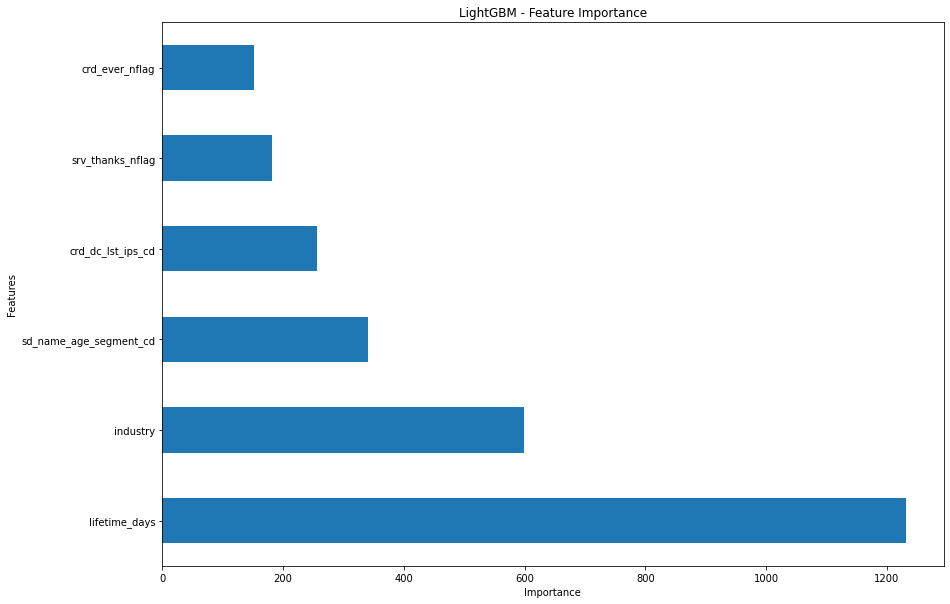

In [126]:
autoaltmode.alternative_modeling(max_feature=6)

In [127]:
make_scorer(gini_score, needs_proba=True)(autoaltmode.model, encoded_oos_x, oos_y)

0.42358711926523474

In [128]:
import catboost as cb

In [131]:
cb_model = cb.CatBoostClassifier(verbose=0)
cb_model.fit(encoded_train_x, train_y)

In [136]:
from sklearn.model_selection import train_test_split

encoded_cb_train_x, encoded_cb_valid_x, cb_train_y, cb_valid_y = train_test_split(encoded_train_x, train_y)

In [146]:
import optuna

def cb_params(trial) -> dict:
    grow_policy = ['SymmetricTree', 'Depthwise', 'Lossguide']
    param = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        # "rsm": trial.suggest_uniform("rsm", 0.4, 1.0),  # same 'colsample_bylevel'
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0),
        "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 1, 100),
        "random_strength": trial.suggest_uniform("random_strength", 0., 10.0),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ['Bayesian', 'Bernoulli']),  # Poisson - only GPU
        "grow_policy": trial.suggest_categorical("grow_policy", grow_policy),
        #'loss_function': trial.suggest_categorical('loss_function', ['Logloss', 'CrossEntropy']),
        "leaf_estimation_method": trial.suggest_categorical("leaf_estimation_method", ['Newton', 'Gradient']),
        "leaf_estimation_iterations": trial.suggest_int("leaf_estimation_iterations", 1, 7),
#         "nan_mode": trial.suggest_categorical("nan_mode", ['Min', 'Max']),
        "fold_permutation_block": trial.suggest_int("fold_permutation_block", 1, 10),
        'verbose': 0,  # same 'logging_level'
    }

    # TODO: Понять как, а главное зачем, нужно в корячить еще 2 гиперпараметра "sampling_frequency" и "sampling_unit"
    #     param["sampling_frequency"] = trial.suggest_categorical("sampling_frequency", ['PerTree'])

    if param["grow_policy"] == 'Lossguide':
        param["max_leaves"] = trial.suggest_int("max_leaves", 16, 256)
        param["depth"] = trial.suggest_int("depth", 6, 24)
    else:
        param["depth"] = trial.suggest_int("depth", 1, 10)
    #     param["sampling_frequency"] = trial.suggest_categorical("sampling_frequency", ['PerTree'])
    # else:
    #     choice = np.random.choice([0, 1])
    #     if choice == 0:
    #         param["sampling_frequency"] = trial.suggest_categorical("sampling_frequency", ['PerTreeLevel'])
    #     else:
    #         param["sampling_frequency"] = trial.suggest_categorical("sampling_frequency", ['PerTree'])

    if param["bootstrap_type"] == 'Bayesian':
        param["bagging_temperature"] = trial.suggest_uniform("bagging_temperature", 0., 10.)
    else:
        param["subsample"] = trial.suggest_uniform("subsample", 0.4, 1.0)

    return param

def objective(trial):
    params = cb_params(trial)
    model = cb.CatBoostClassifier(**params, random_seed=0)
    return cross_val_score(estimator=model, X=encoded_train_x, y=train_y, scoring=make_scorer(gini_score, needs_proba=True), cv=3, n_jobs=7).mean()

In [152]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2022-04-28 16:18:05,025] A new study created in memory with name: no-name-d71c4eca-3dd0-4c01-89be-4a1d21a7915d
[I 2022-04-28 16:18:06,156] Trial 0 finished with value: 0.5862318039534858 and parameters: {'iterations': 452, 'learning_rate': 0.04942105114986946, 'l2_leaf_reg': 1.1333917088034557, 'min_data_in_leaf': 81, 'random_strength': 8.7670335532897, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'leaf_estimation_method': 'Newton', 'leaf_estimation_iterations': 1, 'fold_permutation_block': 2, 'depth': 7, 'subsample': 0.7789002717077218}. Best is trial 0 with value: 0.5862318039534858.
[I 2022-04-28 16:18:10,256] Trial 1 finished with value: 0.5960396286613445 and parameters: {'iterations': 238, 'learning_rate': 0.03251979464781557, 'l2_leaf_reg': 8.249699672007326, 'min_data_in_leaf': 53, 'random_strength': 0.08442572908141988, 'bootstrap_type': 'Bayesian', 'grow_policy': 'Lossguide', 'leaf_estimation_method': 'Gradient', 'leaf_estimation_iterations': 2, 'fold_per

In [153]:
study.best_params

{'iterations': 220,
 'learning_rate': 0.0011349065965394146,
 'l2_leaf_reg': 0.9871521315917045,
 'min_data_in_leaf': 54,
 'random_strength': 6.919783626740396,
 'bootstrap_type': 'Bayesian',
 'grow_policy': 'Depthwise',
 'leaf_estimation_method': 'Gradient',
 'leaf_estimation_iterations': 4,
 'fold_permutation_block': 4,
 'depth': 1,
 'bagging_temperature': 7.119951584701868}

In [154]:
cb_model = cb.CatBoostClassifier(**study.best_params, random_seed=0)
cb_model.fit(encoded_train_x, train_y)

0:	learn: 0.6929118	total: 2.77ms	remaining: 608ms
1:	learn: 0.6926546	total: 5.57ms	remaining: 607ms
2:	learn: 0.6924101	total: 8.32ms	remaining: 602ms
3:	learn: 0.6921758	total: 10.9ms	remaining: 587ms
4:	learn: 0.6919293	total: 13.3ms	remaining: 574ms
5:	learn: 0.6916977	total: 15.8ms	remaining: 565ms
6:	learn: 0.6914422	total: 18.3ms	remaining: 558ms
7:	learn: 0.6911871	total: 21ms	remaining: 557ms
8:	learn: 0.6909597	total: 23.6ms	remaining: 553ms
9:	learn: 0.6907084	total: 26.1ms	remaining: 548ms
10:	learn: 0.6904641	total: 28.8ms	remaining: 547ms
11:	learn: 0.6902327	total: 31.3ms	remaining: 542ms
12:	learn: 0.6900067	total: 34.1ms	remaining: 543ms
13:	learn: 0.6897767	total: 37ms	remaining: 545ms
14:	learn: 0.6895512	total: 39.5ms	remaining: 539ms
15:	learn: 0.6893193	total: 42.1ms	remaining: 536ms
16:	learn: 0.6890952	total: 44.5ms	remaining: 531ms
17:	learn: 0.6888707	total: 47.1ms	remaining: 529ms
18:	learn: 0.6886226	total: 49.5ms	remaining: 524ms
19:	learn: 0.6883995	total

In [158]:
make_scorer(gini_score, needs_proba=True)(cb_model, encoded_oot_x, oot_y)

0.379404042079732

In [159]:
make_scorer(gini_score, needs_proba=True)(cb_model, encoded_oos_x, oos_y)

0.43533486781827535

In [157]:
cb_model